## Principe du LSTM

Perceptron classique:
- Output = $\sigma(\sum_iw_ix_i)$

Un LSTM manipule trois vecteurs principaux à chaque pas de temps t :
- $x_t$ : l'entrée à l'instant $t$,
- $h_{t-1}$ : l'état caché précédent (aussi appelé hidden state),
- $c_{t-1}$ : l'état de la cellule (cell state).

Il produit :
- $h_t$ : le nouvel état caché,
- $c_t$ : le nouvel état de la cellule.

⸻

2. Équations du LSTM

a) Portes (gates)

Les portes contrôlent le flux d'informations.
Elles sont implémentées via des couches sigmoïdes ($\sigma$) et des produits de Hadamard ($\odot$).
	1.	Porte d'oubli (forget gate) :
$f_t = \sigma(W_f x_t + U_f h_{t-1} + b_f)$
Elle détermine quelle partie de l’état précédent c_{t-1} doit être oubliée.
	2.	Porte d'entrée (input gate) :
$i_t = \sigma(W_i x_t + U_i h_{t-1} + b_i)$
Elle contrôle quelles nouvelles informations vont être ajoutées à la cellule.
	3.	Candidat à l'état de la cellule (cell candidate) :
$\tilde{c}t = \tanh(W_c x_t + U_c h{t-1} + b_c)$
C'est le vecteur d'informations potentielles à insérer dans la cellule.

⸻

b) Mise à jour de l'état de la cellule

$c_t = f_t \odot c_{t-1} + i_t \odot \tilde{c}_t$
→ mélange entre l'ancien état et le nouvel apport d'information.

⸻

c) Porte de sortie et état caché
	1.	Porte de sortie :
$o_t = \sigma(W_o x_t + U_o h_{t-1} + b_o)$
	2.	État caché mis à jour :
$h_t = o_t \odot \tanh(c_t)$

⸻

3. Résumé matriciel (forme compacte)

On peut regrouper les calculs ainsi :
$\begin{bmatrix}
i_t \\ f_t \\ o_t \\ \tilde{c}_t
\end{bmatrix}$

$\begin{bmatrix}
\sigma \\ \sigma \\ \sigma \\ \tanh
\end{bmatrix}
\left(
W
\begin{bmatrix}
h_{t-1} \\ x_t
\end{bmatrix}
	•	b
\right)$

puis
$c_t = f_t \odot c_{t-1} + i_t \odot \tilde{c}_t, \quad
h_t = o_t \odot \tanh(c_t)$

⸻

4. Paramètres du modèle

Chaque ensemble de poids $W_f, W_i, W_o, W_c$ est une matrice de taille :
$\text{(dimension cachée)} \times (\text{dimension entrée} + \text{dimension cachée})$

Les biais $b_f, b_i, b_o, b_c$ sont des vecteurs de la taille de la dimension cachée.


## LSTM simple sans optimisation ( reférence : https://github.com/tlemenestrel/LSTM_GARCH )

In [ ]:
!pip install arch
!pip install keras_tuner
!pip install tensorflow
!pip install pydot graphviz
!wget -q https://raw.githubusercontent.com/Undeavor/PE28/main/CREDITAGRICOLESA_2025-10-15.txt -O CA2.txt


import pandas as pd
from pandas.plotting import autocorrelation_plot
from pandas_datareader import data
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

%matplotlib inline

from tensorflow import keras
import keras_tuner
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model


# Datetime

import datetime

# Scikit-Learn

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

# GARCH model

import arch

# Keras

from keras.models import Model
from keras.layers import *
from tensorflow.keras.utils import plot_model

# Tensorflow

import tensorflow as tf

In [ ]:
sp = pd.read_csv("/content/CA2.txt", sep="\t",usecols=["Date", "ouv", "haut", "bas", "Close", "vol", "devise"], parse_dates=["Date"], dayfirst=True )
print (sp.head())
print (sp.shape)

        Date     ouv    haut     bas   Close      vol devise
0 2005-10-17  23.078  23.172  22.899  23.040  2764750    EUR
1 2005-10-18  23.031  23.078  22.580  22.599  4425717    EUR
2 2005-10-19  22.467  22.608  22.223  22.241  4345454    EUR
3 2005-10-20  22.636  22.768  22.194  22.241  3568692    EUR
4 2005-10-21  22.091  22.420  22.091  22.138  2883072    EUR
(5119, 7)


In [ ]:
sp.Date = pd.to_datetime(sp.Date)
sp.dropna(inplace = True)
sp.drop(columns = ["ouv", "haut", "bas", "vol", "devise"], inplace = True)
sp.set_index('Date', inplace=True)
print (sp.head())
print (sp.shape)

        Date   Close
0 2005-10-17  23.040
1 2005-10-18  22.599
2 2005-10-19  22.241
3 2005-10-20  22.241
4 2005-10-21  22.138
(5119, 2)


In [ ]:
print (sp.head())
print (sp.shape)

             Close
Date              
2005-10-17  23.040
2005-10-18  22.599
2005-10-19  22.241
2005-10-20  22.241
2005-10-21  22.138
(5119, 1)


In [ ]:
sp['log_returns'] = np.log(sp['Close'] / sp['Close'].shift(1))
sp['Next_10_Days_Volatility'] = sp['log_returns'].iloc[::-1].rolling(window = 10).std().iloc[::-1]
sp.dropna(inplace = True)
print(sp.head())

X = np.array(sp.drop(["Next_10_Days_Volatility",'Close'], axis=1).values)
y = np.array(sp["Next_10_Days_Volatility"].values).reshape(-1, 1)

test_size = 1500

X_train = X[test_size:,]
X_test = X[:test_size,]
y_train = y[test_size:]
y_test = y[:test_size]

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

             Close  log_returns  Next_10_Days_Volatility
Date                                                    
2005-10-18  22.599    -0.019326                 0.016791
2005-10-19  22.241    -0.015968                 0.015401
2005-10-20  22.241     0.000000                 0.014112
2005-10-21  22.138    -0.004642                 0.014855
2005-10-24  22.617     0.021406                 0.014805
(3609, 1) (3609, 1)
(1500, 1) (1500, 1)


In [ ]:
def get_lagged(x, y, t, s):
    lagged = []
    for i in range(x.shape[0] - t):
        if i == x.shape[0] - t:
            break
        for k in range(t):
            if k < t:
                lagged.append(x[i+k])
    lagged = np.array(lagged).reshape(s)
    return lagged, y[:lagged.shape[0],]

In [ ]:
N = 30

X_train, y_train = get_lagged(X_train, y_train, N, (X_train.shape[0]-N, N*X_train.shape[1]))
X_test, y_test = get_lagged(X_test, y_test, N, (X_test.shape[0]-N, N*X_test.shape[1]))

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(3579, 30) (1470, 30)
(3579, 1) (1470, 1)


In [ ]:
T = 4

X_train, y_train = get_lagged(X_train, y_train, T, (X_train.shape[0]-T, T, X_train.shape[1]))
X_test, y_test = get_lagged(X_test, y_test, T, (X_test.shape[0]-T, T, X_test.shape[1]))

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(3575, 4, 30) (1466, 4, 30)
(3575, 1) (1466, 1)


In [ ]:
inputLSTM = Input(shape=(X_train.shape[1], X_train.shape[2]))
y = LSTM(200, return_sequences=True)(inputLSTM)
y = LSTM(200)(y)
y = Dense(1)(y)
lstm = Model(inputs=inputLSTM, outputs=y)
lstm.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 4, 30)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 4, 200)         │       184,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 200)            │       320,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 505,801 (1.93 MB)

 Trainable params: 505,801 (1.93 MB)

 Non-trainable params: 0 (0.00 B)

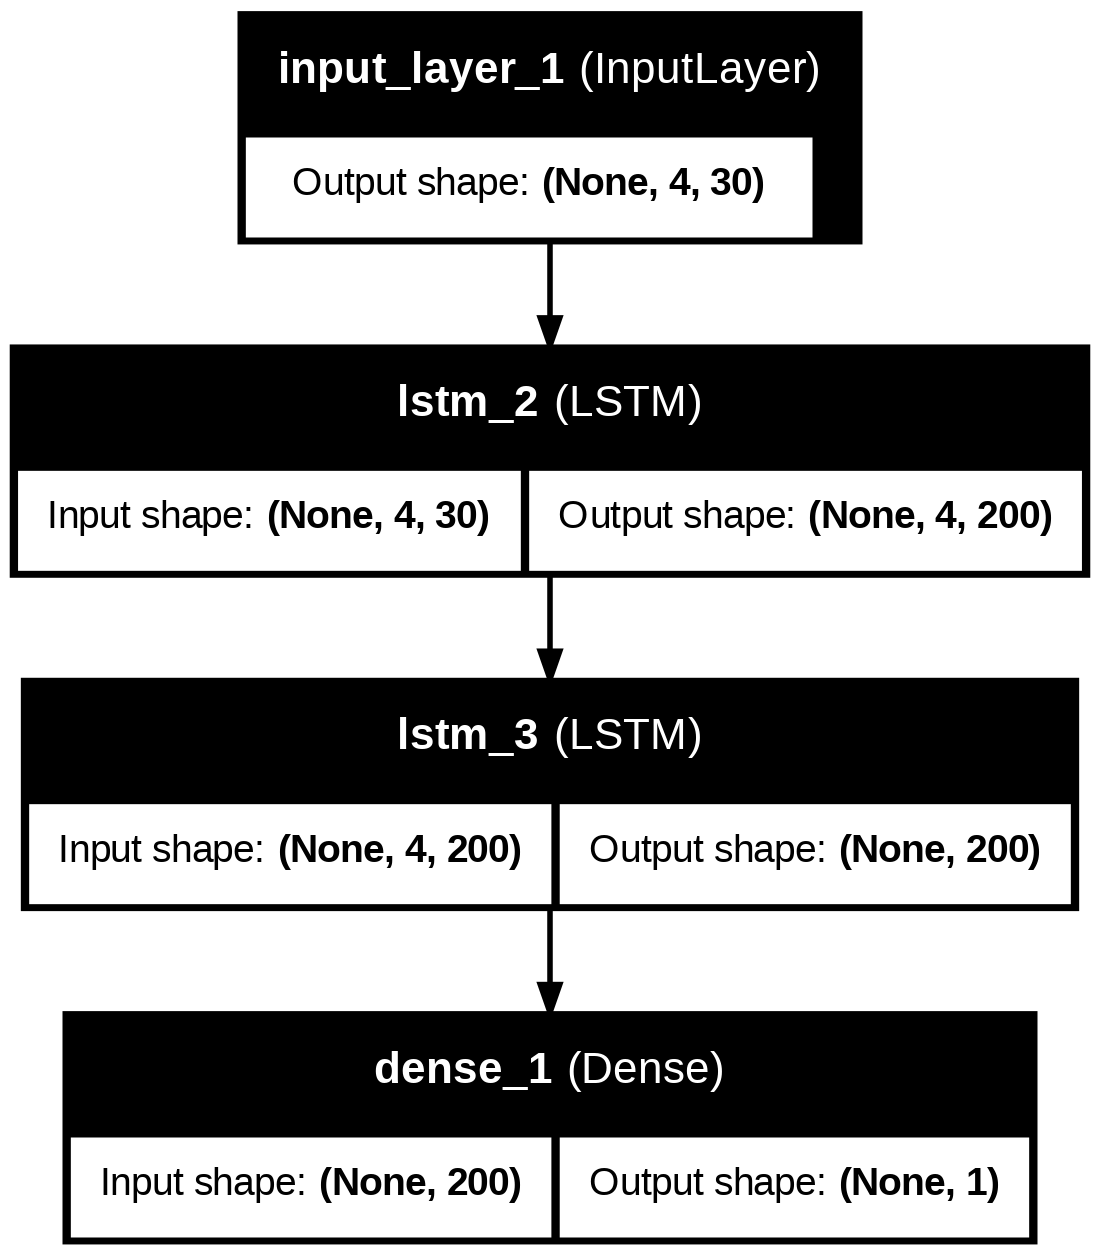

In [ ]:
plot_model(lstm, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
lstm.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01),loss=tf.keras.losses.MeanSquaredError(),metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [ ]:
hist = lstm.fit(X_train, y_train,batch_size=700,epochs=60,verbose=1,validation_split=0.3,shuffle=False)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 245ms/step - loss: 1.7441e-04 - root_mean_squared_error: 0.0131 - val_loss: 9.2850e-05 - val_root_mean_squared_error: 0.0096
Epoch 24/60
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 476ms/step - loss: 1.7242e-04 - root_mean_squared_error: 0.0131 - val_loss: 8.8700e-05 - val_root_mean_squared_error: 0.0094
Epoch 25/60
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 534ms/step - loss: 1.7360e-04 - root_mean_squared_error: 0.0131 - val_loss: 8.9231e-05 - val_root_mean_squared_error: 0.0094
Epoch 26/60
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 225ms/step - loss: 1.7398e-04 - root_mean_squared_error: 0.0131 - val_loss: 9.1113e-05 - val_root_mean_squared_error: 0.0095
Epoch 27/60
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 397ms/step - loss: 1.7287e-04 - root_mean_squared_error: 0.0131 - val_loss: 8.8817e-05 - val_root_mean_squared_error: 0.0094
Epoch 28/60
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 294ms/step - loss: 1.7352e-04 - root_mean_squared_error: 0.0131 - val_loss: 8.9183e-05 - val_root_mean_squared_error: 0.0094
Epoch 29/60
4/4 ━━━━━━

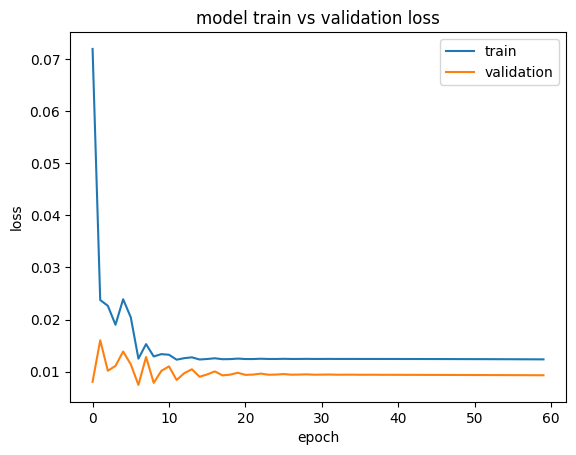

In [ ]:
plt.plot(hist.history['root_mean_squared_error'])
plt.plot(hist.history['val_root_mean_squared_error'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [ ]:
def printing_out_results_of_a_model(model,X_test,y_test):
    y_pred = model.predict(X_test)
    # Print the R2 score
    print ("R2 score:\n")
    print (('{:.2f}'.format((100*(r2_score(y_test, y_pred))))) + " %")
    print ("\n")
    # Print the RMSE
    print ("RMSE:\n")
    print (math.sqrt(mean_squared_error(y_test, y_pred)))
    print ('\n')
    # Print the mean squared error
    print ("Mean Squared Error:\n")
    print (mean_squared_error(y_test, y_pred))


In [ ]:
printing_out_results_of_a_model(lstm, X_test, y_test)

46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
R2 score:

-10.99 %


RMSE:

0.017016939209302827


Mean Squared Error:

0.00028957622005310794


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


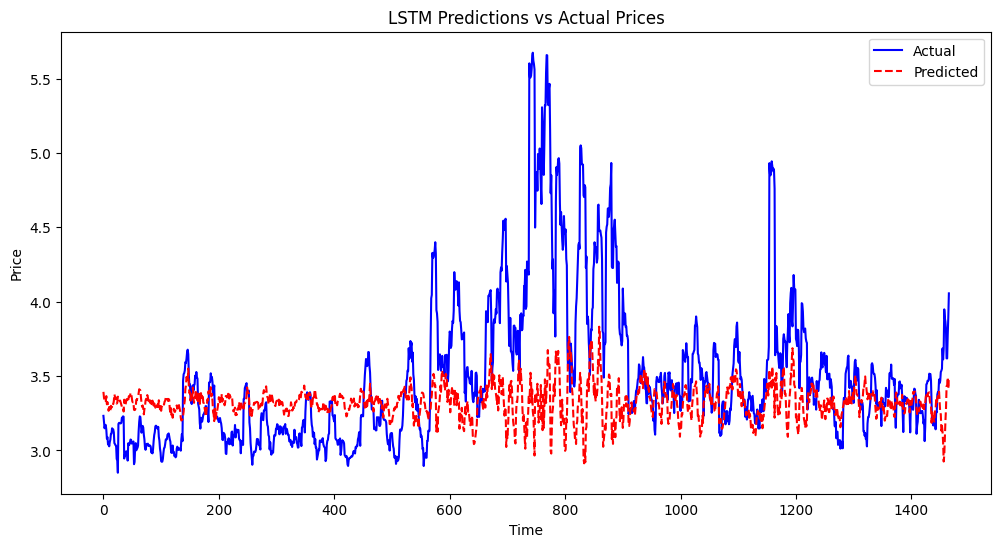

In [ ]:
y_pred = lstm.predict(X_test)


scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(sp[['Close']])
# Reshape to 2D for scaler
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = scaler.inverse_transform(y_pred.reshape(-1, 1))

plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label='Actual', color='blue')
plt.plot(y_pred_inv, label='Predicted', color='red', linestyle='--')
plt.title('LSTM Predictions vs Actual Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

## LSTM ( ici utilisation trop compliquée, en tout cas trop longue : https://github.com/nataliaroszyk/volatility_prediction )

In [ ]:
!pip install keras_tuner
!pip install openpyxl
!pip install tensorflow
!pip install arch
!wget -q https://raw.githubusercontent.com/Undeavor/PE28/main/sp500.xlsx -O sp500.xlsx
!wget -q https://raw.githubusercontent.com/Undeavor/PE28/main/CREDITAGRICOLESA_2025-10-15.txt -O CA2.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 978.3/978.3 kB 13.7 MB/s eta 0:00:00


In [ ]:
#clear data
import pandas as pd
import openpyxl
import numpy as np

sp = pd.read_csv("/content/CA2.txt", sep="\t",usecols=["Date", "ouv", "haut", "bas", "Close", "vol", "devise"], parse_dates=["Date"], dayfirst=True )
#sp = pd.read_excel('/content/sp500.xlsx')

rolling_window_size = 22 #????????? jours ???????

# Calculate daily log returns
sp['log_returns'] = np.log(sp['Close'] / sp['Close'].shift(1))

# Calculate volatility as the std of daily log returns
sp['volatility'] = sp['log_returns'].rolling(window=rolling_window_size).std()

# Add lagged volatility
lag_days = 1
for i in range(1, lag_days + 1):
    sp[f'lagged_volatility_{i}'] = sp['volatility'].shift(i)

sp.dropna(inplace=True)

# Clean dataset
sp.Date = pd.to_datetime(sp.Date)
sp.dropna(inplace = True)
#sp.drop(columns = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], inplace = True)
sp.drop(columns = ["ouv", "haut", "bas", "vol", "devise"], inplace = True)

# Filter for dates >= 2000 year
sp_2000 = sp[sp.Date >= '01-01-2000']

# Save
sp_2000.to_excel('/content/lstm_data.xlsx')

In [ ]:
#parameter tuning
from tensorflow import keras
import kerastuner
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from kerastuner.tuners import RandomSearch

# Load data
df = pd.read_excel('/content/lstm_data.xlsx')

# Convert 'Date' to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Filter for dates >= 2000 year
df = df[df.Date >= '2000-01-01']

# Setup features and target column
feature_columns = [col for col in df.columns if col not in ['volatility', 'Date']]
target_column = 'volatility'

# Prepare data
time_steps = 22  # Sequence length
X, y = create_dataset(df[feature_columns], df[target_column].values.reshape(-1, 1), time_steps) # [samples, time steps, features]
input_shape = (time_steps, X.shape[2])

# Hyperparameter tuning on the first 15 years of data
index_15_years = 252*15
tune_X, tune_y = X[:index_15_years], y[:index_15_years]

# Modified create_model function to incorporate hyperparameters
def build_model(hp):
    model = Sequential()
    for i in range(hp.Int('num_layers', 1, 3)):
        model.add(LSTM(units=hp.Choice('units_lstm_' + str(i), [32,64,128]),
                       activation=hp.Choice('activation_' + str(i), ['tanh', 'relu']),
                       return_sequences=True if i < hp.get('num_layers') - 1 else False,
                       input_shape=input_shape))
        model.add(Dropout(rate=hp.Float('dropout_' + str(i), min_value=0.0, max_value=0.3, step=0.1)))
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer=Adam(learning_rate=hp.Choice('learning_rate', [0.01, 0.001, 0.0001])),
                  loss=hp.Choice('loss', ['mean_squared_error', 'mean_absolute_error']))
    return model

# Configure the tuner
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=50,
    executions_per_trial=3,
    directory='model_tuning',
    project_name='LSTM_Tuning'
)

# Early stopping
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Start hyperparameter search
tuner.search(tune_X, tune_y, epochs=50, validation_split=0.6, callbacks=[early_stopping], verbose = 1)

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"Best hyperparameters: {best_hps.values}")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
1                 |1                 |num_layers
128               |128               |units_lstm_0
relu              |relu              |activation_0
0.1               |0.1               |dropout_0
0.01              |0.01              |learning_rate
mean_absolute_e...|mean_absolute_e...|loss

Epoch 1/50


KeyboardInterrupt: 

In [ ]:
#function declaration
from keras.models import Sequential
from keras.layers import Input, LSTM, Dense, Dropout
from keras.optimizers import Adam

# Convert to LSTM-friendly format
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X[i:(i + time_steps)]
        Xs.append(v)
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

# Function to create the LSTM model ( has to be tuned by the previous results )
def create_model(input_shape):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(LSTM(32, return_sequences=True, activation='relu'))
    model.add(Dropout(0.1))
    model.add(LSTM(128, return_sequences=False, activation='tanh'))
    model.add(Dropout(0.1))
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error')
    return model

# Function to decide if retraining is needed
def should_retrain(counter, interval=252):
    return counter % interval == 0

In [ ]:
######## Avec les données du github l'on a minimum 6h de runtime
import os
import random
import tensorflow as tf
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

# Load sp_lstm data
df = pd.read_excel('/content/lstm_data.xlsx')

# Convert 'Date' to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Filter for dates >= 2000 year
df = df[df.Date >= '2000-01-01']

# Setup features and target column
feature_columns = [col for col in df.columns if col not in ['volatility', 'Date']]
target_column = 'volatility'

time_steps = 22  # Sequence length
X, y = create_dataset(df[feature_columns], df[target_column].values.reshape(-1, 1), time_steps) # [samples, time steps, features]

# Set random seeds for reproducibility
os.environ['PYTHONHASHSEED'] = '3'
random.seed(3)
np.random.seed(3)
tf.random.set_seed(3)

# Setup for predictions
input_shape = (time_steps, X.shape[2])
model_save_path = 'lstm.weights.h5'

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

initial_train_size = 12 * 252
validation_size = 3 * 252

results = []
counter = 0

# Walk forward prediction with model refitting every 252 days
for i in range(len(df) - initial_train_size - validation_size - 1):
    # Check if there is enough data for the test set to form a complete sequence
    if (i + initial_train_size + validation_size + time_steps > len(X)):
        print("Not enough data to form a complete sequence for testing. Ending predictions.")
        break  # Exit the loop if there isn't enough data left for a full sequence

    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()

    # Fit scaler on current training data
    scaler_X.fit(X[i:i+initial_train_size].reshape(-1, X.shape[2]))
    scaler_y.fit(y[i:i+initial_train_size].reshape(-1, 1))

    # Transform train, validation, and test data
    train_X = scaler_X.transform(X[i:i+initial_train_size].reshape(-1, X.shape[2])).reshape(-1, time_steps, X.shape[2])
    train_y = scaler_y.transform(y[i:i+initial_train_size].reshape(-1, 1)).reshape(-1, 1)
    val_X = scaler_X.transform(X[i+initial_train_size:i+initial_train_size+validation_size].reshape(-1, X.shape[2])).reshape(-1, time_steps, X.shape[2])
    val_y = scaler_y.transform(y[i+initial_train_size:i+initial_train_size+validation_size].reshape(-1, 1)).reshape(-1, 1)
    test_X = scaler_X.transform(X[i+initial_train_size+validation_size:i+initial_train_size+validation_size+1].reshape(-1, X.shape[2])).reshape(-1, time_steps, X.shape[2])
    test_y = scaler_y.transform(y[i+initial_train_size+validation_size:i+initial_train_size+validation_size+1].reshape(-1, 1)).reshape(-1, 1)

    if should_retrain(counter) or not os.path.exists(model_save_path):
        model = create_model(input_shape)
        model.fit(train_X, train_y, epochs=100, batch_size=256, validation_data=(val_X, val_y), verbose=0, callbacks=[early_stopping])
        model.save_weights(model_save_path)
    else:
        model = create_model(input_shape)
        model.load_weights(model_save_path)
        model.fit(train_X[-1].reshape(1, *train_X[-1].shape), train_y[-1].reshape(1, 1), epochs=1, verbose=0)

    predicted = model.predict(test_X)
    predicted = scaler_y.inverse_transform(predicted.reshape(-1, 1))
    actual = scaler_y.inverse_transform(test_y.reshape(-1, 1))
    mae = mean_absolute_error(actual, predicted)

        # Print current results
    current_result = {
        'train_start': df['Date'][i+time_steps],
        'train_end': df['Date'][i+initial_train_size+time_steps-1],
        'validation_start': df['Date'][i+initial_train_size+time_steps],
        'validation_end': df['Date'][i+initial_train_size+validation_size+time_steps-1],
        'test_date': df['Date'][i+initial_train_size+validation_size+time_steps],
        'prediction': predicted.flatten()[0],
        'actual': actual.flatten()[0],
        'mae': mae
    }
    print(current_result)

    results.append(current_result)
    counter += 1

lstm_results = pd.DataFrame(results)
lstm_results.to_excel('/content/results_lstm.xlsx')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
{'train_start': Timestamp('2005-12-19 00:00:00'), 'train_end': Timestamp('2017-10-10 00:00:00'), 'validation_start': Timestamp('2017-10-11 00:00:00'), 'validation_end': Timestamp('2020-09-28 00:00:00'), 'test_date': Timestamp('2020-09-29 00:00:00'), 'prediction': np.float32(0.027786715), 'actual': np.float64(0.023889369943237683), 'mae': 0.003897345012926677}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step
{'train_start': Timestamp('2005-12-20 00:00:00'), 'train_end': Timestamp('2017-10-11 00:00:00'), 'validation_start': Timestamp('2017-10-12 00:00:00'), 'validation_end': Timestamp('2020-09-29 00:00:00'), 'test_date': Timestamp('2020-09-30 00:00:00'), 'prediction': np.float32(0.027213205), 'actual': np.float64(0.02338634042910461), 'mae': 0.0038268642229663877}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step
{'train_start': Timestamp('2005-12-21 00:00:00'), 'train_end': Timestamp('2017-10-12 00:00:00'), 'validation_start': Timestamp('2017-10-13 00:00:00'), 'validation_end': Timestamp('2020-09-30 00:00:00'), 'test_date': Timestamp('2020-10-01 00:00:00'), 'prediction': np.float32(0.02769537), 'actual': np.float64(0.023517739512498748), 'mae': 0.004177631325547326}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step
{'train_start': Timestamp('2005-12-22 00:00:00'), 'train_end': Timestamp('2017-10-13 00:00:00'), 'validation_start': Timestamp('2017-10-16 00:00:00'), 'validation_end': Timestamp('2020-10-01 00:00:00'), 'test_date': Timestamp('2020-10-02 00:00:00'), 'prediction': np.float32(0.028093794), 'actual': np.float64(0.02353680861108265), 'mae': 0.004556985749674225}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


{'train_start': Timestamp('2005-12-23 00:00:00'), 'train_end': Timestamp('2017-10-16 00:00:00'), 'validation_start': Timestamp('2017-10-17 00:00:00'), 'validation_end': Timestamp('2020-10-02 00:00:00'), 'test_date': Timestamp('2020-10-05 00:00:00'), 'prediction': np.float32(0.02856767), 'actual': np.float64(0.02409159424923897), 'mae': 0.004476075663933751}


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


{'train_start': Timestamp('2005-12-27 00:00:00'), 'train_end': Timestamp('2017-10-17 00:00:00'), 'validation_start': Timestamp('2017-10-18 00:00:00'), 'validation_end': Timestamp('2020-10-05 00:00:00'), 'test_date': Timestamp('2020-10-06 00:00:00'), 'prediction': np.float32(0.028844383), 'actual': np.float64(0.026227122944233797), 'mae': 0.0026172596696635263}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step
{'train_start': Timestamp('2005-12-28 00:00:00'), 'train_end': Timestamp('2017-10-18 00:00:00'), 'validation_start': Timestamp('2017-10-19 00:00:00'), 'validation_end': Timestamp('2020-10-06 00:00:00'), 'test_date': Timestamp('2020-10-07 00:00:00'), 'prediction': np.float32(0.028795224), 'actual': np.float64(0.02605107973121342), 'mae': 0.0027441439519053992}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
{'train_start': Timestamp('2005-12-29 00:00:00'), 'train_end': Timestamp('2017-10-19 00:00:00'), 'validation_start': Timestamp('2017-10-20 00:00:00'), 'validation_end': Timestamp('2020-10-07 00:00:00'), 'test_date': Timestamp('2020-10-08 00:00:00'), 'prediction': np.float32(0.028885128), 'actual': np.float64(0.02598333688575395), 'mae': 0.002901791090782802}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step
{'train_start': Timestamp('2005-12-30 00:00:00'), 'train_end': Timestamp('2017-10-20 00:00:00'), 'validation_start': Timestamp('2017-10-23 00:00:00'), 'validation_end': Timestamp('2020-10-08 00:00:00'), 'test_date': Timestamp('2020-10-09 00:00:00'), 'prediction': np.float32(0.029204262), 'actual': np.float64(0.025639040177215106), 'mae': 0.003565222243319982}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step
{'train_start': Timestamp('2006-01-02 00:00:00'), 'train_end': Timestamp('2017-10-23 00:00:00'), 'validation_start': Timestamp('2017-10-24 00:00:00'), 'validation_end': Timestamp('2020-10-09 00:00:00'), 'test_date': Timestamp('2020-10-12 00:00:00'), 'prediction': np.float32(0.029383112), 'actual': np.float64(0.02567619809086319), 'mae': 0.0037069136542559056}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step
{'train_start': Timestamp('2006-01-03 00:00:00'), 'train_end': Timestamp('2017-10-24 00:00:00'), 'validation_start': Timestamp('2017-10-25 00:00:00'), 'validation_end': Timestamp('2020-10-12 00:00:00'), 'test_date': Timestamp('2020-10-13 00:00:00'), 'prediction': np.float32(0.029405694), 'actual': np.float64(0.026506296715054164), 'mae': 0.002899397739854207}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step
{'train_start': Timestamp('2006-01-04 00:00:00'), 'train_end': Timestamp('2017-10-25 00:00:00'), 'validation_start': Timestamp('2017-10-26 00:00:00'), 'validation_end': Timestamp('2020-10-13 00:00:00'), 'test_date': Timestamp('2020-10-14 00:00:00'), 'prediction': np.float32(0.029592346), 'actual': np.float64(0.02637387487072618), 'mae': 0.003218471529296326}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step
{'train_start': Timestamp('2006-01-05 00:00:00'), 'train_end': Timestamp('2017-10-26 00:00:00'), 'validation_start': Timestamp('2017-10-27 00:00:00'), 'validation_end': Timestamp('2020-10-14 00:00:00'), 'test_date': Timestamp('2020-10-15 00:00:00'), 'prediction': np.float32(0.029661579), 'actual': np.float64(0.026951069953322974), 'mae': 0.0027105091042512984}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step
{'train_start': Timestamp('2006-01-06 00:00:00'), 'train_end': Timestamp('2017-10-27 00:00:00'), 'validation_start': Timestamp('2017-10-30 00:00:00'), 'validation_end': Timestamp('2020-10-15 00:00:00'), 'test_date': Timestamp('2020-10-16 00:00:00'), 'prediction': np.float32(0.029861372), 'actual': np.float64(0.02729599332008621), 'mae': 0.0025653786441300237}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step
{'train_start': Timestamp('2006-01-09 00:00:00'), 'train_end': Timestamp('2017-10-30 00:00:00'), 'validation_start': Timestamp('2017-10-31 00:00:00'), 'validation_end': Timestamp('2020-10-16 00:00:00'), 'test_date': Timestamp('2020-10-19 00:00:00'), 'prediction': np.float32(0.029985357), 'actual': np.float64(0.027397028717968147), 'mae': 0.0025883283579614946}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step
{'train_start': Timestamp('2006-01-10 00:00:00'), 'train_end': Timestamp('2017-10-31 00:00:00'), 'validation_start': Timestamp('2017-11-01 00:00:00'), 'validation_end': Timestamp('2020-10-19 00:00:00'), 'test_date': Timestamp('2020-10-20 00:00:00'), 'prediction': np.float32(0.030078957), 'actual': np.float64(0.026858255558982577), 'mae': 0.00322070129834107}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
{'train_start': Timestamp('2006-01-11 00:00:00'), 'train_end': Timestamp('2017-11-01 00:00:00'), 'validation_start': Timestamp('2017-11-02 00:00:00'), 'validation_end': Timestamp('2020-10-20 00:00:00'), 'test_date': Timestamp('2020-10-21 00:00:00'), 'prediction': np.float32(0.030226542), 'actual': np.float64(0.024489296416011577), 'mae': 0.005737245267066236}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
{'train_start': Timestamp('2006-01-12 00:00:00'), 'train_end': Timestamp('2017-11-02 00:00:00'), 'validation_start': Timestamp('2017-11-03 00:00:00'), 'validation_end': Timestamp('2020-10-21 00:00:00'), 'test_date': Timestamp('2020-10-22 00:00:00'), 'prediction': np.float32(0.030360008), 'actual': np.float64(0.02456494448816393), 'mae': 0.005795063170436876}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
{'train_start': Timestamp('2006-01-13 00:00:00'), 'train_end': Timestamp('2017-11-03 00:00:00'), 'validation_start': Timestamp('2017-11-06 00:00:00'), 'validation_end': Timestamp('2020-10-22 00:00:00'), 'test_date': Timestamp('2020-10-23 00:00:00'), 'prediction': np.float32(0.030418787), 'actual': np.float64(0.02487988490929156), 'mae': 0.005538902242283528}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
{'train_start': Timestamp('2006-01-16 00:00:00'), 'train_end': Timestamp('2017-11-06 00:00:00'), 'validation_start': Timestamp('2017-11-07 00:00:00'), 'validation_end': Timestamp('2020-10-23 00:00:00'), 'test_date': Timestamp('2020-10-26 00:00:00'), 'prediction': np.float32(0.030256039), 'actual': np.float64(0.025003939037755246), 'mae': 0.0052520994939057875}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
{'train_start': Timestamp('2006-01-17 00:00:00'), 'train_end': Timestamp('2017-11-07 00:00:00'), 'validation_start': Timestamp('2017-11-08 00:00:00'), 'validation_end': Timestamp('2020-10-26 00:00:00'), 'test_date': Timestamp('2020-10-27 00:00:00'), 'prediction': np.float32(0.030086627), 'actual': np.float64(0.025761312856275753), 'mae': 0.0043253143737724264}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step
{'train_start': Timestamp('2006-01-18 00:00:00'), 'train_end': Timestamp('2017-11-08 00:00:00'), 'validation_start': Timestamp('2017-11-09 00:00:00'), 'validation_end': Timestamp('2020-10-27 00:00:00'), 'test_date': Timestamp('2020-10-28 00:00:00'), 'prediction': np.float32(0.031716663), 'actual': np.float64(0.024018307158693585), 'mae': 0.00769835623170444}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step
{'train_start': Timestamp('2006-01-19 00:00:00'), 'train_end': Timestamp('2017-11-09 00:00:00'), 'validation_start': Timestamp('2017-11-10 00:00:00'), 'validation_end': Timestamp('2020-10-28 00:00:00'), 'test_date': Timestamp('2020-10-29 00:00:00'), 'prediction': np.float32(0.030152434), 'actual': np.float64(0.02369291947586045), 'mae': 0.006459515007310058}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
{'train_start': Timestamp('2006-01-20 00:00:00'), 'train_end': Timestamp('2017-11-10 00:00:00'), 'validation_start': Timestamp('2017-11-13 00:00:00'), 'validation_end': Timestamp('2020-10-29 00:00:00'), 'test_date': Timestamp('2020-10-30 00:00:00'), 'prediction': np.float32(0.03026113), 'actual': np.float64(0.02400803209272869), 'mae': 0.0062530970481251905}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step
{'train_start': Timestamp('2006-01-23 00:00:00'), 'train_end': Timestamp('2017-11-13 00:00:00'), 'validation_start': Timestamp('2017-11-14 00:00:00'), 'validation_end': Timestamp('2020-10-30 00:00:00'), 'test_date': Timestamp('2020-11-02 00:00:00'), 'prediction': np.float32(0.0300286), 'actual': np.float64(0.02481907296901943), 'mae': 0.005209527276694756}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step
{'train_start': Timestamp('2006-01-24 00:00:00'), 'train_end': Timestamp('2017-11-14 00:00:00'), 'validation_start': Timestamp('2017-11-15 00:00:00'), 'validation_end': Timestamp('2020-11-02 00:00:00'), 'test_date': Timestamp('2020-11-03 00:00:00'), 'prediction': np.float32(0.030116402), 'actual': np.float64(0.02648205502747513), 'mae': 0.003634346585283506}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step
{'train_start': Timestamp('2006-01-25 00:00:00'), 'train_end': Timestamp('2017-11-15 00:00:00'), 'validation_start': Timestamp('2017-11-16 00:00:00'), 'validation_end': Timestamp('2020-11-03 00:00:00'), 'test_date': Timestamp('2020-11-04 00:00:00'), 'prediction': np.float32(0.02940371), 'actual': np.float64(0.026327079225553655), 'mae': 0.0030766315122707846}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step
{'train_start': Timestamp('2006-01-26 00:00:00'), 'train_end': Timestamp('2017-11-16 00:00:00'), 'validation_start': Timestamp('2017-11-17 00:00:00'), 'validation_end': Timestamp('2020-11-04 00:00:00'), 'test_date': Timestamp('2020-11-05 00:00:00'), 'prediction': np.float32(0.029012123), 'actual': np.float64(0.02433751559393205), 'mae': 0.0046746075288792675}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step
{'train_start': Timestamp('2006-01-27 00:00:00'), 'train_end': Timestamp('2017-11-17 00:00:00'), 'validation_start': Timestamp('2017-11-20 00:00:00'), 'validation_end': Timestamp('2020-11-05 00:00:00'), 'test_date': Timestamp('2020-11-06 00:00:00'), 'prediction': np.float32(0.02853634), 'actual': np.float64(0.024376588340310215), 'mae': 0.004159751881452442}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step
{'train_start': Timestamp('2006-01-30 00:00:00'), 'train_end': Timestamp('2017-11-20 00:00:00'), 'validation_start': Timestamp('2017-11-21 00:00:00'), 'validation_end': Timestamp('2020-11-06 00:00:00'), 'test_date': Timestamp('2020-11-09 00:00:00'), 'prediction': np.float32(0.028409785), 'actual': np.float64(0.03677832415422779), 'mae': 0.008368539494484482}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
{'train_start': Timestamp('2006-01-31 00:00:00'), 'train_end': Timestamp('2017-11-21 00:00:00'), 'validation_start': Timestamp('2017-11-22 00:00:00'), 'validation_end': Timestamp('2020-11-09 00:00:00'), 'test_date': Timestamp('2020-11-10 00:00:00'), 'prediction': np.float32(0.027980966), 'actual': np.float64(0.03761286935955053), 'mae': 0.00963190286606317}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step
{'train_start': Timestamp('2006-02-01 00:00:00'), 'train_end': Timestamp('2017-11-22 00:00:00'), 'validation_start': Timestamp('2017-11-23 00:00:00'), 'validation_end': Timestamp('2020-11-10 00:00:00'), 'test_date': Timestamp('2020-11-11 00:00:00'), 'prediction': np.float32(0.02791638), 'actual': np.float64(0.03778496765851343), 'mae': 0.009868588385575652}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
{'train_start': Timestamp('2006-02-02 00:00:00'), 'train_end': Timestamp('2017-11-23 00:00:00'), 'validation_start': Timestamp('2017-11-24 00:00:00'), 'validation_end': Timestamp('2020-11-11 00:00:00'), 'test_date': Timestamp('2020-11-12 00:00:00'), 'prediction': np.float32(0.02837149), 'actual': np.float64(0.03710421994858879), 'mae': 0.008732729410468522}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step
{'train_start': Timestamp('2006-02-03 00:00:00'), 'train_end': Timestamp('2017-11-24 00:00:00'), 'validation_start': Timestamp('2017-11-27 00:00:00'), 'validation_end': Timestamp('2020-11-12 00:00:00'), 'test_date': Timestamp('2020-11-13 00:00:00'), 'prediction': np.float32(0.02937095), 'actual': np.float64(0.03710567254762141), 'mae': 0.007734722012681647}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step
{'train_start': Timestamp('2006-02-06 00:00:00'), 'train_end': Timestamp('2017-11-27 00:00:00'), 'validation_start': Timestamp('2017-11-28 00:00:00'), 'validation_end': Timestamp('2020-11-13 00:00:00'), 'test_date': Timestamp('2020-11-16 00:00:00'), 'prediction': np.float32(0.03045746), 'actual': np.float64(0.03611853470163654), 'mae': 0.00566107531147312}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
{'train_start': Timestamp('2006-02-07 00:00:00'), 'train_end': Timestamp('2017-11-28 00:00:00'), 'validation_start': Timestamp('2017-11-29 00:00:00'), 'validation_end': Timestamp('2020-11-16 00:00:00'), 'test_date': Timestamp('2020-11-17 00:00:00'), 'prediction': np.float32(0.03170479), 'actual': np.float64(0.03612331817156069), 'mae': 0.004418527281343863}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step
{'train_start': Timestamp('2006-02-08 00:00:00'), 'train_end': Timestamp('2017-11-29 00:00:00'), 'validation_start': Timestamp('2017-11-30 00:00:00'), 'validation_end': Timestamp('2020-11-17 00:00:00'), 'test_date': Timestamp('2020-11-18 00:00:00'), 'prediction': np.float32(0.032784626), 'actual': np.float64(0.036124134683741226), 'mae': 0.003339508795870437}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step
{'train_start': Timestamp('2006-02-09 00:00:00'), 'train_end': Timestamp('2017-11-30 00:00:00'), 'validation_start': Timestamp('2017-12-01 00:00:00'), 'validation_end': Timestamp('2020-11-18 00:00:00'), 'test_date': Timestamp('2020-11-19 00:00:00'), 'prediction': np.float32(0.033811044), 'actual': np.float64(0.03625464225291455), 'mae': 0.0024435983049794427}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step
{'train_start': Timestamp('2006-02-10 00:00:00'), 'train_end': Timestamp('2017-12-01 00:00:00'), 'validation_start': Timestamp('2017-12-04 00:00:00'), 'validation_end': Timestamp('2020-11-19 00:00:00'), 'test_date': Timestamp('2020-11-20 00:00:00'), 'prediction': np.float32(0.034724995), 'actual': np.float64(0.03586498839607374), 'mae': 0.0011399929021848818}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
{'train_start': Timestamp('2006-02-13 00:00:00'), 'train_end': Timestamp('2017-12-04 00:00:00'), 'validation_start': Timestamp('2017-12-05 00:00:00'), 'validation_end': Timestamp('2020-11-20 00:00:00'), 'test_date': Timestamp('2020-11-23 00:00:00'), 'prediction': np.float32(0.03548802), 'actual': np.float64(0.03645981399636452), 'mae': 0.0009717933676737997}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step
{'train_start': Timestamp('2006-02-14 00:00:00'), 'train_end': Timestamp('2017-12-05 00:00:00'), 'validation_start': Timestamp('2017-12-06 00:00:00'), 'validation_end': Timestamp('2020-11-23 00:00:00'), 'test_date': Timestamp('2020-11-24 00:00:00'), 'prediction': np.float32(0.035839487), 'actual': np.float64(0.03755728041788627), 'mae': 0.0017177935506968653}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step
{'train_start': Timestamp('2006-02-15 00:00:00'), 'train_end': Timestamp('2017-12-06 00:00:00'), 'validation_start': Timestamp('2017-12-07 00:00:00'), 'validation_end': Timestamp('2020-11-24 00:00:00'), 'test_date': Timestamp('2020-11-25 00:00:00'), 'prediction': np.float32(0.03589603), 'actual': np.float64(0.03682994111480295), 'mae': 0.0009339117914634876}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
{'train_start': Timestamp('2006-02-16 00:00:00'), 'train_end': Timestamp('2017-12-07 00:00:00'), 'validation_start': Timestamp('2017-12-08 00:00:00'), 'validation_end': Timestamp('2020-11-25 00:00:00'), 'test_date': Timestamp('2020-11-26 00:00:00'), 'prediction': np.float32(0.037825722), 'actual': np.float64(0.03468013830834915), 'mae': 0.003145583939012986}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step
{'train_start': Timestamp('2006-02-17 00:00:00'), 'train_end': Timestamp('2017-12-08 00:00:00'), 'validation_start': Timestamp('2017-12-11 00:00:00'), 'validation_end': Timestamp('2020-11-26 00:00:00'), 'test_date': Timestamp('2020-11-27 00:00:00'), 'prediction': np.float32(0.037890475), 'actual': np.float64(0.03214900280466431), 'mae': 0.0057414724386656915}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step
{'train_start': Timestamp('2006-02-20 00:00:00'), 'train_end': Timestamp('2017-12-11 00:00:00'), 'validation_start': Timestamp('2017-12-12 00:00:00'), 'validation_end': Timestamp('2020-11-27 00:00:00'), 'test_date': Timestamp('2020-11-30 00:00:00'), 'prediction': np.float32(0.035779007), 'actual': np.float64(0.03263780578325578), 'mae': 0.0031412009959380996}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step
{'train_start': Timestamp('2006-02-21 00:00:00'), 'train_end': Timestamp('2017-12-12 00:00:00'), 'validation_start': Timestamp('2017-12-13 00:00:00'), 'validation_end': Timestamp('2020-11-30 00:00:00'), 'test_date': Timestamp('2020-12-01 00:00:00'), 'prediction': np.float32(0.037303746), 'actual': np.float64(0.03355198144185723), 'mae': 0.003751764304755316}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step
{'train_start': Timestamp('2006-02-22 00:00:00'), 'train_end': Timestamp('2017-12-13 00:00:00'), 'validation_start': Timestamp('2017-12-14 00:00:00'), 'validation_end': Timestamp('2020-12-01 00:00:00'), 'test_date': Timestamp('2020-12-02 00:00:00'), 'prediction': np.float32(0.03657798), 'actual': np.float64(0.03347169313682096), 'mae': 0.003106287828554939}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
{'train_start': Timestamp('2006-02-23 00:00:00'), 'train_end': Timestamp('2017-12-14 00:00:00'), 'validation_start': Timestamp('2017-12-15 00:00:00'), 'validation_end': Timestamp('2020-12-02 00:00:00'), 'test_date': Timestamp('2020-12-03 00:00:00'), 'prediction': np.float32(0.033715397), 'actual': np.float64(0.033049315357325935), 'mae': 0.0006660817621961593}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step
{'train_start': Timestamp('2006-02-24 00:00:00'), 'train_end': Timestamp('2017-12-15 00:00:00'), 'validation_start': Timestamp('2017-12-18 00:00:00'), 'validation_end': Timestamp('2020-12-03 00:00:00'), 'test_date': Timestamp('2020-12-04 00:00:00'), 'prediction': np.float32(0.034693755), 'actual': np.float64(0.033356963783638685), 'mae': 0.0013367914258072683}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step
{'train_start': Timestamp('2006-02-27 00:00:00'), 'train_end': Timestamp('2017-12-18 00:00:00'), 'validation_start': Timestamp('2017-12-19 00:00:00'), 'validation_end': Timestamp('2020-12-04 00:00:00'), 'test_date': Timestamp('2020-12-07 00:00:00'), 'prediction': np.float32(0.031825524), 'actual': np.float64(0.03484404753293201), 'mae': 0.0030185237094323275}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step
{'train_start': Timestamp('2006-02-28 00:00:00'), 'train_end': Timestamp('2017-12-19 00:00:00'), 'validation_start': Timestamp('2017-12-20 00:00:00'), 'validation_end': Timestamp('2020-12-07 00:00:00'), 'test_date': Timestamp('2020-12-08 00:00:00'), 'prediction': np.float32(0.033011984), 'actual': np.float64(0.03543489583956478), 'mae': 0.002422911759488562}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step
{'train_start': Timestamp('2006-03-01 00:00:00'), 'train_end': Timestamp('2017-12-20 00:00:00'), 'validation_start': Timestamp('2017-12-21 00:00:00'), 'validation_end': Timestamp('2020-12-08 00:00:00'), 'test_date': Timestamp('2020-12-09 00:00:00'), 'prediction': np.float32(0.030741705), 'actual': np.float64(0.02502279491384086), 'mae': 0.005718909714030652}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step
{'train_start': Timestamp('2006-03-02 00:00:00'), 'train_end': Timestamp('2017-12-21 00:00:00'), 'validation_start': Timestamp('2017-12-22 00:00:00'), 'validation_end': Timestamp('2020-12-09 00:00:00'), 'test_date': Timestamp('2020-12-10 00:00:00'), 'prediction': np.float32(0.030407462), 'actual': np.float64(0.02395023727724937), 'mae': 0.006457224991818396}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
{'train_start': Timestamp('2006-03-03 00:00:00'), 'train_end': Timestamp('2017-12-22 00:00:00'), 'validation_start': Timestamp('2017-12-27 00:00:00'), 'validation_end': Timestamp('2020-12-10 00:00:00'), 'test_date': Timestamp('2020-12-11 00:00:00'), 'prediction': np.float32(0.030095244), 'actual': np.float64(0.02382488662269473), 'mae': 0.006270357203813793}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
{'train_start': Timestamp('2006-03-06 00:00:00'), 'train_end': Timestamp('2017-12-27 00:00:00'), 'validation_start': Timestamp('2017-12-28 00:00:00'), 'validation_end': Timestamp('2020-12-11 00:00:00'), 'test_date': Timestamp('2020-12-14 00:00:00'), 'prediction': np.float32(0.029535018), 'actual': np.float64(0.02281707751575907), 'mae': 0.006717940391860407}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step
{'train_start': Timestamp('2006-03-07 00:00:00'), 'train_end': Timestamp('2017-12-28 00:00:00'), 'validation_start': Timestamp('2017-12-29 00:00:00'), 'validation_end': Timestamp('2020-12-14 00:00:00'), 'test_date': Timestamp('2020-12-15 00:00:00'), 'prediction': np.float32(0.029062327), 'actual': np.float64(0.0228923033428776), 'mae': 0.006170023654640939}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step
{'train_start': Timestamp('2006-03-08 00:00:00'), 'train_end': Timestamp('2017-12-29 00:00:00'), 'validation_start': Timestamp('2018-01-02 00:00:00'), 'validation_end': Timestamp('2020-12-15 00:00:00'), 'test_date': Timestamp('2020-12-16 00:00:00'), 'prediction': np.float32(0.027923154), 'actual': np.float64(0.02354993769539755), 'mae': 0.004373216017947979}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step
{'train_start': Timestamp('2006-03-09 00:00:00'), 'train_end': Timestamp('2018-01-02 00:00:00'), 'validation_start': Timestamp('2018-01-03 00:00:00'), 'validation_end': Timestamp('2020-12-16 00:00:00'), 'test_date': Timestamp('2020-12-17 00:00:00'), 'prediction': np.float32(0.027068006), 'actual': np.float64(0.02357647132951127), 'mae': 0.0034915345452417278}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
{'train_start': Timestamp('2006-03-10 00:00:00'), 'train_end': Timestamp('2018-01-03 00:00:00'), 'validation_start': Timestamp('2018-01-04 00:00:00'), 'validation_end': Timestamp('2020-12-17 00:00:00'), 'test_date': Timestamp('2020-12-18 00:00:00'), 'prediction': np.float32(0.026265679), 'actual': np.float64(0.02420657753769929), 'mae': 0.0020591013896030692}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step
{'train_start': Timestamp('2006-03-13 00:00:00'), 'train_end': Timestamp('2018-01-04 00:00:00'), 'validation_start': Timestamp('2018-01-05 00:00:00'), 'validation_end': Timestamp('2020-12-18 00:00:00'), 'test_date': Timestamp('2020-12-21 00:00:00'), 'prediction': np.float32(0.027497696), 'actual': np.float64(0.02562153288955424), 'mae': 0.0018761628693845477}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
{'train_start': Timestamp('2006-03-14 00:00:00'), 'train_end': Timestamp('2018-01-05 00:00:00'), 'validation_start': Timestamp('2018-01-08 00:00:00'), 'validation_end': Timestamp('2020-12-21 00:00:00'), 'test_date': Timestamp('2020-12-22 00:00:00'), 'prediction': np.float32(0.027060252), 'actual': np.float64(0.02580023692362083), 'mae': 0.00126001475937592}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step
{'train_start': Timestamp('2006-03-15 00:00:00'), 'train_end': Timestamp('2018-01-08 00:00:00'), 'validation_start': Timestamp('2018-01-09 00:00:00'), 'validation_end': Timestamp('2020-12-22 00:00:00'), 'test_date': Timestamp('2020-12-23 00:00:00'), 'prediction': np.float32(0.026678875), 'actual': np.float64(0.02525869474321049), 'mae': 0.00142018034548122}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step
{'train_start': Timestamp('2006-03-16 00:00:00'), 'train_end': Timestamp('2018-01-09 00:00:00'), 'validation_start': Timestamp('2018-01-10 00:00:00'), 'validation_end': Timestamp('2020-12-23 00:00:00'), 'test_date': Timestamp('2020-12-24 00:00:00'), 'prediction': np.float32(0.026433429), 'actual': np.float64(0.02287876064618138), 'mae': 0.00355466810326072}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step
{'train_start': Timestamp('2006-03-17 00:00:00'), 'train_end': Timestamp('2018-01-10 00:00:00'), 'validation_start': Timestamp('2018-01-11 00:00:00'), 'validation_end': Timestamp('2020-12-24 00:00:00'), 'test_date': Timestamp('2020-12-28 00:00:00'), 'prediction': np.float32(0.02613442), 'actual': np.float64(0.02296715787566578), 'mae': 0.003167262310615423}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step
{'train_start': Timestamp('2006-03-20 00:00:00'), 'train_end': Timestamp('2018-01-11 00:00:00'), 'validation_start': Timestamp('2018-01-12 00:00:00'), 'validation_end': Timestamp('2020-12-28 00:00:00'), 'test_date': Timestamp('2020-12-29 00:00:00'), 'prediction': np.float32(0.026137387), 'actual': np.float64(0.022916260084256644), 'mae': 0.003221127295747285}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
{'train_start': Timestamp('2006-03-21 00:00:00'), 'train_end': Timestamp('2018-01-12 00:00:00'), 'validation_start': Timestamp('2018-01-15 00:00:00'), 'validation_end': Timestamp('2020-12-29 00:00:00'), 'test_date': Timestamp('2020-12-30 00:00:00'), 'prediction': np.float32(0.024162464), 'actual': np.float64(0.02304289733441019), 'mae': 0.001119566509412289}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step
{'train_start': Timestamp('2006-03-22 00:00:00'), 'train_end': Timestamp('2018-01-15 00:00:00'), 'validation_start': Timestamp('2018-01-16 00:00:00'), 'validation_end': Timestamp('2020-12-30 00:00:00'), 'test_date': Timestamp('2020-12-31 00:00:00'), 'prediction': np.float32(0.024219045), 'actual': np.float64(0.022585183466042387), 'mae': 0.001633861949478281}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
{'train_start': Timestamp('2006-03-23 00:00:00'), 'train_end': Timestamp('2018-01-16 00:00:00'), 'validation_start': Timestamp('2018-01-17 00:00:00'), 'validation_end': Timestamp('2020-12-31 00:00:00'), 'test_date': Timestamp('2021-01-04 00:00:00'), 'prediction': np.float32(0.024319299), 'actual': np.float64(0.01969144779405365), 'mae': 0.004627850771334076}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step
{'train_start': Timestamp('2006-03-24 00:00:00'), 'train_end': Timestamp('2018-01-17 00:00:00'), 'validation_start': Timestamp('2018-01-18 00:00:00'), 'validation_end': Timestamp('2021-01-04 00:00:00'), 'test_date': Timestamp('2021-01-05 00:00:00'), 'prediction': np.float32(0.024302883), 'actual': np.float64(0.01936477438703132), 'mae': 0.004938108686656232}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step
{'train_start': Timestamp('2006-03-27 00:00:00'), 'train_end': Timestamp('2018-01-18 00:00:00'), 'validation_start': Timestamp('2018-01-19 00:00:00'), 'validation_end': Timestamp('2021-01-05 00:00:00'), 'test_date': Timestamp('2021-01-06 00:00:00'), 'prediction': np.float32(0.024370661), 'actual': np.float64(0.02057071770587083), 'mae': 0.00379994329950694}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
{'train_start': Timestamp('2006-03-28 00:00:00'), 'train_end': Timestamp('2018-01-19 00:00:00'), 'validation_start': Timestamp('2018-01-22 00:00:00'), 'validation_end': Timestamp('2021-01-06 00:00:00'), 'test_date': Timestamp('2021-01-07 00:00:00'), 'prediction': np.float32(0.02417665), 'actual': np.float64(0.0187385081322157), 'mae': 0.005438141617063321}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step
{'train_start': Timestamp('2006-03-29 00:00:00'), 'train_end': Timestamp('2018-01-22 00:00:00'), 'validation_start': Timestamp('2018-01-23 00:00:00'), 'validation_end': Timestamp('2021-01-07 00:00:00'), 'test_date': Timestamp('2021-01-08 00:00:00'), 'prediction': np.float32(0.023941454), 'actual': np.float64(0.01773254773581219), 'mae': 0.006208905810473439}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step
{'train_start': Timestamp('2006-03-30 00:00:00'), 'train_end': Timestamp('2018-01-23 00:00:00'), 'validation_start': Timestamp('2018-01-24 00:00:00'), 'validation_end': Timestamp('2021-01-08 00:00:00'), 'test_date': Timestamp('2021-01-11 00:00:00'), 'prediction': np.float32(0.02370749), 'actual': np.float64(0.01699213915647721), 'mae': 0.006715351257903818}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
{'train_start': Timestamp('2006-03-31 00:00:00'), 'train_end': Timestamp('2018-01-24 00:00:00'), 'validation_start': Timestamp('2018-01-25 00:00:00'), 'validation_end': Timestamp('2021-01-11 00:00:00'), 'test_date': Timestamp('2021-01-12 00:00:00'), 'prediction': np.float32(0.023514936), 'actual': np.float64(0.01719684501171359), 'mae': 0.006318090735075388}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
{'train_start': Timestamp('2006-04-03 00:00:00'), 'train_end': Timestamp('2018-01-25 00:00:00'), 'validation_start': Timestamp('2018-01-26 00:00:00'), 'validation_end': Timestamp('2021-01-12 00:00:00'), 'test_date': Timestamp('2021-01-13 00:00:00'), 'prediction': np.float32(0.02318289), 'actual': np.float64(0.01710941312663873), 'mae': 0.006073476319977442}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step
{'train_start': Timestamp('2006-04-04 00:00:00'), 'train_end': Timestamp('2018-01-26 00:00:00'), 'validation_start': Timestamp('2018-01-29 00:00:00'), 'validation_end': Timestamp('2021-01-13 00:00:00'), 'test_date': Timestamp('2021-01-14 00:00:00'), 'prediction': np.float32(0.022800907), 'actual': np.float64(0.01750407400848859), 'mae': 0.0052968334841490446}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step
{'train_start': Timestamp('2006-04-05 00:00:00'), 'train_end': Timestamp('2018-01-29 00:00:00'), 'validation_start': Timestamp('2018-01-30 00:00:00'), 'validation_end': Timestamp('2021-01-14 00:00:00'), 'test_date': Timestamp('2021-01-15 00:00:00'), 'prediction': np.float32(0.022422044), 'actual': np.float64(0.01779095569183846), 'mae': 0.00463108791480045}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step
{'train_start': Timestamp('2006-04-06 00:00:00'), 'train_end': Timestamp('2018-01-30 00:00:00'), 'validation_start': Timestamp('2018-01-31 00:00:00'), 'validation_end': Timestamp('2021-01-15 00:00:00'), 'test_date': Timestamp('2021-01-18 00:00:00'), 'prediction': np.float32(0.022082485), 'actual': np.float64(0.01746463275881482), 'mae': 0.004617852499764433}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step
{'train_start': Timestamp('2006-04-07 00:00:00'), 'train_end': Timestamp('2018-01-31 00:00:00'), 'validation_start': Timestamp('2018-02-01 00:00:00'), 'validation_end': Timestamp('2021-01-18 00:00:00'), 'test_date': Timestamp('2021-01-19 00:00:00'), 'prediction': np.float32(0.023494856), 'actual': np.float64(0.01768336496051375), 'mae': 0.00581149147156652}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step
{'train_start': Timestamp('2006-04-10 00:00:00'), 'train_end': Timestamp('2018-02-01 00:00:00'), 'validation_start': Timestamp('2018-02-02 00:00:00'), 'validation_end': Timestamp('2021-01-19 00:00:00'), 'test_date': Timestamp('2021-01-20 00:00:00'), 'prediction': np.float32(0.02168322), 'actual': np.float64(0.01805637581066838), 'mae': 0.0036268440095926224}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
{'train_start': Timestamp('2006-04-11 00:00:00'), 'train_end': Timestamp('2018-02-02 00:00:00'), 'validation_start': Timestamp('2018-02-05 00:00:00'), 'validation_end': Timestamp('2021-01-20 00:00:00'), 'test_date': Timestamp('2021-01-21 00:00:00'), 'prediction': np.float32(0.021637168), 'actual': np.float64(0.01789433450405845), 'mae': 0.0037428332775329663}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
{'train_start': Timestamp('2006-04-12 00:00:00'), 'train_end': Timestamp('2018-02-05 00:00:00'), 'validation_start': Timestamp('2018-02-06 00:00:00'), 'validation_end': Timestamp('2021-01-21 00:00:00'), 'test_date': Timestamp('2021-01-22 00:00:00'), 'prediction': np.float32(0.021736909), 'actual': np.float64(0.01656190221600596), 'mae': 0.005175006488036475}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step
{'train_start': Timestamp('2006-04-13 00:00:00'), 'train_end': Timestamp('2018-02-06 00:00:00'), 'validation_start': Timestamp('2018-02-07 00:00:00'), 'validation_end': Timestamp('2021-01-22 00:00:00'), 'test_date': Timestamp('2021-01-25 00:00:00'), 'prediction': np.float32(0.021894393), 'actual': np.float64(0.01834321454244935), 'mae': 0.0035511789463154135}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step
{'train_start': Timestamp('2006-04-18 00:00:00'), 'train_end': Timestamp('2018-02-07 00:00:00'), 'validation_start': Timestamp('2018-02-08 00:00:00'), 'validation_end': Timestamp('2021-01-25 00:00:00'), 'test_date': Timestamp('2021-01-26 00:00:00'), 'prediction': np.float32(0.024010915), 'actual': np.float64(0.01747105174397392), 'mae': 0.006539863565216832}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step
{'train_start': Timestamp('2006-04-19 00:00:00'), 'train_end': Timestamp('2018-02-08 00:00:00'), 'validation_start': Timestamp('2018-02-09 00:00:00'), 'validation_end': Timestamp('2021-01-26 00:00:00'), 'test_date': Timestamp('2021-01-27 00:00:00'), 'prediction': np.float32(0.022512445), 'actual': np.float64(0.01795739048696331), 'mae': 0.0045550547393483735}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step
{'train_start': Timestamp('2006-04-20 00:00:00'), 'train_end': Timestamp('2018-02-09 00:00:00'), 'validation_start': Timestamp('2018-02-12 00:00:00'), 'validation_end': Timestamp('2021-01-27 00:00:00'), 'test_date': Timestamp('2021-01-28 00:00:00'), 'prediction': np.float32(0.022838091), 'actual': np.float64(0.0184425106512228), 'mae': 0.004395580826528932}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step
{'train_start': Timestamp('2006-04-21 00:00:00'), 'train_end': Timestamp('2018-02-12 00:00:00'), 'validation_start': Timestamp('2018-02-13 00:00:00'), 'validation_end': Timestamp('2021-01-28 00:00:00'), 'test_date': Timestamp('2021-01-29 00:00:00'), 'prediction': np.float32(0.023285927), 'actual': np.float64(0.018719543578012), 'mae': 0.00456638367296933}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
{'train_start': Timestamp('2006-04-24 00:00:00'), 'train_end': Timestamp('2018-02-13 00:00:00'), 'validation_start': Timestamp('2018-02-14 00:00:00'), 'validation_end': Timestamp('2021-01-29 00:00:00'), 'test_date': Timestamp('2021-02-01 00:00:00'), 'prediction': np.float32(0.023460565), 'actual': np.float64(0.01913788727464838), 'mae': 0.004322677860234547}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step
{'train_start': Timestamp('2006-04-25 00:00:00'), 'train_end': Timestamp('2018-02-14 00:00:00'), 'validation_start': Timestamp('2018-02-15 00:00:00'), 'validation_end': Timestamp('2021-02-01 00:00:00'), 'test_date': Timestamp('2021-02-02 00:00:00'), 'prediction': np.float32(0.023733933), 'actual': np.float64(0.02038614446073383), 'mae': 0.0033477880641856785}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step
{'train_start': Timestamp('2006-04-26 00:00:00'), 'train_end': Timestamp('2018-02-15 00:00:00'), 'validation_start': Timestamp('2018-02-16 00:00:00'), 'validation_end': Timestamp('2021-02-02 00:00:00'), 'test_date': Timestamp('2021-02-03 00:00:00'), 'prediction': np.float32(0.023826819), 'actual': np.float64(0.02042441719738044), 'mae': 0.0034024017158409206}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
{'train_start': Timestamp('2006-04-27 00:00:00'), 'train_end': Timestamp('2018-02-16 00:00:00'), 'validation_start': Timestamp('2018-02-19 00:00:00'), 'validation_end': Timestamp('2021-02-03 00:00:00'), 'test_date': Timestamp('2021-02-04 00:00:00'), 'prediction': np.float32(0.025909325), 'actual': np.float64(0.0205066435913366), 'mae': 0.0054026815165954915}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step
{'train_start': Timestamp('2006-04-28 00:00:00'), 'train_end': Timestamp('2018-02-19 00:00:00'), 'validation_start': Timestamp('2018-02-20 00:00:00'), 'validation_end': Timestamp('2021-02-04 00:00:00'), 'test_date': Timestamp('2021-02-05 00:00:00'), 'prediction': np.float32(0.025973333), 'actual': np.float64(0.018901134189754747), 'mae': 0.007072198856085517}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
{'train_start': Timestamp('2006-05-02 00:00:00'), 'train_end': Timestamp('2018-02-20 00:00:00'), 'validation_start': Timestamp('2018-02-21 00:00:00'), 'validation_end': Timestamp('2021-02-05 00:00:00'), 'test_date': Timestamp('2021-02-08 00:00:00'), 'prediction': np.float32(0.024076942), 'actual': np.float64(0.01892462041381496), 'mae': 0.005152321940625728}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step
{'train_start': Timestamp('2006-05-03 00:00:00'), 'train_end': Timestamp('2018-02-21 00:00:00'), 'validation_start': Timestamp('2018-02-22 00:00:00'), 'validation_end': Timestamp('2021-02-08 00:00:00'), 'test_date': Timestamp('2021-02-09 00:00:00'), 'prediction': np.float32(0.024054812), 'actual': np.float64(0.01893744483698663), 'mae': 0.005117367430436046}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step
{'train_start': Timestamp('2006-05-04 00:00:00'), 'train_end': Timestamp('2018-02-22 00:00:00'), 'validation_start': Timestamp('2018-02-23 00:00:00'), 'validation_end': Timestamp('2021-02-09 00:00:00'), 'test_date': Timestamp('2021-02-10 00:00:00'), 'prediction': np.float32(0.023974955), 'actual': np.float64(0.01889274021616807), 'mae': 0.005082214865771626}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step
{'train_start': Timestamp('2006-05-05 00:00:00'), 'train_end': Timestamp('2018-02-23 00:00:00'), 'validation_start': Timestamp('2018-02-26 00:00:00'), 'validation_end': Timestamp('2021-02-10 00:00:00'), 'test_date': Timestamp('2021-02-11 00:00:00'), 'prediction': np.float32(0.023946915), 'actual': np.float64(0.02149161652755067), 'mae': 0.002455298294312503}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step
{'train_start': Timestamp('2006-05-08 00:00:00'), 'train_end': Timestamp('2018-02-26 00:00:00'), 'validation_start': Timestamp('2018-02-27 00:00:00'), 'validation_end': Timestamp('2021-02-11 00:00:00'), 'test_date': Timestamp('2021-02-12 00:00:00'), 'prediction': np.float32(0.023543386), 'actual': np.float64(0.021644754223553355), 'mae': 0.0018986315652449771}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
{'train_start': Timestamp('2006-05-09 00:00:00'), 'train_end': Timestamp('2018-02-27 00:00:00'), 'validation_start': Timestamp('2018-02-28 00:00:00'), 'validation_end': Timestamp('2021-02-12 00:00:00'), 'test_date': Timestamp('2021-02-15 00:00:00'), 'prediction': np.float32(0.023380514), 'actual': np.float64(0.02158000596183948), 'mae': 0.0018005082724649492}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
{'train_start': Timestamp('2006-05-10 00:00:00'), 'train_end': Timestamp('2018-02-28 00:00:00'), 'validation_start': Timestamp('2018-03-01 00:00:00'), 'validation_end': Timestamp('2021-02-15 00:00:00'), 'test_date': Timestamp('2021-02-16 00:00:00'), 'prediction': np.float32(0.025040582), 'actual': np.float64(0.02074665534325584), 'mae': 0.004293926479139485}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
{'train_start': Timestamp('2006-05-11 00:00:00'), 'train_end': Timestamp('2018-03-01 00:00:00'), 'validation_start': Timestamp('2018-03-02 00:00:00'), 'validation_end': Timestamp('2021-02-16 00:00:00'), 'test_date': Timestamp('2021-02-17 00:00:00'), 'prediction': np.float32(0.02298413), 'actual': np.float64(0.02070323518729766), 'mae': 0.0022808951207343754}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step
{'train_start': Timestamp('2006-05-12 00:00:00'), 'train_end': Timestamp('2018-03-02 00:00:00'), 'validation_start': Timestamp('2018-03-05 00:00:00'), 'validation_end': Timestamp('2021-02-17 00:00:00'), 'test_date': Timestamp('2021-02-18 00:00:00'), 'prediction': np.float32(0.024813825), 'actual': np.float64(0.02022869190906749), 'mae': 0.004585133355505606}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
{'train_start': Timestamp('2006-05-15 00:00:00'), 'train_end': Timestamp('2018-03-05 00:00:00'), 'validation_start': Timestamp('2018-03-06 00:00:00'), 'validation_end': Timestamp('2021-02-18 00:00:00'), 'test_date': Timestamp('2021-02-19 00:00:00'), 'prediction': np.float32(0.022873312), 'actual': np.float64(0.020629657936289143), 'mae': 0.0022436542985893974}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
{'train_start': Timestamp('2006-05-16 00:00:00'), 'train_end': Timestamp('2018-03-06 00:00:00'), 'validation_start': Timestamp('2018-03-07 00:00:00'), 'validation_end': Timestamp('2021-02-19 00:00:00'), 'test_date': Timestamp('2021-02-22 00:00:00'), 'prediction': np.float32(0.024715928), 'actual': np.float64(0.02022511701596727), 'mae': 0.004490811344852547}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step
{'train_start': Timestamp('2006-05-17 00:00:00'), 'train_end': Timestamp('2018-03-07 00:00:00'), 'validation_start': Timestamp('2018-03-08 00:00:00'), 'validation_end': Timestamp('2021-02-22 00:00:00'), 'test_date': Timestamp('2021-02-23 00:00:00'), 'prediction': np.float32(0.022634061), 'actual': np.float64(0.02000076693630978), 'mae': 0.002633294117085492}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
{'train_start': Timestamp('2006-05-18 00:00:00'), 'train_end': Timestamp('2018-03-08 00:00:00'), 'validation_start': Timestamp('2018-03-09 00:00:00'), 'validation_end': Timestamp('2021-02-23 00:00:00'), 'test_date': Timestamp('2021-02-24 00:00:00'), 'prediction': np.float32(0.02258175), 'actual': np.float64(0.01706016920554362), 'mae': 0.005521581321480649}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
{'train_start': Timestamp('2006-05-19 00:00:00'), 'train_end': Timestamp('2018-03-09 00:00:00'), 'validation_start': Timestamp('2018-03-12 00:00:00'), 'validation_end': Timestamp('2021-02-24 00:00:00'), 'test_date': Timestamp('2021-02-25 00:00:00'), 'prediction': np.float32(0.02246368), 'actual': np.float64(0.01695636885530907), 'mae': 0.005507310458350598}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
{'train_start': Timestamp('2006-05-22 00:00:00'), 'train_end': Timestamp('2018-03-12 00:00:00'), 'validation_start': Timestamp('2018-03-13 00:00:00'), 'validation_end': Timestamp('2021-02-25 00:00:00'), 'test_date': Timestamp('2021-02-26 00:00:00'), 'prediction': np.float32(0.022222426), 'actual': np.float64(0.01609155714511434), 'mae': 0.006130868643526636}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step
{'train_start': Timestamp('2006-05-23 00:00:00'), 'train_end': Timestamp('2018-03-13 00:00:00'), 'validation_start': Timestamp('2018-03-14 00:00:00'), 'validation_end': Timestamp('2021-02-26 00:00:00'), 'test_date': Timestamp('2021-03-01 00:00:00'), 'prediction': np.float32(0.021975126), 'actual': np.float64(0.016079656564408), 'mae': 0.0058954695530598795}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
{'train_start': Timestamp('2006-05-24 00:00:00'), 'train_end': Timestamp('2018-03-14 00:00:00'), 'validation_start': Timestamp('2018-03-15 00:00:00'), 'validation_end': Timestamp('2021-03-01 00:00:00'), 'test_date': Timestamp('2021-03-02 00:00:00'), 'prediction': np.float32(0.021621125), 'actual': np.float64(0.01472208162017275), 'mae': 0.0068990431987483395}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
{'train_start': Timestamp('2006-05-25 00:00:00'), 'train_end': Timestamp('2018-03-15 00:00:00'), 'validation_start': Timestamp('2018-03-16 00:00:00'), 'validation_end': Timestamp('2021-03-02 00:00:00'), 'test_date': Timestamp('2021-03-03 00:00:00'), 'prediction': np.float32(0.021216152), 'actual': np.float64(0.01497811888854475), 'mae': 0.006238033347320843}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step
{'train_start': Timestamp('2006-05-26 00:00:00'), 'train_end': Timestamp('2018-03-16 00:00:00'), 'validation_start': Timestamp('2018-03-19 00:00:00'), 'validation_end': Timestamp('2021-03-03 00:00:00'), 'test_date': Timestamp('2021-03-04 00:00:00'), 'prediction': np.float32(0.020665491), 'actual': np.float64(0.01532253621352728), 'mae': 0.005342954786290568}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
{'train_start': Timestamp('2006-05-29 00:00:00'), 'train_end': Timestamp('2018-03-19 00:00:00'), 'validation_start': Timestamp('2018-03-20 00:00:00'), 'validation_end': Timestamp('2021-03-04 00:00:00'), 'test_date': Timestamp('2021-03-05 00:00:00'), 'prediction': np.float32(0.020126337), 'actual': np.float64(0.01531800339099457), 'mae': 0.004808333794507482}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step
{'train_start': Timestamp('2006-05-30 00:00:00'), 'train_end': Timestamp('2018-03-20 00:00:00'), 'validation_start': Timestamp('2018-03-21 00:00:00'), 'validation_end': Timestamp('2021-03-05 00:00:00'), 'test_date': Timestamp('2021-03-08 00:00:00'), 'prediction': np.float32(0.019687068), 'actual': np.float64(0.01581440118356628), 'mae': 0.0038726665337474875}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step
{'train_start': Timestamp('2006-05-31 00:00:00'), 'train_end': Timestamp('2018-03-21 00:00:00'), 'validation_start': Timestamp('2018-03-22 00:00:00'), 'validation_end': Timestamp('2021-03-08 00:00:00'), 'test_date': Timestamp('2021-03-09 00:00:00'), 'prediction': np.float32(0.01919063), 'actual': np.float64(0.01664112096926394), 'mae': 0.0025495089749413453}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step
{'train_start': Timestamp('2006-06-01 00:00:00'), 'train_end': Timestamp('2018-03-22 00:00:00'), 'validation_start': Timestamp('2018-03-23 00:00:00'), 'validation_end': Timestamp('2021-03-09 00:00:00'), 'test_date': Timestamp('2021-03-10 00:00:00'), 'prediction': np.float32(0.018834323), 'actual': np.float64(0.01666570163307621), 'mae': 0.002168621057887534}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
{'train_start': Timestamp('2006-06-02 00:00:00'), 'train_end': Timestamp('2018-03-23 00:00:00'), 'validation_start': Timestamp('2018-03-26 00:00:00'), 'validation_end': Timestamp('2021-03-10 00:00:00'), 'test_date': Timestamp('2021-03-11 00:00:00'), 'prediction': np.float32(0.0185838), 'actual': np.float64(0.01736501707516756), 'mae': 0.0012187835685149202}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step
{'train_start': Timestamp('2006-06-05 00:00:00'), 'train_end': Timestamp('2018-03-26 00:00:00'), 'validation_start': Timestamp('2018-03-27 00:00:00'), 'validation_end': Timestamp('2021-03-11 00:00:00'), 'test_date': Timestamp('2021-03-12 00:00:00'), 'prediction': np.float32(0.018559549), 'actual': np.float64(0.01736897048579405), 'mae': 0.0011905785180454445}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step
{'train_start': Timestamp('2006-06-06 00:00:00'), 'train_end': Timestamp('2018-03-27 00:00:00'), 'validation_start': Timestamp('2018-03-28 00:00:00'), 'validation_end': Timestamp('2021-03-12 00:00:00'), 'test_date': Timestamp('2021-03-15 00:00:00'), 'prediction': np.float32(0.018612465), 'actual': np.float64(0.01550241485224069), 'mae': 0.0031100500376433048}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step
{'train_start': Timestamp('2006-06-07 00:00:00'), 'train_end': Timestamp('2018-03-28 00:00:00'), 'validation_start': Timestamp('2018-03-29 00:00:00'), 'validation_end': Timestamp('2021-03-15 00:00:00'), 'test_date': Timestamp('2021-03-16 00:00:00'), 'prediction': np.float32(0.01872752), 'actual': np.float64(0.01551347620625782), 'mae': 0.0032140442744941714}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step
{'train_start': Timestamp('2006-06-08 00:00:00'), 'train_end': Timestamp('2018-03-29 00:00:00'), 'validation_start': Timestamp('2018-04-03 00:00:00'), 'validation_end': Timestamp('2021-03-16 00:00:00'), 'test_date': Timestamp('2021-03-17 00:00:00'), 'prediction': np.float32(0.01895861), 'actual': np.float64(0.0151407209386938), 'mae': 0.0038178886124975303}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step
{'train_start': Timestamp('2006-06-09 00:00:00'), 'train_end': Timestamp('2018-04-03 00:00:00'), 'validation_start': Timestamp('2018-04-04 00:00:00'), 'validation_end': Timestamp('2021-03-17 00:00:00'), 'test_date': Timestamp('2021-03-18 00:00:00'), 'prediction': np.float32(0.019166935), 'actual': np.float64(0.01558571315626526), 'mae': 0.0035812220789966567}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step
{'train_start': Timestamp('2006-06-12 00:00:00'), 'train_end': Timestamp('2018-04-04 00:00:00'), 'validation_start': Timestamp('2018-04-05 00:00:00'), 'validation_end': Timestamp('2021-03-18 00:00:00'), 'test_date': Timestamp('2021-03-19 00:00:00'), 'prediction': np.float32(0.019267425), 'actual': np.float64(0.01692531315029139), 'mae': 0.002342111790771536}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step
{'train_start': Timestamp('2006-06-13 00:00:00'), 'train_end': Timestamp('2018-04-05 00:00:00'), 'validation_start': Timestamp('2018-04-06 00:00:00'), 'validation_end': Timestamp('2021-03-19 00:00:00'), 'test_date': Timestamp('2021-03-22 00:00:00'), 'prediction': np.float32(0.019425394), 'actual': np.float64(0.01663145483946936), 'mae': 0.0027939391740546965}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
{'train_start': Timestamp('2006-06-14 00:00:00'), 'train_end': Timestamp('2018-04-06 00:00:00'), 'validation_start': Timestamp('2018-04-09 00:00:00'), 'validation_end': Timestamp('2021-03-22 00:00:00'), 'test_date': Timestamp('2021-03-23 00:00:00'), 'prediction': np.float32(0.01971902), 'actual': np.float64(0.01614458870858678), 'mae': 0.0035744308236168934}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
{'train_start': Timestamp('2006-06-15 00:00:00'), 'train_end': Timestamp('2018-04-09 00:00:00'), 'validation_start': Timestamp('2018-04-10 00:00:00'), 'validation_end': Timestamp('2021-03-23 00:00:00'), 'test_date': Timestamp('2021-03-24 00:00:00'), 'prediction': np.float32(0.019974345), 'actual': np.float64(0.01616565848952685), 'mae': 0.003808686851797957}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step
{'train_start': Timestamp('2006-06-16 00:00:00'), 'train_end': Timestamp('2018-04-10 00:00:00'), 'validation_start': Timestamp('2018-04-11 00:00:00'), 'validation_end': Timestamp('2021-03-24 00:00:00'), 'test_date': Timestamp('2021-03-25 00:00:00'), 'prediction': np.float32(0.020171603), 'actual': np.float64(0.0160186857427624), 'mae': 0.004152917445156262}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step
{'train_start': Timestamp('2006-06-19 00:00:00'), 'train_end': Timestamp('2018-04-11 00:00:00'), 'validation_start': Timestamp('2018-04-12 00:00:00'), 'validation_end': Timestamp('2021-03-25 00:00:00'), 'test_date': Timestamp('2021-03-26 00:00:00'), 'prediction': np.float32(0.020410901), 'actual': np.float64(0.0154353454999489), 'mae': 0.004975555435581763}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step
{'train_start': Timestamp('2006-06-20 00:00:00'), 'train_end': Timestamp('2018-04-12 00:00:00'), 'validation_start': Timestamp('2018-04-13 00:00:00'), 'validation_end': Timestamp('2021-03-26 00:00:00'), 'test_date': Timestamp('2021-03-29 00:00:00'), 'prediction': np.float32(0.020452334), 'actual': np.float64(0.01539497392400606), 'mae': 0.005057359690224096}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
{'train_start': Timestamp('2006-06-21 00:00:00'), 'train_end': Timestamp('2018-04-13 00:00:00'), 'validation_start': Timestamp('2018-04-16 00:00:00'), 'validation_end': Timestamp('2021-03-29 00:00:00'), 'test_date': Timestamp('2021-03-30 00:00:00'), 'prediction': np.float32(0.020459235), 'actual': np.float64(0.01582072976264972), 'mae': 0.004638504951858337}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step
{'train_start': Timestamp('2006-06-22 00:00:00'), 'train_end': Timestamp('2018-04-16 00:00:00'), 'validation_start': Timestamp('2018-04-17 00:00:00'), 'validation_end': Timestamp('2021-03-30 00:00:00'), 'test_date': Timestamp('2021-03-31 00:00:00'), 'prediction': np.float32(0.020370467), 'actual': np.float64(0.01590253762328443), 'mae': 0.004467929011346728}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
{'train_start': Timestamp('2006-06-23 00:00:00'), 'train_end': Timestamp('2018-04-17 00:00:00'), 'validation_start': Timestamp('2018-04-18 00:00:00'), 'validation_end': Timestamp('2021-03-31 00:00:00'), 'test_date': Timestamp('2021-04-01 00:00:00'), 'prediction': np.float32(0.020248204), 'actual': np.float64(0.0156330219492607), 'mae': 0.004615182520420084}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step
{'train_start': Timestamp('2006-06-26 00:00:00'), 'train_end': Timestamp('2018-04-18 00:00:00'), 'validation_start': Timestamp('2018-04-19 00:00:00'), 'validation_end': Timestamp('2021-04-01 00:00:00'), 'test_date': Timestamp('2021-04-06 00:00:00'), 'prediction': np.float32(0.020078253), 'actual': np.float64(0.01479688816738838), 'mae': 0.005281364833586275}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step
{'train_start': Timestamp('2006-06-27 00:00:00'), 'train_end': Timestamp('2018-04-19 00:00:00'), 'validation_start': Timestamp('2018-04-20 00:00:00'), 'validation_end': Timestamp('2021-04-06 00:00:00'), 'test_date': Timestamp('2021-04-07 00:00:00'), 'prediction': np.float32(0.019945025), 'actual': np.float64(0.01449407019354808), 'mae': 0.005450955250482682}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
{'train_start': Timestamp('2006-06-28 00:00:00'), 'train_end': Timestamp('2018-04-20 00:00:00'), 'validation_start': Timestamp('2018-04-23 00:00:00'), 'validation_end': Timestamp('2021-04-07 00:00:00'), 'test_date': Timestamp('2021-04-08 00:00:00'), 'prediction': np.float32(0.019784264), 'actual': np.float64(0.01440556625743265), 'mae': 0.005378698009058287}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step
{'train_start': Timestamp('2006-06-29 00:00:00'), 'train_end': Timestamp('2018-04-23 00:00:00'), 'validation_start': Timestamp('2018-04-24 00:00:00'), 'validation_end': Timestamp('2021-04-08 00:00:00'), 'test_date': Timestamp('2021-04-09 00:00:00'), 'prediction': np.float32(0.01963015), 'actual': np.float64(0.01307226993567587), 'mae': 0.006557880933812847}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step
{'train_start': Timestamp('2006-06-30 00:00:00'), 'train_end': Timestamp('2018-04-24 00:00:00'), 'validation_start': Timestamp('2018-04-25 00:00:00'), 'validation_end': Timestamp('2021-04-09 00:00:00'), 'test_date': Timestamp('2021-04-12 00:00:00'), 'prediction': np.float32(0.021262398), 'actual': np.float64(0.01262828141464264), 'mae': 0.00863411657498806}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step
{'train_start': Timestamp('2006-07-03 00:00:00'), 'train_end': Timestamp('2018-04-25 00:00:00'), 'validation_start': Timestamp('2018-04-26 00:00:00'), 'validation_end': Timestamp('2021-04-12 00:00:00'), 'test_date': Timestamp('2021-04-13 00:00:00'), 'prediction': np.float32(0.01919285), 'actual': np.float64(0.012595296877506788), 'mae': 0.006597553339716379}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
{'train_start': Timestamp('2006-07-04 00:00:00'), 'train_end': Timestamp('2018-04-26 00:00:00'), 'validation_start': Timestamp('2018-04-27 00:00:00'), 'validation_end': Timestamp('2021-04-13 00:00:00'), 'test_date': Timestamp('2021-04-14 00:00:00'), 'prediction': np.float32(0.018408978), 'actual': np.float64(0.01185038582586345), 'mae': 0.00655859253204766}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step
{'train_start': Timestamp('2006-07-05 00:00:00'), 'train_end': Timestamp('2018-04-27 00:00:00'), 'validation_start': Timestamp('2018-04-30 00:00:00'), 'validation_end': Timestamp('2021-04-14 00:00:00'), 'test_date': Timestamp('2021-04-15 00:00:00'), 'prediction': np.float32(0.018136598), 'actual': np.float64(0.01201702577601165), 'mae': 0.00611957239379197}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step
{'train_start': Timestamp('2006-07-06 00:00:00'), 'train_end': Timestamp('2018-04-30 00:00:00'), 'validation_start': Timestamp('2018-05-02 00:00:00'), 'validation_end': Timestamp('2021-04-15 00:00:00'), 'test_date': Timestamp('2021-04-16 00:00:00'), 'prediction': np.float32(0.01818119), 'actual': np.float64(0.01163204730843341), 'mae': 0.006549142586242798}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step
{'train_start': Timestamp('2006-07-07 00:00:00'), 'train_end': Timestamp('2018-05-02 00:00:00'), 'validation_start': Timestamp('2018-05-03 00:00:00'), 'validation_end': Timestamp('2021-04-16 00:00:00'), 'test_date': Timestamp('2021-04-19 00:00:00'), 'prediction': np.float32(0.01799554), 'actual': np.float64(0.01175920798844427), 'mae': 0.006236332064208089}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
{'train_start': Timestamp('2006-07-10 00:00:00'), 'train_end': Timestamp('2018-05-03 00:00:00'), 'validation_start': Timestamp('2018-05-04 00:00:00'), 'validation_end': Timestamp('2021-04-19 00:00:00'), 'test_date': Timestamp('2021-04-20 00:00:00'), 'prediction': np.float32(0.017767377), 'actual': np.float64(0.01356264026982461), 'mae': 0.0042047369279178525}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step
{'train_start': Timestamp('2006-07-11 00:00:00'), 'train_end': Timestamp('2018-05-04 00:00:00'), 'validation_start': Timestamp('2018-05-07 00:00:00'), 'validation_end': Timestamp('2021-04-20 00:00:00'), 'test_date': Timestamp('2021-04-21 00:00:00'), 'prediction': np.float32(0.017631117), 'actual': np.float64(0.01281032751288869), 'mae': 0.004820789741606931}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step
{'train_start': Timestamp('2006-07-12 00:00:00'), 'train_end': Timestamp('2018-05-07 00:00:00'), 'validation_start': Timestamp('2018-05-08 00:00:00'), 'validation_end': Timestamp('2021-04-21 00:00:00'), 'test_date': Timestamp('2021-04-22 00:00:00'), 'prediction': np.float32(0.017564224), 'actual': np.float64(0.01155596244445637), 'mae': 0.006008261634794919}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step
{'train_start': Timestamp('2006-07-13 00:00:00'), 'train_end': Timestamp('2018-05-08 00:00:00'), 'validation_start': Timestamp('2018-05-09 00:00:00'), 'validation_end': Timestamp('2021-04-22 00:00:00'), 'test_date': Timestamp('2021-04-23 00:00:00'), 'prediction': np.float32(0.017379574), 'actual': np.float64(0.01148738290711596), 'mae': 0.005892191570556617}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step
{'train_start': Timestamp('2006-07-14 00:00:00'), 'train_end': Timestamp('2018-05-09 00:00:00'), 'validation_start': Timestamp('2018-05-10 00:00:00'), 'validation_end': Timestamp('2021-04-23 00:00:00'), 'test_date': Timestamp('2021-04-26 00:00:00'), 'prediction': np.float32(0.016891556), 'actual': np.float64(0.0119581366141298), 'mae': 0.004933419246508818}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
{'train_start': Timestamp('2006-07-17 00:00:00'), 'train_end': Timestamp('2018-05-10 00:00:00'), 'validation_start': Timestamp('2018-05-11 00:00:00'), 'validation_end': Timestamp('2021-04-26 00:00:00'), 'test_date': Timestamp('2021-04-27 00:00:00'), 'prediction': np.float32(0.016954478), 'actual': np.float64(0.0120139967948679), 'mae': 0.00494048108155689}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step
{'train_start': Timestamp('2006-07-18 00:00:00'), 'train_end': Timestamp('2018-05-11 00:00:00'), 'validation_start': Timestamp('2018-05-14 00:00:00'), 'validation_end': Timestamp('2021-04-27 00:00:00'), 'test_date': Timestamp('2021-04-28 00:00:00'), 'prediction': np.float32(0.016981341), 'actual': np.float64(0.012207472452508548), 'mae': 0.00477386849225845}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step
{'train_start': Timestamp('2006-07-19 00:00:00'), 'train_end': Timestamp('2018-05-14 00:00:00'), 'validation_start': Timestamp('2018-05-15 00:00:00'), 'validation_end': Timestamp('2021-04-28 00:00:00'), 'test_date': Timestamp('2021-04-29 00:00:00'), 'prediction': np.float32(0.016926263), 'actual': np.float64(0.0119063700567468), 'mae': 0.0050198924709574395}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step
{'train_start': Timestamp('2006-07-20 00:00:00'), 'train_end': Timestamp('2018-05-15 00:00:00'), 'validation_start': Timestamp('2018-05-16 00:00:00'), 'validation_end': Timestamp('2021-04-29 00:00:00'), 'test_date': Timestamp('2021-04-30 00:00:00'), 'prediction': np.float32(0.01683147), 'actual': np.float64(0.01172859084702885), 'mae': 0.005102879806385876}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step
{'train_start': Timestamp('2006-07-21 00:00:00'), 'train_end': Timestamp('2018-05-16 00:00:00'), 'validation_start': Timestamp('2018-05-17 00:00:00'), 'validation_end': Timestamp('2021-04-30 00:00:00'), 'test_date': Timestamp('2021-05-03 00:00:00'), 'prediction': np.float32(0.016740898), 'actual': np.float64(0.01040482654527929), 'mae': 0.006336071125108932}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
{'train_start': Timestamp('2006-07-24 00:00:00'), 'train_end': Timestamp('2018-05-17 00:00:00'), 'validation_start': Timestamp('2018-05-18 00:00:00'), 'validation_end': Timestamp('2021-05-03 00:00:00'), 'test_date': Timestamp('2021-05-04 00:00:00'), 'prediction': np.float32(0.01665392), 'actual': np.float64(0.01044227892745148), 'mae': 0.0062116406650482535}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step
{'train_start': Timestamp('2006-07-25 00:00:00'), 'train_end': Timestamp('2018-05-18 00:00:00'), 'validation_start': Timestamp('2018-05-21 00:00:00'), 'validation_end': Timestamp('2021-05-04 00:00:00'), 'test_date': Timestamp('2021-05-05 00:00:00'), 'prediction': np.float32(0.016615175), 'actual': np.float64(0.011049316312158637), 'mae': 0.005565858398591942}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step
{'train_start': Timestamp('2006-07-26 00:00:00'), 'train_end': Timestamp('2018-05-21 00:00:00'), 'validation_start': Timestamp('2018-05-22 00:00:00'), 'validation_end': Timestamp('2021-05-05 00:00:00'), 'test_date': Timestamp('2021-05-06 00:00:00'), 'prediction': np.float32(0.016445538), 'actual': np.float64(0.011089766648382328), 'mae': 0.005355771380692341}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step
{'train_start': Timestamp('2006-07-27 00:00:00'), 'train_end': Timestamp('2018-05-22 00:00:00'), 'validation_start': Timestamp('2018-05-23 00:00:00'), 'validation_end': Timestamp('2021-05-06 00:00:00'), 'test_date': Timestamp('2021-05-07 00:00:00'), 'prediction': np.float32(0.018201027), 'actual': np.float64(0.011793538670983702), 'mae': 0.006407488394531816}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step
{'train_start': Timestamp('2006-07-28 00:00:00'), 'train_end': Timestamp('2018-05-23 00:00:00'), 'validation_start': Timestamp('2018-05-24 00:00:00'), 'validation_end': Timestamp('2021-05-07 00:00:00'), 'test_date': Timestamp('2021-05-10 00:00:00'), 'prediction': np.float32(0.017974162), 'actual': np.float64(0.01422358801480169), 'mae': 0.0037505744594729454}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
{'train_start': Timestamp('2006-07-31 00:00:00'), 'train_end': Timestamp('2018-05-24 00:00:00'), 'validation_start': Timestamp('2018-05-25 00:00:00'), 'validation_end': Timestamp('2021-05-10 00:00:00'), 'test_date': Timestamp('2021-05-11 00:00:00'), 'prediction': np.float32(0.016045606), 'actual': np.float64(0.01461192650999631), 'mae': 0.0014336792537966818}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step
{'train_start': Timestamp('2006-08-01 00:00:00'), 'train_end': Timestamp('2018-05-25 00:00:00'), 'validation_start': Timestamp('2018-05-28 00:00:00'), 'validation_end': Timestamp('2021-05-11 00:00:00'), 'test_date': Timestamp('2021-05-12 00:00:00'), 'prediction': np.float32(0.017957864), 'actual': np.float64(0.01484752863247032), 'mae': 0.003110335696748545}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step
{'train_start': Timestamp('2006-08-02 00:00:00'), 'train_end': Timestamp('2018-05-28 00:00:00'), 'validation_start': Timestamp('2018-05-29 00:00:00'), 'validation_end': Timestamp('2021-05-12 00:00:00'), 'test_date': Timestamp('2021-05-13 00:00:00'), 'prediction': np.float32(0.018004239), 'actual': np.float64(0.01525479092414252), 'mae': 0.0027494476813567474}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step
{'train_start': Timestamp('2006-08-03 00:00:00'), 'train_end': Timestamp('2018-05-29 00:00:00'), 'validation_start': Timestamp('2018-05-30 00:00:00'), 'validation_end': Timestamp('2021-05-13 00:00:00'), 'test_date': Timestamp('2021-05-14 00:00:00'), 'prediction': np.float32(0.01631747), 'actual': np.float64(0.01527000785225316), 'mae': 0.0010474621469409844}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
{'train_start': Timestamp('2006-08-04 00:00:00'), 'train_end': Timestamp('2018-05-30 00:00:00'), 'validation_start': Timestamp('2018-05-31 00:00:00'), 'validation_end': Timestamp('2021-05-14 00:00:00'), 'test_date': Timestamp('2021-05-17 00:00:00'), 'prediction': np.float32(0.018338602), 'actual': np.float64(0.01492757080601372), 'mae': 0.0034110312302239962}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step
{'train_start': Timestamp('2006-08-07 00:00:00'), 'train_end': Timestamp('2018-05-31 00:00:00'), 'validation_start': Timestamp('2018-06-01 00:00:00'), 'validation_end': Timestamp('2021-05-17 00:00:00'), 'test_date': Timestamp('2021-05-18 00:00:00'), 'prediction': np.float32(0.018526196), 'actual': np.float64(0.01510687484519019), 'mae': 0.0034193216346071736}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
{'train_start': Timestamp('2006-08-08 00:00:00'), 'train_end': Timestamp('2018-06-01 00:00:00'), 'validation_start': Timestamp('2018-06-04 00:00:00'), 'validation_end': Timestamp('2021-05-18 00:00:00'), 'test_date': Timestamp('2021-05-19 00:00:00'), 'prediction': np.float32(0.018950356), 'actual': np.float64(0.01621420024130362), 'mae': 0.0027361559292314666}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
{'train_start': Timestamp('2006-08-09 00:00:00'), 'train_end': Timestamp('2018-06-04 00:00:00'), 'validation_start': Timestamp('2018-06-05 00:00:00'), 'validation_end': Timestamp('2021-05-19 00:00:00'), 'test_date': Timestamp('2021-05-20 00:00:00'), 'prediction': np.float32(0.019320173), 'actual': np.float64(0.01466007409850501), 'mae': 0.004660099090538989}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
{'train_start': Timestamp('2006-08-10 00:00:00'), 'train_end': Timestamp('2018-06-05 00:00:00'), 'validation_start': Timestamp('2018-06-06 00:00:00'), 'validation_end': Timestamp('2021-05-20 00:00:00'), 'test_date': Timestamp('2021-05-21 00:00:00'), 'prediction': np.float32(0.017885262), 'actual': np.float64(0.01445822309645673), 'mae': 0.0034270390501354095}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step
{'train_start': Timestamp('2006-08-11 00:00:00'), 'train_end': Timestamp('2018-06-06 00:00:00'), 'validation_start': Timestamp('2018-06-07 00:00:00'), 'validation_end': Timestamp('2021-05-21 00:00:00'), 'test_date': Timestamp('2021-05-24 00:00:00'), 'prediction': np.float32(0.01820346), 'actual': np.float64(0.01454066579264572), 'mae': 0.0036627938874346944}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step
{'train_start': Timestamp('2006-08-14 00:00:00'), 'train_end': Timestamp('2018-06-07 00:00:00'), 'validation_start': Timestamp('2018-06-08 00:00:00'), 'validation_end': Timestamp('2021-05-24 00:00:00'), 'test_date': Timestamp('2021-05-25 00:00:00'), 'prediction': np.float32(0.01847956), 'actual': np.float64(0.0147964609073388), 'mae': 0.003683098663212118}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
{'train_start': Timestamp('2006-08-15 00:00:00'), 'train_end': Timestamp('2018-06-08 00:00:00'), 'validation_start': Timestamp('2018-06-11 00:00:00'), 'validation_end': Timestamp('2021-05-25 00:00:00'), 'test_date': Timestamp('2021-05-26 00:00:00'), 'prediction': np.float32(0.018669317), 'actual': np.float64(0.01453231033309261), 'mae': 0.004137006212036212}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
{'train_start': Timestamp('2006-08-16 00:00:00'), 'train_end': Timestamp('2018-06-11 00:00:00'), 'validation_start': Timestamp('2018-06-12 00:00:00'), 'validation_end': Timestamp('2021-05-26 00:00:00'), 'test_date': Timestamp('2021-05-27 00:00:00'), 'prediction': np.float32(0.018862449), 'actual': np.float64(0.01446983062243208), 'mae': 0.004392618010285053}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step
{'train_start': Timestamp('2006-08-17 00:00:00'), 'train_end': Timestamp('2018-06-12 00:00:00'), 'validation_start': Timestamp('2018-06-13 00:00:00'), 'validation_end': Timestamp('2021-05-27 00:00:00'), 'test_date': Timestamp('2021-05-28 00:00:00'), 'prediction': np.float32(0.018914046), 'actual': np.float64(0.0145601598749749), 'mae': 0.00435388589102108}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
{'train_start': Timestamp('2006-08-18 00:00:00'), 'train_end': Timestamp('2018-06-13 00:00:00'), 'validation_start': Timestamp('2018-06-14 00:00:00'), 'validation_end': Timestamp('2021-05-28 00:00:00'), 'test_date': Timestamp('2021-05-31 00:00:00'), 'prediction': np.float32(0.018837351), 'actual': np.float64(0.01462877400997097), 'mae': 0.0042085773420054255}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step
{'train_start': Timestamp('2006-08-21 00:00:00'), 'train_end': Timestamp('2018-06-14 00:00:00'), 'validation_start': Timestamp('2018-06-15 00:00:00'), 'validation_end': Timestamp('2021-05-31 00:00:00'), 'test_date': Timestamp('2021-06-01 00:00:00'), 'prediction': np.float32(0.018812342), 'actual': np.float64(0.015234589119423181), 'mae': 0.0035777524961344894}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
{'train_start': Timestamp('2006-08-22 00:00:00'), 'train_end': Timestamp('2018-06-15 00:00:00'), 'validation_start': Timestamp('2018-06-18 00:00:00'), 'validation_end': Timestamp('2021-06-01 00:00:00'), 'test_date': Timestamp('2021-06-02 00:00:00'), 'prediction': np.float32(0.018617442), 'actual': np.float64(0.01531154397674397), 'mae': 0.0033058979009787694}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
{'train_start': Timestamp('2006-08-23 00:00:00'), 'train_end': Timestamp('2018-06-18 00:00:00'), 'validation_start': Timestamp('2018-06-19 00:00:00'), 'validation_end': Timestamp('2021-06-02 00:00:00'), 'test_date': Timestamp('2021-06-03 00:00:00'), 'prediction': np.float32(0.018497923), 'actual': np.float64(0.0151056533562973), 'mae': 0.0033922700327798858}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step
{'train_start': Timestamp('2006-08-24 00:00:00'), 'train_end': Timestamp('2018-06-19 00:00:00'), 'validation_start': Timestamp('2018-06-20 00:00:00'), 'validation_end': Timestamp('2021-06-03 00:00:00'), 'test_date': Timestamp('2021-06-04 00:00:00'), 'prediction': np.float32(0.018386219), 'actual': np.float64(0.01457479743105326), 'mae': 0.0038114212657793974}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step
{'train_start': Timestamp('2006-08-25 00:00:00'), 'train_end': Timestamp('2018-06-20 00:00:00'), 'validation_start': Timestamp('2018-06-21 00:00:00'), 'validation_end': Timestamp('2021-06-04 00:00:00'), 'test_date': Timestamp('2021-06-07 00:00:00'), 'prediction': np.float32(0.018237429), 'actual': np.float64(0.01464934080116599), 'mae': 0.003588087938500949}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step
{'train_start': Timestamp('2006-08-28 00:00:00'), 'train_end': Timestamp('2018-06-21 00:00:00'), 'validation_start': Timestamp('2018-06-22 00:00:00'), 'validation_end': Timestamp('2021-06-07 00:00:00'), 'test_date': Timestamp('2021-06-08 00:00:00'), 'prediction': np.float32(0.018083042), 'actual': np.float64(0.01475527633752962), 'mae': 0.0033277651962981616}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step
{'train_start': Timestamp('2006-08-29 00:00:00'), 'train_end': Timestamp('2018-06-22 00:00:00'), 'validation_start': Timestamp('2018-06-25 00:00:00'), 'validation_end': Timestamp('2021-06-08 00:00:00'), 'test_date': Timestamp('2021-06-09 00:00:00'), 'prediction': np.float32(0.01802536), 'actual': np.float64(0.01232992654178077), 'mae': 0.005695432597065628}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
{'train_start': Timestamp('2006-08-30 00:00:00'), 'train_end': Timestamp('2018-06-25 00:00:00'), 'validation_start': Timestamp('2018-06-26 00:00:00'), 'validation_end': Timestamp('2021-06-09 00:00:00'), 'test_date': Timestamp('2021-06-10 00:00:00'), 'prediction': np.float32(0.017993072), 'actual': np.float64(0.01319401622314837), 'mae': 0.004799055824681257}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
{'train_start': Timestamp('2006-08-31 00:00:00'), 'train_end': Timestamp('2018-06-26 00:00:00'), 'validation_start': Timestamp('2018-06-27 00:00:00'), 'validation_end': Timestamp('2021-06-10 00:00:00'), 'test_date': Timestamp('2021-06-11 00:00:00'), 'prediction': np.float32(0.017837357), 'actual': np.float64(0.01276601939477581), 'mae': 0.00507133738122326}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step
{'train_start': Timestamp('2006-09-01 00:00:00'), 'train_end': Timestamp('2018-06-27 00:00:00'), 'validation_start': Timestamp('2018-06-28 00:00:00'), 'validation_end': Timestamp('2021-06-11 00:00:00'), 'test_date': Timestamp('2021-06-14 00:00:00'), 'prediction': np.float32(0.017678779), 'actual': np.float64(0.01244510005153492), 'mae': 0.005233678567039223}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step
{'train_start': Timestamp('2006-09-04 00:00:00'), 'train_end': Timestamp('2018-06-28 00:00:00'), 'validation_start': Timestamp('2018-06-29 00:00:00'), 'validation_end': Timestamp('2021-06-14 00:00:00'), 'test_date': Timestamp('2021-06-15 00:00:00'), 'prediction': np.float32(0.017513884), 'actual': np.float64(0.01233376166627027), 'mae': 0.005180122565177903}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
{'train_start': Timestamp('2006-09-05 00:00:00'), 'train_end': Timestamp('2018-06-29 00:00:00'), 'validation_start': Timestamp('2018-07-02 00:00:00'), 'validation_end': Timestamp('2021-06-15 00:00:00'), 'test_date': Timestamp('2021-06-16 00:00:00'), 'prediction': np.float32(0.017302344), 'actual': np.float64(0.01280360587715625), 'mae': 0.004498737744693764}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step
{'train_start': Timestamp('2006-09-06 00:00:00'), 'train_end': Timestamp('2018-07-02 00:00:00'), 'validation_start': Timestamp('2018-07-03 00:00:00'), 'validation_end': Timestamp('2021-06-16 00:00:00'), 'test_date': Timestamp('2021-06-17 00:00:00'), 'prediction': np.float32(0.017162608), 'actual': np.float64(0.01274933176260212), 'mae': 0.004413276220152588}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step
{'train_start': Timestamp('2006-09-07 00:00:00'), 'train_end': Timestamp('2018-07-03 00:00:00'), 'validation_start': Timestamp('2018-07-04 00:00:00'), 'validation_end': Timestamp('2021-06-17 00:00:00'), 'test_date': Timestamp('2021-06-18 00:00:00'), 'prediction': np.float32(0.017031688), 'actual': np.float64(0.01450559793307404), 'mae': 0.002526090310076671}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step
{'train_start': Timestamp('2006-09-08 00:00:00'), 'train_end': Timestamp('2018-07-04 00:00:00'), 'validation_start': Timestamp('2018-07-05 00:00:00'), 'validation_end': Timestamp('2021-06-18 00:00:00'), 'test_date': Timestamp('2021-06-21 00:00:00'), 'prediction': np.float32(0.017124955), 'actual': np.float64(0.014440560262986919), 'mae': 0.002684394348076085}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step
{'train_start': Timestamp('2006-09-11 00:00:00'), 'train_end': Timestamp('2018-07-05 00:00:00'), 'validation_start': Timestamp('2018-07-06 00:00:00'), 'validation_end': Timestamp('2021-06-21 00:00:00'), 'test_date': Timestamp('2021-06-22 00:00:00'), 'prediction': np.float32(0.017221356), 'actual': np.float64(0.01436017988249608), 'mae': 0.0028611759282653713}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step
{'train_start': Timestamp('2006-09-12 00:00:00'), 'train_end': Timestamp('2018-07-06 00:00:00'), 'validation_start': Timestamp('2018-07-09 00:00:00'), 'validation_end': Timestamp('2021-06-22 00:00:00'), 'test_date': Timestamp('2021-06-23 00:00:00'), 'prediction': np.float32(0.017338006), 'actual': np.float64(0.014490119222747818), 'mae': 0.002847886603129372}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
{'train_start': Timestamp('2006-09-13 00:00:00'), 'train_end': Timestamp('2018-07-09 00:00:00'), 'validation_start': Timestamp('2018-07-10 00:00:00'), 'validation_end': Timestamp('2021-06-23 00:00:00'), 'test_date': Timestamp('2021-06-24 00:00:00'), 'prediction': np.float32(0.017529568), 'actual': np.float64(0.014654899015747751), 'mae': 0.002874668687856947}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step
{'train_start': Timestamp('2006-09-14 00:00:00'), 'train_end': Timestamp('2018-07-10 00:00:00'), 'validation_start': Timestamp('2018-07-11 00:00:00'), 'validation_end': Timestamp('2021-06-24 00:00:00'), 'test_date': Timestamp('2021-06-25 00:00:00'), 'prediction': np.float32(0.017727183), 'actual': np.float64(0.0145211968961133), 'mae': 0.0032059862819539073}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step
{'train_start': Timestamp('2006-09-15 00:00:00'), 'train_end': Timestamp('2018-07-11 00:00:00'), 'validation_start': Timestamp('2018-07-12 00:00:00'), 'validation_end': Timestamp('2021-06-25 00:00:00'), 'test_date': Timestamp('2021-06-28 00:00:00'), 'prediction': np.float32(0.017895468), 'actual': np.float64(0.01456342622573701), 'mae': 0.003332041353627767}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step
{'train_start': Timestamp('2006-09-18 00:00:00'), 'train_end': Timestamp('2018-07-12 00:00:00'), 'validation_start': Timestamp('2018-07-13 00:00:00'), 'validation_end': Timestamp('2021-06-28 00:00:00'), 'test_date': Timestamp('2021-06-29 00:00:00'), 'prediction': np.float32(0.018059196), 'actual': np.float64(0.01456836258888487), 'mae': 0.0034908333617424576}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
{'train_start': Timestamp('2006-09-19 00:00:00'), 'train_end': Timestamp('2018-07-13 00:00:00'), 'validation_start': Timestamp('2018-07-16 00:00:00'), 'validation_end': Timestamp('2021-06-29 00:00:00'), 'test_date': Timestamp('2021-06-30 00:00:00'), 'prediction': np.float32(0.018180434), 'actual': np.float64(0.01469304586461873), 'mae': 0.00348738779612689}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step
{'train_start': Timestamp('2006-09-20 00:00:00'), 'train_end': Timestamp('2018-07-16 00:00:00'), 'validation_start': Timestamp('2018-07-17 00:00:00'), 'validation_end': Timestamp('2021-06-30 00:00:00'), 'test_date': Timestamp('2021-07-01 00:00:00'), 'prediction': np.float32(0.018349692), 'actual': np.float64(0.01432754945393724), 'mae': 0.004022142771518997}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step
{'train_start': Timestamp('2006-09-21 00:00:00'), 'train_end': Timestamp('2018-07-17 00:00:00'), 'validation_start': Timestamp('2018-07-18 00:00:00'), 'validation_end': Timestamp('2021-07-01 00:00:00'), 'test_date': Timestamp('2021-07-02 00:00:00'), 'prediction': np.float32(0.018424882), 'actual': np.float64(0.01445068498959702), 'mae': 0.003974196632598223}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
{'train_start': Timestamp('2006-09-22 00:00:00'), 'train_end': Timestamp('2018-07-18 00:00:00'), 'validation_start': Timestamp('2018-07-19 00:00:00'), 'validation_end': Timestamp('2021-07-02 00:00:00'), 'test_date': Timestamp('2021-07-05 00:00:00'), 'prediction': np.float32(0.018574463), 'actual': np.float64(0.01496782982087018), 'mae': 0.0036066333826792057}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step
{'train_start': Timestamp('2006-09-25 00:00:00'), 'train_end': Timestamp('2018-07-19 00:00:00'), 'validation_start': Timestamp('2018-07-20 00:00:00'), 'validation_end': Timestamp('2021-07-05 00:00:00'), 'test_date': Timestamp('2021-07-06 00:00:00'), 'prediction': np.float32(0.01858308), 'actual': np.float64(0.01602430566619189), 'mae': 0.0025587741338178385}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
{'train_start': Timestamp('2006-09-26 00:00:00'), 'train_end': Timestamp('2018-07-20 00:00:00'), 'validation_start': Timestamp('2018-07-23 00:00:00'), 'validation_end': Timestamp('2021-07-06 00:00:00'), 'test_date': Timestamp('2021-07-07 00:00:00'), 'prediction': np.float32(0.01870347), 'actual': np.float64(0.01579146099995582), 'mae': 0.0029120090066293014}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step
{'train_start': Timestamp('2006-09-27 00:00:00'), 'train_end': Timestamp('2018-07-23 00:00:00'), 'validation_start': Timestamp('2018-07-24 00:00:00'), 'validation_end': Timestamp('2021-07-07 00:00:00'), 'test_date': Timestamp('2021-07-08 00:00:00'), 'prediction': np.float32(0.018853446), 'actual': np.float64(0.01568722592348516), 'mae': 0.0031662205452257404}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step
{'train_start': Timestamp('2006-09-28 00:00:00'), 'train_end': Timestamp('2018-07-24 00:00:00'), 'validation_start': Timestamp('2018-07-25 00:00:00'), 'validation_end': Timestamp('2021-07-08 00:00:00'), 'test_date': Timestamp('2021-07-09 00:00:00'), 'prediction': np.float32(0.019077314), 'actual': np.float64(0.01655318336232372), 'mae': 0.002524130701582951}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
{'train_start': Timestamp('2006-09-29 00:00:00'), 'train_end': Timestamp('2018-07-25 00:00:00'), 'validation_start': Timestamp('2018-07-26 00:00:00'), 'validation_end': Timestamp('2021-07-09 00:00:00'), 'test_date': Timestamp('2021-07-12 00:00:00'), 'prediction': np.float32(0.019195037), 'actual': np.float64(0.01559478607634978), 'mae': 0.0036002508862785845}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
{'train_start': Timestamp('2006-10-02 00:00:00'), 'train_end': Timestamp('2018-07-26 00:00:00'), 'validation_start': Timestamp('2018-07-27 00:00:00'), 'validation_end': Timestamp('2021-07-12 00:00:00'), 'test_date': Timestamp('2021-07-13 00:00:00'), 'prediction': np.float32(0.019173559), 'actual': np.float64(0.015807508491559947), 'mae': 0.0033660503098526355}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 508ms/step
{'train_start': Timestamp('2006-10-03 00:00:00'), 'train_end': Timestamp('2018-07-27 00:00:00'), 'validation_start': Timestamp('2018-07-30 00:00:00'), 'validation_end': Timestamp('2021-07-13 00:00:00'), 'test_date': Timestamp('2021-07-14 00:00:00'), 'prediction': np.float32(0.01929092), 'actual': np.float64(0.01588156719696652), 'mae': 0.003409353150008808}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step
{'train_start': Timestamp('2006-10-04 00:00:00'), 'train_end': Timestamp('2018-07-30 00:00:00'), 'validation_start': Timestamp('2018-07-31 00:00:00'), 'validation_end': Timestamp('2021-07-14 00:00:00'), 'test_date': Timestamp('2021-07-15 00:00:00'), 'prediction': np.float32(0.019309467), 'actual': np.float64(0.01589938604104205), 'mae': 0.0034100806636841695}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step
{'train_start': Timestamp('2006-10-05 00:00:00'), 'train_end': Timestamp('2018-07-31 00:00:00'), 'validation_start': Timestamp('2018-08-01 00:00:00'), 'validation_end': Timestamp('2021-07-15 00:00:00'), 'test_date': Timestamp('2021-07-16 00:00:00'), 'prediction': np.float32(0.01938915), 'actual': np.float64(0.01569750919733867), 'mae': 0.003691641466871648}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step
{'train_start': Timestamp('2006-10-06 00:00:00'), 'train_end': Timestamp('2018-08-01 00:00:00'), 'validation_start': Timestamp('2018-08-02 00:00:00'), 'validation_end': Timestamp('2021-07-16 00:00:00'), 'test_date': Timestamp('2021-07-19 00:00:00'), 'prediction': np.float32(0.019568339), 'actual': np.float64(0.01672445574191665), 'mae': 0.002843883248294838}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
{'train_start': Timestamp('2006-10-09 00:00:00'), 'train_end': Timestamp('2018-08-02 00:00:00'), 'validation_start': Timestamp('2018-08-03 00:00:00'), 'validation_end': Timestamp('2021-07-19 00:00:00'), 'test_date': Timestamp('2021-07-20 00:00:00'), 'prediction': np.float32(0.019740114), 'actual': np.float64(0.01502717687248767), 'mae': 0.0047129371160310445}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step
{'train_start': Timestamp('2006-10-10 00:00:00'), 'train_end': Timestamp('2018-08-03 00:00:00'), 'validation_start': Timestamp('2018-08-06 00:00:00'), 'validation_end': Timestamp('2021-07-20 00:00:00'), 'test_date': Timestamp('2021-07-21 00:00:00'), 'prediction': np.float32(0.019895393), 'actual': np.float64(0.016645846077252148), 'mae': 0.0032495473241322057}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step
{'train_start': Timestamp('2006-10-11 00:00:00'), 'train_end': Timestamp('2018-08-06 00:00:00'), 'validation_start': Timestamp('2018-08-07 00:00:00'), 'validation_end': Timestamp('2021-07-21 00:00:00'), 'test_date': Timestamp('2021-07-22 00:00:00'), 'prediction': np.float32(0.019902948), 'actual': np.float64(0.016664430141596857), 'mae': 0.0032385181485127777}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step
{'train_start': Timestamp('2006-10-12 00:00:00'), 'train_end': Timestamp('2018-08-07 00:00:00'), 'validation_start': Timestamp('2018-08-08 00:00:00'), 'validation_end': Timestamp('2021-07-22 00:00:00'), 'test_date': Timestamp('2021-07-23 00:00:00'), 'prediction': np.float32(0.019916857), 'actual': np.float64(0.016712672743382298), 'mae': 0.003204183918056644}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step
{'train_start': Timestamp('2006-10-13 00:00:00'), 'train_end': Timestamp('2018-08-08 00:00:00'), 'validation_start': Timestamp('2018-08-09 00:00:00'), 'validation_end': Timestamp('2021-07-23 00:00:00'), 'test_date': Timestamp('2021-07-26 00:00:00'), 'prediction': np.float32(0.019889854), 'actual': np.float64(0.016938565816382957), 'mae': 0.002951288078327584}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step
{'train_start': Timestamp('2006-10-16 00:00:00'), 'train_end': Timestamp('2018-08-09 00:00:00'), 'validation_start': Timestamp('2018-08-10 00:00:00'), 'validation_end': Timestamp('2021-07-26 00:00:00'), 'test_date': Timestamp('2021-07-27 00:00:00'), 'prediction': np.float32(0.01975575), 'actual': np.float64(0.01704352526959751), 'mae': 0.0027122256249489975}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step
{'train_start': Timestamp('2006-10-17 00:00:00'), 'train_end': Timestamp('2018-08-10 00:00:00'), 'validation_start': Timestamp('2018-08-13 00:00:00'), 'validation_end': Timestamp('2021-07-27 00:00:00'), 'test_date': Timestamp('2021-07-28 00:00:00'), 'prediction': np.float32(0.019694852), 'actual': np.float64(0.016785716940017147), 'mae': 0.002909134771375256}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step
{'train_start': Timestamp('2006-10-18 00:00:00'), 'train_end': Timestamp('2018-08-13 00:00:00'), 'validation_start': Timestamp('2018-08-14 00:00:00'), 'validation_end': Timestamp('2021-07-28 00:00:00'), 'test_date': Timestamp('2021-07-29 00:00:00'), 'prediction': np.float32(0.019792218), 'actual': np.float64(0.01672579339769503), 'mae': 0.0030664243635831236}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step
{'train_start': Timestamp('2006-10-19 00:00:00'), 'train_end': Timestamp('2018-08-14 00:00:00'), 'validation_start': Timestamp('2018-08-15 00:00:00'), 'validation_end': Timestamp('2021-07-29 00:00:00'), 'test_date': Timestamp('2021-07-30 00:00:00'), 'prediction': np.float32(0.019668493), 'actual': np.float64(0.016653425249241377), 'mae': 0.0030150681706442584}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 531ms/step
{'train_start': Timestamp('2006-10-20 00:00:00'), 'train_end': Timestamp('2018-08-15 00:00:00'), 'validation_start': Timestamp('2018-08-16 00:00:00'), 'validation_end': Timestamp('2021-07-30 00:00:00'), 'test_date': Timestamp('2021-08-02 00:00:00'), 'prediction': np.float32(0.01970065), 'actual': np.float64(0.016327178979106127), 'mae': 0.0033734711466358314}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step
{'train_start': Timestamp('2006-10-23 00:00:00'), 'train_end': Timestamp('2018-08-16 00:00:00'), 'validation_start': Timestamp('2018-08-17 00:00:00'), 'validation_end': Timestamp('2021-08-02 00:00:00'), 'test_date': Timestamp('2021-08-03 00:00:00'), 'prediction': np.float32(0.021581503), 'actual': np.float64(0.016211077343503886), 'mae': 0.005370425287802762}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step
{'train_start': Timestamp('2006-10-24 00:00:00'), 'train_end': Timestamp('2018-08-17 00:00:00'), 'validation_start': Timestamp('2018-08-20 00:00:00'), 'validation_end': Timestamp('2021-08-03 00:00:00'), 'test_date': Timestamp('2021-08-04 00:00:00'), 'prediction': np.float32(0.019518465), 'actual': np.float64(0.01615157770540217), 'mae': 0.0033668870982935077}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step
{'train_start': Timestamp('2006-10-25 00:00:00'), 'train_end': Timestamp('2018-08-20 00:00:00'), 'validation_start': Timestamp('2018-08-21 00:00:00'), 'validation_end': Timestamp('2021-08-04 00:00:00'), 'test_date': Timestamp('2021-08-05 00:00:00'), 'prediction': np.float32(0.021369334), 'actual': np.float64(0.01490280012613794), 'mae': 0.006466534184155258}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step
{'train_start': Timestamp('2006-10-26 00:00:00'), 'train_end': Timestamp('2018-08-21 00:00:00'), 'validation_start': Timestamp('2018-08-22 00:00:00'), 'validation_end': Timestamp('2021-08-05 00:00:00'), 'test_date': Timestamp('2021-08-06 00:00:00'), 'prediction': np.float32(0.019283408), 'actual': np.float64(0.01602923061463249), 'mae': 0.003254177684455989}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step
{'train_start': Timestamp('2006-10-27 00:00:00'), 'train_end': Timestamp('2018-08-22 00:00:00'), 'validation_start': Timestamp('2018-08-23 00:00:00'), 'validation_end': Timestamp('2021-08-06 00:00:00'), 'test_date': Timestamp('2021-08-09 00:00:00'), 'prediction': np.float32(0.019069673), 'actual': np.float64(0.015501858720130416), 'mae': 0.0035678147733741086}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step
{'train_start': Timestamp('2006-10-30 00:00:00'), 'train_end': Timestamp('2018-08-23 00:00:00'), 'validation_start': Timestamp('2018-08-24 00:00:00'), 'validation_end': Timestamp('2021-08-09 00:00:00'), 'test_date': Timestamp('2021-08-10 00:00:00'), 'prediction': np.float32(0.018896075), 'actual': np.float64(0.014771201940667448), 'mae': 0.004124873024928751}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
{'train_start': Timestamp('2006-10-31 00:00:00'), 'train_end': Timestamp('2018-08-24 00:00:00'), 'validation_start': Timestamp('2018-08-27 00:00:00'), 'validation_end': Timestamp('2021-08-10 00:00:00'), 'test_date': Timestamp('2021-08-11 00:00:00'), 'prediction': np.float32(0.018640852), 'actual': np.float64(0.0147688915271645), 'mae': 0.0038719600747937743}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step
{'train_start': Timestamp('2006-11-01 00:00:00'), 'train_end': Timestamp('2018-08-27 00:00:00'), 'validation_start': Timestamp('2018-08-28 00:00:00'), 'validation_end': Timestamp('2021-08-11 00:00:00'), 'test_date': Timestamp('2021-08-12 00:00:00'), 'prediction': np.float32(0.01844538), 'actual': np.float64(0.01436740670951354), 'mae': 0.004077973322548991}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step
{'train_start': Timestamp('2006-11-02 00:00:00'), 'train_end': Timestamp('2018-08-28 00:00:00'), 'validation_start': Timestamp('2018-08-29 00:00:00'), 'validation_end': Timestamp('2021-08-12 00:00:00'), 'test_date': Timestamp('2021-08-13 00:00:00'), 'prediction': np.float32(0.018257963), 'actual': np.float64(0.01435164682125858), 'mae': 0.0039063157185334815}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step
{'train_start': Timestamp('2006-11-03 00:00:00'), 'train_end': Timestamp('2018-08-29 00:00:00'), 'validation_start': Timestamp('2018-08-30 00:00:00'), 'validation_end': Timestamp('2021-08-13 00:00:00'), 'test_date': Timestamp('2021-08-16 00:00:00'), 'prediction': np.float32(0.018032696), 'actual': np.float64(0.014389876958409448), 'mae': 0.0036428191396797698}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
{'train_start': Timestamp('2006-11-06 00:00:00'), 'train_end': Timestamp('2018-08-30 00:00:00'), 'validation_start': Timestamp('2018-08-31 00:00:00'), 'validation_end': Timestamp('2021-08-16 00:00:00'), 'test_date': Timestamp('2021-08-17 00:00:00'), 'prediction': np.float32(0.017860118), 'actual': np.float64(0.01492630461824275), 'mae': 0.0029338136814799215}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step
{'train_start': Timestamp('2006-11-07 00:00:00'), 'train_end': Timestamp('2018-08-31 00:00:00'), 'validation_start': Timestamp('2018-09-03 00:00:00'), 'validation_end': Timestamp('2021-08-17 00:00:00'), 'test_date': Timestamp('2021-08-18 00:00:00'), 'prediction': np.float32(0.017735464), 'actual': np.float64(0.01293852939446945), 'mae': 0.004796935103931237}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
{'train_start': Timestamp('2006-11-08 00:00:00'), 'train_end': Timestamp('2018-09-03 00:00:00'), 'validation_start': Timestamp('2018-09-04 00:00:00'), 'validation_end': Timestamp('2021-08-18 00:00:00'), 'test_date': Timestamp('2021-08-19 00:00:00'), 'prediction': np.float32(0.017743757), 'actual': np.float64(0.01365420827225803), 'mae': 0.004089548722347035}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step
{'train_start': Timestamp('2006-11-09 00:00:00'), 'train_end': Timestamp('2018-09-04 00:00:00'), 'validation_start': Timestamp('2018-09-05 00:00:00'), 'validation_end': Timestamp('2021-08-19 00:00:00'), 'test_date': Timestamp('2021-08-20 00:00:00'), 'prediction': np.float32(0.017700987), 'actual': np.float64(0.01192678510519474), 'mae': 0.005774201831493683}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step
{'train_start': Timestamp('2006-11-10 00:00:00'), 'train_end': Timestamp('2018-09-05 00:00:00'), 'validation_start': Timestamp('2018-09-06 00:00:00'), 'validation_end': Timestamp('2021-08-20 00:00:00'), 'test_date': Timestamp('2021-08-23 00:00:00'), 'prediction': np.float32(0.017407043), 'actual': np.float64(0.012332464122222499), 'mae': 0.005074578783465787}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step
{'train_start': Timestamp('2006-11-13 00:00:00'), 'train_end': Timestamp('2018-09-06 00:00:00'), 'validation_start': Timestamp('2018-09-07 00:00:00'), 'validation_end': Timestamp('2021-08-23 00:00:00'), 'test_date': Timestamp('2021-08-24 00:00:00'), 'prediction': np.float32(0.017309349), 'actual': np.float64(0.012217885525357679), 'mae': 0.005091463504898593}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step
{'train_start': Timestamp('2006-11-14 00:00:00'), 'train_end': Timestamp('2018-09-07 00:00:00'), 'validation_start': Timestamp('2018-09-10 00:00:00'), 'validation_end': Timestamp('2021-08-24 00:00:00'), 'test_date': Timestamp('2021-08-25 00:00:00'), 'prediction': np.float32(0.017117633), 'actual': np.float64(0.01202604980011045), 'mae': 0.005091582752870926}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
{'train_start': Timestamp('2006-11-15 00:00:00'), 'train_end': Timestamp('2018-09-10 00:00:00'), 'validation_start': Timestamp('2018-09-11 00:00:00'), 'validation_end': Timestamp('2021-08-25 00:00:00'), 'test_date': Timestamp('2021-08-26 00:00:00'), 'prediction': np.float32(0.01691441), 'actual': np.float64(0.01185215158376145), 'mae': 0.005062258932858232}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step
{'train_start': Timestamp('2006-11-16 00:00:00'), 'train_end': Timestamp('2018-09-11 00:00:00'), 'validation_start': Timestamp('2018-09-12 00:00:00'), 'validation_end': Timestamp('2021-08-26 00:00:00'), 'test_date': Timestamp('2021-08-27 00:00:00'), 'prediction': np.float32(0.016743416), 'actual': np.float64(0.01183392071071939), 'mae': 0.004909495255910591}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step
{'train_start': Timestamp('2006-11-17 00:00:00'), 'train_end': Timestamp('2018-09-12 00:00:00'), 'validation_start': Timestamp('2018-09-13 00:00:00'), 'validation_end': Timestamp('2021-08-27 00:00:00'), 'test_date': Timestamp('2021-08-30 00:00:00'), 'prediction': np.float32(0.016602954), 'actual': np.float64(0.01153357279031253), 'mae': 0.005069381105613946}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step
{'train_start': Timestamp('2006-11-20 00:00:00'), 'train_end': Timestamp('2018-09-13 00:00:00'), 'validation_start': Timestamp('2018-09-14 00:00:00'), 'validation_end': Timestamp('2021-08-30 00:00:00'), 'test_date': Timestamp('2021-08-31 00:00:00'), 'prediction': np.float32(0.016464282), 'actual': np.float64(0.011424409624840332), 'mae': 0.005039872202371048}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step
{'train_start': Timestamp('2006-11-21 00:00:00'), 'train_end': Timestamp('2018-09-14 00:00:00'), 'validation_start': Timestamp('2018-09-17 00:00:00'), 'validation_end': Timestamp('2021-08-31 00:00:00'), 'test_date': Timestamp('2021-09-01 00:00:00'), 'prediction': np.float32(0.016320419), 'actual': np.float64(0.01149192358688388), 'mae': 0.004828494979581498}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step
{'train_start': Timestamp('2006-11-22 00:00:00'), 'train_end': Timestamp('2018-09-17 00:00:00'), 'validation_start': Timestamp('2018-09-18 00:00:00'), 'validation_end': Timestamp('2021-09-01 00:00:00'), 'test_date': Timestamp('2021-09-02 00:00:00'), 'prediction': np.float32(0.016129408), 'actual': np.float64(0.01147025715836), 'mae': 0.004659150873342042}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step
{'train_start': Timestamp('2006-11-23 00:00:00'), 'train_end': Timestamp('2018-09-18 00:00:00'), 'validation_start': Timestamp('2018-09-19 00:00:00'), 'validation_end': Timestamp('2021-09-02 00:00:00'), 'test_date': Timestamp('2021-09-03 00:00:00'), 'prediction': np.float32(0.016194336), 'actual': np.float64(0.01195278803023084), 'mae': 0.004241548086083095}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step
{'train_start': Timestamp('2006-11-24 00:00:00'), 'train_end': Timestamp('2018-09-19 00:00:00'), 'validation_start': Timestamp('2018-09-20 00:00:00'), 'validation_end': Timestamp('2021-09-03 00:00:00'), 'test_date': Timestamp('2021-09-06 00:00:00'), 'prediction': np.float32(0.01588531), 'actual': np.float64(0.01203257838945503), 'mae': 0.0038527318580854446}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step
{'train_start': Timestamp('2006-11-27 00:00:00'), 'train_end': Timestamp('2018-09-20 00:00:00'), 'validation_start': Timestamp('2018-09-21 00:00:00'), 'validation_end': Timestamp('2021-09-06 00:00:00'), 'test_date': Timestamp('2021-09-07 00:00:00'), 'prediction': np.float32(0.015849737), 'actual': np.float64(0.01033599560065937), 'mae': 0.005513741849821091}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step
{'train_start': Timestamp('2006-11-28 00:00:00'), 'train_end': Timestamp('2018-09-21 00:00:00'), 'validation_start': Timestamp('2018-09-24 00:00:00'), 'validation_end': Timestamp('2021-09-07 00:00:00'), 'test_date': Timestamp('2021-09-08 00:00:00'), 'prediction': np.float32(0.015758462), 'actual': np.float64(0.010690212327476321), 'mae': 0.005068249922756375}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step
{'train_start': Timestamp('2006-11-29 00:00:00'), 'train_end': Timestamp('2018-09-24 00:00:00'), 'validation_start': Timestamp('2018-09-25 00:00:00'), 'validation_end': Timestamp('2021-09-08 00:00:00'), 'test_date': Timestamp('2021-09-09 00:00:00'), 'prediction': np.float32(0.015761064), 'actual': np.float64(0.010690394079492353), 'mae': 0.00507067028601382}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
{'train_start': Timestamp('2006-11-30 00:00:00'), 'train_end': Timestamp('2018-09-25 00:00:00'), 'validation_start': Timestamp('2018-09-26 00:00:00'), 'validation_end': Timestamp('2021-09-09 00:00:00'), 'test_date': Timestamp('2021-09-10 00:00:00'), 'prediction': np.float32(0.015852476), 'actual': np.float64(0.01081146700505515), 'mae': 0.00504100853379468}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
{'train_start': Timestamp('2006-12-01 00:00:00'), 'train_end': Timestamp('2018-09-26 00:00:00'), 'validation_start': Timestamp('2018-09-27 00:00:00'), 'validation_end': Timestamp('2021-09-10 00:00:00'), 'test_date': Timestamp('2021-09-13 00:00:00'), 'prediction': np.float32(0.015811613), 'actual': np.float64(0.01114223186200503), 'mae': 0.004669380967560971}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step
{'train_start': Timestamp('2006-12-04 00:00:00'), 'train_end': Timestamp('2018-09-27 00:00:00'), 'validation_start': Timestamp('2018-09-28 00:00:00'), 'validation_end': Timestamp('2021-09-13 00:00:00'), 'test_date': Timestamp('2021-09-14 00:00:00'), 'prediction': np.float32(0.015798997), 'actual': np.float64(0.012314516131848908), 'mae': 0.0034844810021213528}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step
{'train_start': Timestamp('2006-12-05 00:00:00'), 'train_end': Timestamp('2018-09-28 00:00:00'), 'validation_start': Timestamp('2018-10-01 00:00:00'), 'validation_end': Timestamp('2021-09-14 00:00:00'), 'test_date': Timestamp('2021-09-15 00:00:00'), 'prediction': np.float32(0.01782066), 'actual': np.float64(0.01222360081531933), 'mae': 0.005597059209562032}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 500ms/step
{'train_start': Timestamp('2006-12-06 00:00:00'), 'train_end': Timestamp('2018-10-01 00:00:00'), 'validation_start': Timestamp('2018-10-02 00:00:00'), 'validation_end': Timestamp('2021-09-15 00:00:00'), 'test_date': Timestamp('2021-09-16 00:00:00'), 'prediction': np.float32(0.01801625), 'actual': np.float64(0.01154620013638267), 'mae': 0.006470050667683988}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step
{'train_start': Timestamp('2006-12-07 00:00:00'), 'train_end': Timestamp('2018-10-02 00:00:00'), 'validation_start': Timestamp('2018-10-03 00:00:00'), 'validation_end': Timestamp('2021-09-16 00:00:00'), 'test_date': Timestamp('2021-09-17 00:00:00'), 'prediction': np.float32(0.018231302), 'actual': np.float64(0.01211492865981081), 'mae': 0.0061163738399603075}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step
{'train_start': Timestamp('2006-12-08 00:00:00'), 'train_end': Timestamp('2018-10-03 00:00:00'), 'validation_start': Timestamp('2018-10-04 00:00:00'), 'validation_end': Timestamp('2021-09-17 00:00:00'), 'test_date': Timestamp('2021-09-20 00:00:00'), 'prediction': np.float32(0.018448131), 'actual': np.float64(0.01403995393790678), 'mae': 0.0044081772210411655}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step
{'train_start': Timestamp('2006-12-11 00:00:00'), 'train_end': Timestamp('2018-10-04 00:00:00'), 'validation_start': Timestamp('2018-10-05 00:00:00'), 'validation_end': Timestamp('2021-09-20 00:00:00'), 'test_date': Timestamp('2021-09-21 00:00:00'), 'prediction': np.float32(0.018833328), 'actual': np.float64(0.01401769834830986), 'mae': 0.004815629690144195}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step
{'train_start': Timestamp('2006-12-12 00:00:00'), 'train_end': Timestamp('2018-10-05 00:00:00'), 'validation_start': Timestamp('2018-10-08 00:00:00'), 'validation_end': Timestamp('2021-09-21 00:00:00'), 'test_date': Timestamp('2021-09-22 00:00:00'), 'prediction': np.float32(0.014642872), 'actual': np.float64(0.01529523333988602), 'mae': 0.0006523614235919226}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step
{'train_start': Timestamp('2006-12-13 00:00:00'), 'train_end': Timestamp('2018-10-08 00:00:00'), 'validation_start': Timestamp('2018-10-09 00:00:00'), 'validation_end': Timestamp('2021-09-22 00:00:00'), 'test_date': Timestamp('2021-09-23 00:00:00'), 'prediction': np.float32(0.015829979), 'actual': np.float64(0.01631420903744804), 'mae': 0.0004842305267106217}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step
{'train_start': Timestamp('2006-12-14 00:00:00'), 'train_end': Timestamp('2018-10-09 00:00:00'), 'validation_start': Timestamp('2018-10-10 00:00:00'), 'validation_end': Timestamp('2021-09-23 00:00:00'), 'test_date': Timestamp('2021-09-24 00:00:00'), 'prediction': np.float32(0.013796278), 'actual': np.float64(0.01601642936820703), 'mae': 0.0022201510926576178}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
{'train_start': Timestamp('2006-12-15 00:00:00'), 'train_end': Timestamp('2018-10-10 00:00:00'), 'validation_start': Timestamp('2018-10-11 00:00:00'), 'validation_end': Timestamp('2021-09-24 00:00:00'), 'test_date': Timestamp('2021-09-27 00:00:00'), 'prediction': np.float32(0.014003271), 'actual': np.float64(0.01766173685080973), 'mae': 0.003658465613794005}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step
{'train_start': Timestamp('2006-12-18 00:00:00'), 'train_end': Timestamp('2018-10-11 00:00:00'), 'validation_start': Timestamp('2018-10-12 00:00:00'), 'validation_end': Timestamp('2021-09-27 00:00:00'), 'test_date': Timestamp('2021-09-28 00:00:00'), 'prediction': np.float32(0.014130083), 'actual': np.float64(0.0183631452264904), 'mae': 0.004233062313747309}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step
{'train_start': Timestamp('2006-12-19 00:00:00'), 'train_end': Timestamp('2018-10-12 00:00:00'), 'validation_start': Timestamp('2018-10-15 00:00:00'), 'validation_end': Timestamp('2021-09-28 00:00:00'), 'test_date': Timestamp('2021-09-29 00:00:00'), 'prediction': np.float32(0.016522108), 'actual': np.float64(0.018358979745183076), 'mae': 0.0018368720993138209}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
{'train_start': Timestamp('2006-12-20 00:00:00'), 'train_end': Timestamp('2018-10-15 00:00:00'), 'validation_start': Timestamp('2018-10-16 00:00:00'), 'validation_end': Timestamp('2021-09-29 00:00:00'), 'test_date': Timestamp('2021-09-30 00:00:00'), 'prediction': np.float32(0.016677378), 'actual': np.float64(0.018290741319791706), 'mae': 0.0016133635742825586}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step
{'train_start': Timestamp('2006-12-21 00:00:00'), 'train_end': Timestamp('2018-10-16 00:00:00'), 'validation_start': Timestamp('2018-10-17 00:00:00'), 'validation_end': Timestamp('2021-09-30 00:00:00'), 'test_date': Timestamp('2021-10-01 00:00:00'), 'prediction': np.float32(0.014732183), 'actual': np.float64(0.01824398970178731), 'mae': 0.0035118067445553125}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step
{'train_start': Timestamp('2006-12-22 00:00:00'), 'train_end': Timestamp('2018-10-17 00:00:00'), 'validation_start': Timestamp('2018-10-18 00:00:00'), 'validation_end': Timestamp('2021-10-01 00:00:00'), 'test_date': Timestamp('2021-10-04 00:00:00'), 'prediction': np.float32(0.016943227), 'actual': np.float64(0.01822256895426715), 'mae': 0.001279341454543715}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step
{'train_start': Timestamp('2006-12-27 00:00:00'), 'train_end': Timestamp('2018-10-18 00:00:00'), 'validation_start': Timestamp('2018-10-19 00:00:00'), 'validation_end': Timestamp('2021-10-04 00:00:00'), 'test_date': Timestamp('2021-10-05 00:00:00'), 'prediction': np.float32(0.014969285), 'actual': np.float64(0.0215056196372162), 'mae': 0.006536334991003145}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step
{'train_start': Timestamp('2006-12-28 00:00:00'), 'train_end': Timestamp('2018-10-19 00:00:00'), 'validation_start': Timestamp('2018-10-22 00:00:00'), 'validation_end': Timestamp('2021-10-05 00:00:00'), 'test_date': Timestamp('2021-10-06 00:00:00'), 'prediction': np.float32(0.017288772), 'actual': np.float64(0.02147563731766674), 'mae': 0.004186864928374022}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step
{'train_start': Timestamp('2006-12-29 00:00:00'), 'train_end': Timestamp('2018-10-22 00:00:00'), 'validation_start': Timestamp('2018-10-23 00:00:00'), 'validation_end': Timestamp('2021-10-06 00:00:00'), 'test_date': Timestamp('2021-10-07 00:00:00'), 'prediction': np.float32(0.0155075025), 'actual': np.float64(0.02247957454573939), 'mae': 0.006972072064398028}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step
{'train_start': Timestamp('2007-01-02 00:00:00'), 'train_end': Timestamp('2018-10-23 00:00:00'), 'validation_start': Timestamp('2018-10-24 00:00:00'), 'validation_end': Timestamp('2021-10-07 00:00:00'), 'test_date': Timestamp('2021-10-08 00:00:00'), 'prediction': np.float32(0.015845919), 'actual': np.float64(0.02222930857061067), 'mae': 0.006383389542686132}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step
{'train_start': Timestamp('2007-01-03 00:00:00'), 'train_end': Timestamp('2018-10-24 00:00:00'), 'validation_start': Timestamp('2018-10-25 00:00:00'), 'validation_end': Timestamp('2021-10-08 00:00:00'), 'test_date': Timestamp('2021-10-11 00:00:00'), 'prediction': np.float32(0.016151216), 'actual': np.float64(0.02224581460034621), 'mae': 0.006094598719236972}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step
{'train_start': Timestamp('2007-01-04 00:00:00'), 'train_end': Timestamp('2018-10-25 00:00:00'), 'validation_start': Timestamp('2018-10-26 00:00:00'), 'validation_end': Timestamp('2021-10-11 00:00:00'), 'test_date': Timestamp('2021-10-12 00:00:00'), 'prediction': np.float32(0.018734394), 'actual': np.float64(0.02231561573759941), 'mae': 0.0035812220962467556}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step
{'train_start': Timestamp('2007-01-05 00:00:00'), 'train_end': Timestamp('2018-10-26 00:00:00'), 'validation_start': Timestamp('2018-10-29 00:00:00'), 'validation_end': Timestamp('2021-10-12 00:00:00'), 'test_date': Timestamp('2021-10-13 00:00:00'), 'prediction': np.float32(0.0167392), 'actual': np.float64(0.02228779160208136), 'mae': 0.005548590801424089}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step
{'train_start': Timestamp('2007-01-08 00:00:00'), 'train_end': Timestamp('2018-10-29 00:00:00'), 'validation_start': Timestamp('2018-10-30 00:00:00'), 'validation_end': Timestamp('2021-10-13 00:00:00'), 'test_date': Timestamp('2021-10-14 00:00:00'), 'prediction': np.float32(0.019177452), 'actual': np.float64(0.021438875925987907), 'mae': 0.0022614241962134324}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step
{'train_start': Timestamp('2007-01-09 00:00:00'), 'train_end': Timestamp('2018-10-30 00:00:00'), 'validation_start': Timestamp('2018-10-31 00:00:00'), 'validation_end': Timestamp('2021-10-14 00:00:00'), 'test_date': Timestamp('2021-10-15 00:00:00'), 'prediction': np.float32(0.017149353), 'actual': np.float64(0.02175889929070913), 'mae': 0.004609545890836349}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 501ms/step
{'train_start': Timestamp('2007-01-10 00:00:00'), 'train_end': Timestamp('2018-10-31 00:00:00'), 'validation_start': Timestamp('2018-11-01 00:00:00'), 'validation_end': Timestamp('2021-10-15 00:00:00'), 'test_date': Timestamp('2021-10-18 00:00:00'), 'prediction': np.float32(0.017401794), 'actual': np.float64(0.0218219262317996), 'mae': 0.004420132260141846}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
{'train_start': Timestamp('2007-01-11 00:00:00'), 'train_end': Timestamp('2018-11-01 00:00:00'), 'validation_start': Timestamp('2018-11-02 00:00:00'), 'validation_end': Timestamp('2021-10-18 00:00:00'), 'test_date': Timestamp('2021-10-19 00:00:00'), 'prediction': np.float32(0.01755561), 'actual': np.float64(0.02130492898777977), 'mae': 0.0037493196423436723}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step
{'train_start': Timestamp('2007-01-12 00:00:00'), 'train_end': Timestamp('2018-11-02 00:00:00'), 'validation_start': Timestamp('2018-11-05 00:00:00'), 'validation_end': Timestamp('2021-10-19 00:00:00'), 'test_date': Timestamp('2021-10-20 00:00:00'), 'prediction': np.float32(0.017761277), 'actual': np.float64(0.01894101651516331), 'mae': 0.0011797394802845786}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step
{'train_start': Timestamp('2007-01-15 00:00:00'), 'train_end': Timestamp('2018-11-05 00:00:00'), 'validation_start': Timestamp('2018-11-06 00:00:00'), 'validation_end': Timestamp('2021-10-20 00:00:00'), 'test_date': Timestamp('2021-10-21 00:00:00'), 'prediction': np.float32(0.01791419), 'actual': np.float64(0.01905368987079972), 'mae': 0.001139498982394873}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step
{'train_start': Timestamp('2007-01-16 00:00:00'), 'train_end': Timestamp('2018-11-06 00:00:00'), 'validation_start': Timestamp('2018-11-07 00:00:00'), 'validation_end': Timestamp('2021-10-21 00:00:00'), 'test_date': Timestamp('2021-10-22 00:00:00'), 'prediction': np.float32(0.017987255), 'actual': np.float64(0.018167367326537516), 'mae': 0.0001801123195089363}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step
{'train_start': Timestamp('2007-01-17 00:00:00'), 'train_end': Timestamp('2018-11-07 00:00:00'), 'validation_start': Timestamp('2018-11-08 00:00:00'), 'validation_end': Timestamp('2021-10-22 00:00:00'), 'test_date': Timestamp('2021-10-25 00:00:00'), 'prediction': np.float32(0.018004127), 'actual': np.float64(0.017572528452673188), 'mae': 0.00043159839411712614}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step
{'train_start': Timestamp('2007-01-18 00:00:00'), 'train_end': Timestamp('2018-11-08 00:00:00'), 'validation_start': Timestamp('2018-11-09 00:00:00'), 'validation_end': Timestamp('2021-10-25 00:00:00'), 'test_date': Timestamp('2021-10-26 00:00:00'), 'prediction': np.float32(0.018008346), 'actual': np.float64(0.01760816400772007), 'mae': 0.00040018173033325166}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
{'train_start': Timestamp('2007-01-19 00:00:00'), 'train_end': Timestamp('2018-11-09 00:00:00'), 'validation_start': Timestamp('2018-11-12 00:00:00'), 'validation_end': Timestamp('2021-10-26 00:00:00'), 'test_date': Timestamp('2021-10-27 00:00:00'), 'prediction': np.float32(0.017958343), 'actual': np.float64(0.016337589553586558), 'mae': 0.0016207534754356587}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
{'train_start': Timestamp('2007-01-22 00:00:00'), 'train_end': Timestamp('2018-11-12 00:00:00'), 'validation_start': Timestamp('2018-11-13 00:00:00'), 'validation_end': Timestamp('2021-10-27 00:00:00'), 'test_date': Timestamp('2021-10-28 00:00:00'), 'prediction': np.float32(0.017876204), 'actual': np.float64(0.015377575149670829), 'mae': 0.0024986289535606013}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step
{'train_start': Timestamp('2007-01-23 00:00:00'), 'train_end': Timestamp('2018-11-13 00:00:00'), 'validation_start': Timestamp('2018-11-14 00:00:00'), 'validation_end': Timestamp('2021-10-28 00:00:00'), 'test_date': Timestamp('2021-10-29 00:00:00'), 'prediction': np.float32(0.017729562), 'actual': np.float64(0.015380941401192056), 'mae': 0.0023486203747307196}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step
{'train_start': Timestamp('2007-01-24 00:00:00'), 'train_end': Timestamp('2018-11-14 00:00:00'), 'validation_start': Timestamp('2018-11-15 00:00:00'), 'validation_end': Timestamp('2021-10-29 00:00:00'), 'test_date': Timestamp('2021-11-01 00:00:00'), 'prediction': np.float32(0.017615907), 'actual': np.float64(0.01524064370141942), 'mae': 0.00237526319278758}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step
{'train_start': Timestamp('2007-01-25 00:00:00'), 'train_end': Timestamp('2018-11-15 00:00:00'), 'validation_start': Timestamp('2018-11-16 00:00:00'), 'validation_end': Timestamp('2021-11-01 00:00:00'), 'test_date': Timestamp('2021-11-02 00:00:00'), 'prediction': np.float32(0.017452944), 'actual': np.float64(0.014862256248580992), 'mae': 0.0025906878215197927}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step
{'train_start': Timestamp('2007-01-26 00:00:00'), 'train_end': Timestamp('2018-11-16 00:00:00'), 'validation_start': Timestamp('2018-11-19 00:00:00'), 'validation_end': Timestamp('2021-11-02 00:00:00'), 'test_date': Timestamp('2021-11-03 00:00:00'), 'prediction': np.float32(0.017254462), 'actual': np.float64(0.01473672379650417), 'mae': 0.0025177386691397127}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
{'train_start': Timestamp('2007-01-29 00:00:00'), 'train_end': Timestamp('2018-11-19 00:00:00'), 'validation_start': Timestamp('2018-11-20 00:00:00'), 'validation_end': Timestamp('2021-11-03 00:00:00'), 'test_date': Timestamp('2021-11-04 00:00:00'), 'prediction': np.float32(0.0170694), 'actual': np.float64(0.01031604640183514), 'mae': 0.006753352955006901}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step
{'train_start': Timestamp('2007-01-30 00:00:00'), 'train_end': Timestamp('2018-11-20 00:00:00'), 'validation_start': Timestamp('2018-11-21 00:00:00'), 'validation_end': Timestamp('2021-11-04 00:00:00'), 'test_date': Timestamp('2021-11-05 00:00:00'), 'prediction': np.float32(0.016786922), 'actual': np.float64(0.01032913084463873), 'mae': 0.00645779092474184}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step
{'train_start': Timestamp('2007-01-31 00:00:00'), 'train_end': Timestamp('2018-11-21 00:00:00'), 'validation_start': Timestamp('2018-11-22 00:00:00'), 'validation_end': Timestamp('2021-11-05 00:00:00'), 'test_date': Timestamp('2021-11-08 00:00:00'), 'prediction': np.float32(0.016489325), 'actual': np.float64(0.008130550678808931), 'mae': 0.008358774412433859}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step
{'train_start': Timestamp('2007-02-01 00:00:00'), 'train_end': Timestamp('2018-11-22 00:00:00'), 'validation_start': Timestamp('2018-11-23 00:00:00'), 'validation_end': Timestamp('2021-11-08 00:00:00'), 'test_date': Timestamp('2021-11-09 00:00:00'), 'prediction': np.float32(0.016149253), 'actual': np.float64(0.008438367763055198), 'mae': 0.007710884890066751}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
{'train_start': Timestamp('2007-02-02 00:00:00'), 'train_end': Timestamp('2018-11-23 00:00:00'), 'validation_start': Timestamp('2018-11-26 00:00:00'), 'validation_end': Timestamp('2021-11-09 00:00:00'), 'test_date': Timestamp('2021-11-10 00:00:00'), 'prediction': np.float32(0.015759088), 'actual': np.float64(0.009411648972883399), 'mae': 0.006347439126119439}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step
{'train_start': Timestamp('2007-02-05 00:00:00'), 'train_end': Timestamp('2018-11-26 00:00:00'), 'validation_start': Timestamp('2018-11-27 00:00:00'), 'validation_end': Timestamp('2021-11-10 00:00:00'), 'test_date': Timestamp('2021-11-11 00:00:00'), 'prediction': np.float32(0.015364673), 'actual': np.float64(0.008934535327426475), 'mae': 0.006430137661226708}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step
{'train_start': Timestamp('2007-02-06 00:00:00'), 'train_end': Timestamp('2018-11-27 00:00:00'), 'validation_start': Timestamp('2018-11-28 00:00:00'), 'validation_end': Timestamp('2021-11-11 00:00:00'), 'test_date': Timestamp('2021-11-12 00:00:00'), 'prediction': np.float32(0.014952157), 'actual': np.float64(0.009217865097684574), 'mae': 0.005734291595058727}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
{'train_start': Timestamp('2007-02-07 00:00:00'), 'train_end': Timestamp('2018-11-28 00:00:00'), 'validation_start': Timestamp('2018-11-29 00:00:00'), 'validation_end': Timestamp('2021-11-12 00:00:00'), 'test_date': Timestamp('2021-11-15 00:00:00'), 'prediction': np.float32(0.014524095), 'actual': np.float64(0.009230801972859347), 'mae': 0.005293292787558591}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
{'train_start': Timestamp('2007-02-08 00:00:00'), 'train_end': Timestamp('2018-11-29 00:00:00'), 'validation_start': Timestamp('2018-11-30 00:00:00'), 'validation_end': Timestamp('2021-11-15 00:00:00'), 'test_date': Timestamp('2021-11-16 00:00:00'), 'prediction': np.float32(0.014143471), 'actual': np.float64(0.008204881842785745), 'mae': 0.0059385888319674444}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step
{'train_start': Timestamp('2007-02-09 00:00:00'), 'train_end': Timestamp('2018-11-30 00:00:00'), 'validation_start': Timestamp('2018-12-03 00:00:00'), 'validation_end': Timestamp('2021-11-16 00:00:00'), 'test_date': Timestamp('2021-11-17 00:00:00'), 'prediction': np.float32(0.013780221), 'actual': np.float64(0.008241881220094218), 'mae': 0.005538340122946248}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
{'train_start': Timestamp('2007-02-12 00:00:00'), 'train_end': Timestamp('2018-12-03 00:00:00'), 'validation_start': Timestamp('2018-12-04 00:00:00'), 'validation_end': Timestamp('2021-11-17 00:00:00'), 'test_date': Timestamp('2021-11-18 00:00:00'), 'prediction': np.float32(0.013449975), 'actual': np.float64(0.008444958999684444), 'mae': 0.005005016289719949}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
{'train_start': Timestamp('2007-02-13 00:00:00'), 'train_end': Timestamp('2018-12-04 00:00:00'), 'validation_start': Timestamp('2018-12-05 00:00:00'), 'validation_end': Timestamp('2021-11-18 00:00:00'), 'test_date': Timestamp('2021-11-19 00:00:00'), 'prediction': np.float32(0.013143809), 'actual': np.float64(0.008697676089837457), 'mae': 0.004446132491097545}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step
{'train_start': Timestamp('2007-02-14 00:00:00'), 'train_end': Timestamp('2018-12-05 00:00:00'), 'validation_start': Timestamp('2018-12-06 00:00:00'), 'validation_end': Timestamp('2021-11-19 00:00:00'), 'test_date': Timestamp('2021-11-22 00:00:00'), 'prediction': np.float32(0.012827128), 'actual': np.float64(0.009715041362251157), 'mae': 0.0031120868096696196}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step
{'train_start': Timestamp('2007-02-15 00:00:00'), 'train_end': Timestamp('2018-12-06 00:00:00'), 'validation_start': Timestamp('2018-12-07 00:00:00'), 'validation_end': Timestamp('2021-11-22 00:00:00'), 'test_date': Timestamp('2021-11-23 00:00:00'), 'prediction': np.float32(0.012629195), 'actual': np.float64(0.009614271234647935), 'mae': 0.003014923881812388}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step
{'train_start': Timestamp('2007-02-16 00:00:00'), 'train_end': Timestamp('2018-12-07 00:00:00'), 'validation_start': Timestamp('2018-12-10 00:00:00'), 'validation_end': Timestamp('2021-11-23 00:00:00'), 'test_date': Timestamp('2021-11-24 00:00:00'), 'prediction': np.float32(0.014607964), 'actual': np.float64(0.009448849422483864), 'mae': 0.005159114661068496}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step
{'train_start': Timestamp('2007-02-19 00:00:00'), 'train_end': Timestamp('2018-12-10 00:00:00'), 'validation_start': Timestamp('2018-12-11 00:00:00'), 'validation_end': Timestamp('2021-11-24 00:00:00'), 'test_date': Timestamp('2021-11-25 00:00:00'), 'prediction': np.float32(0.012288114), 'actual': np.float64(0.009460985970119197), 'mae': 0.002827128085871976}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step
{'train_start': Timestamp('2007-02-20 00:00:00'), 'train_end': Timestamp('2018-12-11 00:00:00'), 'validation_start': Timestamp('2018-12-12 00:00:00'), 'validation_end': Timestamp('2021-11-25 00:00:00'), 'test_date': Timestamp('2021-11-26 00:00:00'), 'prediction': np.float32(0.014296387), 'actual': np.float64(0.01323425045958482), 'mae': 0.001062136862662209}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
{'train_start': Timestamp('2007-02-21 00:00:00'), 'train_end': Timestamp('2018-12-12 00:00:00'), 'validation_start': Timestamp('2018-12-13 00:00:00'), 'validation_end': Timestamp('2021-11-26 00:00:00'), 'test_date': Timestamp('2021-11-29 00:00:00'), 'prediction': np.float32(0.014151083), 'actual': np.float64(0.01336175055881536), 'mae': 0.0007893327466627353}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step
{'train_start': Timestamp('2007-02-22 00:00:00'), 'train_end': Timestamp('2018-12-13 00:00:00'), 'validation_start': Timestamp('2018-12-14 00:00:00'), 'validation_end': Timestamp('2021-11-29 00:00:00'), 'test_date': Timestamp('2021-11-30 00:00:00'), 'prediction': np.float32(0.011922543), 'actual': np.float64(0.0131903284800608), 'mae': 0.001267785542960866}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step
{'train_start': Timestamp('2007-02-23 00:00:00'), 'train_end': Timestamp('2018-12-14 00:00:00'), 'validation_start': Timestamp('2018-12-17 00:00:00'), 'validation_end': Timestamp('2021-11-30 00:00:00'), 'test_date': Timestamp('2021-12-01 00:00:00'), 'prediction': np.float32(0.012118715), 'actual': np.float64(0.01371109057753511), 'mae': 0.0015923757159633217}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 522ms/step
{'train_start': Timestamp('2007-02-26 00:00:00'), 'train_end': Timestamp('2018-12-17 00:00:00'), 'validation_start': Timestamp('2018-12-18 00:00:00'), 'validation_end': Timestamp('2021-12-01 00:00:00'), 'test_date': Timestamp('2021-12-02 00:00:00'), 'prediction': np.float32(0.01205106), 'actual': np.float64(0.01365528791583336), 'mae': 0.001604228051371939}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step
{'train_start': Timestamp('2007-02-27 00:00:00'), 'train_end': Timestamp('2018-12-18 00:00:00'), 'validation_start': Timestamp('2018-12-19 00:00:00'), 'validation_end': Timestamp('2021-12-02 00:00:00'), 'test_date': Timestamp('2021-12-03 00:00:00'), 'prediction': np.float32(0.014222591), 'actual': np.float64(0.01354570464785282), 'mae': 0.0006768865362268266}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step
{'train_start': Timestamp('2007-02-28 00:00:00'), 'train_end': Timestamp('2018-12-19 00:00:00'), 'validation_start': Timestamp('2018-12-20 00:00:00'), 'validation_end': Timestamp('2021-12-03 00:00:00'), 'test_date': Timestamp('2021-12-06 00:00:00'), 'prediction': np.float32(0.014292343), 'actual': np.float64(0.01352747215553058), 'mae': 0.0007648704327748931}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step
{'train_start': Timestamp('2007-03-01 00:00:00'), 'train_end': Timestamp('2018-12-20 00:00:00'), 'validation_start': Timestamp('2018-12-21 00:00:00'), 'validation_end': Timestamp('2021-12-06 00:00:00'), 'test_date': Timestamp('2021-12-07 00:00:00'), 'prediction': np.float32(0.014440297), 'actual': np.float64(0.01362924989615167), 'mae': 0.0008110472529700916}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step
{'train_start': Timestamp('2007-03-02 00:00:00'), 'train_end': Timestamp('2018-12-21 00:00:00'), 'validation_start': Timestamp('2018-12-24 00:00:00'), 'validation_end': Timestamp('2021-12-07 00:00:00'), 'test_date': Timestamp('2021-12-08 00:00:00'), 'prediction': np.float32(0.014645868), 'actual': np.float64(0.01363488560077315), 'mae': 0.0010109823802434866}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
{'train_start': Timestamp('2007-03-05 00:00:00'), 'train_end': Timestamp('2018-12-24 00:00:00'), 'validation_start': Timestamp('2018-12-27 00:00:00'), 'validation_end': Timestamp('2021-12-08 00:00:00'), 'test_date': Timestamp('2021-12-09 00:00:00'), 'prediction': np.float32(0.014772632), 'actual': np.float64(0.0135997398651982), 'mae': 0.001172892294094497}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step
{'train_start': Timestamp('2007-03-06 00:00:00'), 'train_end': Timestamp('2018-12-27 00:00:00'), 'validation_start': Timestamp('2018-12-28 00:00:00'), 'validation_end': Timestamp('2021-12-09 00:00:00'), 'test_date': Timestamp('2021-12-10 00:00:00'), 'prediction': np.float32(0.015009146), 'actual': np.float64(0.01316625272727817), 'mae': 0.001842893456451002}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step
{'train_start': Timestamp('2007-03-07 00:00:00'), 'train_end': Timestamp('2018-12-28 00:00:00'), 'validation_start': Timestamp('2018-12-31 00:00:00'), 'validation_end': Timestamp('2021-12-10 00:00:00'), 'test_date': Timestamp('2021-12-13 00:00:00'), 'prediction': np.float32(0.015129383), 'actual': np.float64(0.01320208633013248), 'mae': 0.0019272963919472735}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step
{'train_start': Timestamp('2007-03-08 00:00:00'), 'train_end': Timestamp('2018-12-31 00:00:00'), 'validation_start': Timestamp('2019-01-02 00:00:00'), 'validation_end': Timestamp('2021-12-13 00:00:00'), 'test_date': Timestamp('2021-12-14 00:00:00'), 'prediction': np.float32(0.0131697655), 'actual': np.float64(0.0132352852211427), 'mae': 6.551974873059141e-05}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step
{'train_start': Timestamp('2007-03-09 00:00:00'), 'train_end': Timestamp('2019-01-02 00:00:00'), 'validation_start': Timestamp('2019-01-03 00:00:00'), 'validation_end': Timestamp('2021-12-14 00:00:00'), 'test_date': Timestamp('2021-12-15 00:00:00'), 'prediction': np.float32(0.013284105), 'actual': np.float64(0.01321745578325221), 'mae': 6.664909296801545e-05}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step
{'train_start': Timestamp('2007-03-12 00:00:00'), 'train_end': Timestamp('2019-01-03 00:00:00'), 'validation_start': Timestamp('2019-01-04 00:00:00'), 'validation_end': Timestamp('2021-12-15 00:00:00'), 'test_date': Timestamp('2021-12-16 00:00:00'), 'prediction': np.float32(0.013347527), 'actual': np.float64(0.01328122361134829), 'mae': 6.630340088067607e-05}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step
{'train_start': Timestamp('2007-03-13 00:00:00'), 'train_end': Timestamp('2019-01-04 00:00:00'), 'validation_start': Timestamp('2019-01-07 00:00:00'), 'validation_end': Timestamp('2021-12-16 00:00:00'), 'test_date': Timestamp('2021-12-17 00:00:00'), 'prediction': np.float32(0.015663663), 'actual': np.float64(0.01352368676124865), 'mae': 0.0021399761641139377}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step
{'train_start': Timestamp('2007-03-14 00:00:00'), 'train_end': Timestamp('2019-01-07 00:00:00'), 'validation_start': Timestamp('2019-01-08 00:00:00'), 'validation_end': Timestamp('2021-12-17 00:00:00'), 'test_date': Timestamp('2021-12-20 00:00:00'), 'prediction': np.float32(0.015706914), 'actual': np.float64(0.01352539577067528), 'mae': 0.00218151777505245}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step
{'train_start': Timestamp('2007-03-15 00:00:00'), 'train_end': Timestamp('2019-01-08 00:00:00'), 'validation_start': Timestamp('2019-01-09 00:00:00'), 'validation_end': Timestamp('2021-12-20 00:00:00'), 'test_date': Timestamp('2021-12-21 00:00:00'), 'prediction': np.float32(0.015790833), 'actual': np.float64(0.014362460137515052), 'mae': 0.0014283730227661294}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step
{'train_start': Timestamp('2007-03-16 00:00:00'), 'train_end': Timestamp('2019-01-09 00:00:00'), 'validation_start': Timestamp('2019-01-10 00:00:00'), 'validation_end': Timestamp('2021-12-21 00:00:00'), 'test_date': Timestamp('2021-12-22 00:00:00'), 'prediction': np.float32(0.015923558), 'actual': np.float64(0.01373366754265112), 'mae': 0.0021898902603836624}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step
{'train_start': Timestamp('2007-03-19 00:00:00'), 'train_end': Timestamp('2019-01-10 00:00:00'), 'validation_start': Timestamp('2019-01-11 00:00:00'), 'validation_end': Timestamp('2021-12-22 00:00:00'), 'test_date': Timestamp('2021-12-23 00:00:00'), 'prediction': np.float32(0.013817269), 'actual': np.float64(0.014124951964343779), 'mae': 0.00030768260928510857}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 510ms/step
{'train_start': Timestamp('2007-03-20 00:00:00'), 'train_end': Timestamp('2019-01-11 00:00:00'), 'validation_start': Timestamp('2019-01-14 00:00:00'), 'validation_end': Timestamp('2021-12-23 00:00:00'), 'test_date': Timestamp('2021-12-24 00:00:00'), 'prediction': np.float32(0.014084245), 'actual': np.float64(0.01413707783840655), 'mae': 5.283276014088345e-05}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step
{'train_start': Timestamp('2007-03-21 00:00:00'), 'train_end': Timestamp('2019-01-14 00:00:00'), 'validation_start': Timestamp('2019-01-15 00:00:00'), 'validation_end': Timestamp('2021-12-24 00:00:00'), 'test_date': Timestamp('2021-12-27 00:00:00'), 'prediction': np.float32(0.014067918), 'actual': np.float64(0.01412535316669356), 'mae': 5.7435104483477203e-05}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step
{'train_start': Timestamp('2007-03-22 00:00:00'), 'train_end': Timestamp('2019-01-15 00:00:00'), 'validation_start': Timestamp('2019-01-16 00:00:00'), 'validation_end': Timestamp('2021-12-27 00:00:00'), 'test_date': Timestamp('2021-12-28 00:00:00'), 'prediction': np.float32(0.014139243), 'actual': np.float64(0.01005191983521202), 'mae': 0.004087323566374989}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step
{'train_start': Timestamp('2007-03-23 00:00:00'), 'train_end': Timestamp('2019-01-16 00:00:00'), 'validation_start': Timestamp('2019-01-17 00:00:00'), 'validation_end': Timestamp('2021-12-28 00:00:00'), 'test_date': Timestamp('2021-12-29 00:00:00'), 'prediction': np.float32(0.014254625), 'actual': np.float64(0.01001856395129429), 'mae': 0.004236061004061832}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step
{'train_start': Timestamp('2007-03-26 00:00:00'), 'train_end': Timestamp('2019-01-17 00:00:00'), 'validation_start': Timestamp('2019-01-18 00:00:00'), 'validation_end': Timestamp('2021-12-29 00:00:00'), 'test_date': Timestamp('2021-12-30 00:00:00'), 'prediction': np.float32(0.014211071), 'actual': np.float64(0.00989563463836921), 'mae': 0.004315436085462443}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step
{'train_start': Timestamp('2007-03-27 00:00:00'), 'train_end': Timestamp('2019-01-18 00:00:00'), 'validation_start': Timestamp('2019-01-21 00:00:00'), 'validation_end': Timestamp('2021-12-30 00:00:00'), 'test_date': Timestamp('2021-12-31 00:00:00'), 'prediction': np.float32(0.01414447), 'actual': np.float64(0.009144078212864169), 'mae': 0.005000391771011583}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step
{'train_start': Timestamp('2007-03-28 00:00:00'), 'train_end': Timestamp('2019-01-21 00:00:00'), 'validation_start': Timestamp('2019-01-22 00:00:00'), 'validation_end': Timestamp('2021-12-31 00:00:00'), 'test_date': Timestamp('2022-01-03 00:00:00'), 'prediction': np.float32(0.0140509885), 'actual': np.float64(0.009597978540696182), 'mae': 0.0044530099397525405}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step
{'train_start': Timestamp('2007-03-29 00:00:00'), 'train_end': Timestamp('2019-01-22 00:00:00'), 'validation_start': Timestamp('2019-01-23 00:00:00'), 'validation_end': Timestamp('2022-01-03 00:00:00'), 'test_date': Timestamp('2022-01-04 00:00:00'), 'prediction': np.float32(0.013929646), 'actual': np.float64(0.01056284278807794), 'mae': 0.0033668036741241313}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 523ms/step
{'train_start': Timestamp('2007-03-30 00:00:00'), 'train_end': Timestamp('2019-01-23 00:00:00'), 'validation_start': Timestamp('2019-01-24 00:00:00'), 'validation_end': Timestamp('2022-01-04 00:00:00'), 'test_date': Timestamp('2022-01-05 00:00:00'), 'prediction': np.float32(0.013884811), 'actual': np.float64(0.01064812886685215), 'mae': 0.003236681863962783}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step
{'train_start': Timestamp('2007-04-02 00:00:00'), 'train_end': Timestamp('2019-01-24 00:00:00'), 'validation_start': Timestamp('2019-01-25 00:00:00'), 'validation_end': Timestamp('2022-01-05 00:00:00'), 'test_date': Timestamp('2022-01-06 00:00:00'), 'prediction': np.float32(0.013726067), 'actual': np.float64(0.01062341051781365), 'mae': 0.003102656280158076}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step
{'train_start': Timestamp('2007-04-03 00:00:00'), 'train_end': Timestamp('2019-01-25 00:00:00'), 'validation_start': Timestamp('2019-01-28 00:00:00'), 'validation_end': Timestamp('2022-01-06 00:00:00'), 'test_date': Timestamp('2022-01-07 00:00:00'), 'prediction': np.float32(0.013572285), 'actual': np.float64(0.01057248856594441), 'mae': 0.0029997963858616576}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step
{'train_start': Timestamp('2007-04-04 00:00:00'), 'train_end': Timestamp('2019-01-28 00:00:00'), 'validation_start': Timestamp('2019-01-29 00:00:00'), 'validation_end': Timestamp('2022-01-07 00:00:00'), 'test_date': Timestamp('2022-01-10 00:00:00'), 'prediction': np.float32(0.01351418), 'actual': np.float64(0.01027847244236984), 'mae': 0.003235707294005968}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
{'train_start': Timestamp('2007-04-05 00:00:00'), 'train_end': Timestamp('2019-01-29 00:00:00'), 'validation_start': Timestamp('2019-01-30 00:00:00'), 'validation_end': Timestamp('2022-01-10 00:00:00'), 'test_date': Timestamp('2022-01-11 00:00:00'), 'prediction': np.float32(0.013399315), 'actual': np.float64(0.010093791430355), 'mae': 0.0033055236362806092}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step
{'train_start': Timestamp('2007-04-10 00:00:00'), 'train_end': Timestamp('2019-01-30 00:00:00'), 'validation_start': Timestamp('2019-01-31 00:00:00'), 'validation_end': Timestamp('2022-01-11 00:00:00'), 'test_date': Timestamp('2022-01-12 00:00:00'), 'prediction': np.float32(0.013213464), 'actual': np.float64(0.010203822977474727), 'mae': 0.003009641081460915}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step
{'train_start': Timestamp('2007-04-11 00:00:00'), 'train_end': Timestamp('2019-01-31 00:00:00'), 'validation_start': Timestamp('2019-02-01 00:00:00'), 'validation_end': Timestamp('2022-01-12 00:00:00'), 'test_date': Timestamp('2022-01-13 00:00:00'), 'prediction': np.float32(0.013116457), 'actual': np.float64(0.01019237295358574), 'mae': 0.0029240836146553796}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step
{'train_start': Timestamp('2007-04-12 00:00:00'), 'train_end': Timestamp('2019-02-01 00:00:00'), 'validation_start': Timestamp('2019-02-04 00:00:00'), 'validation_end': Timestamp('2022-01-13 00:00:00'), 'test_date': Timestamp('2022-01-14 00:00:00'), 'prediction': np.float32(0.012965115), 'actual': np.float64(0.010284915385628642), 'mae': 0.0026801994015923127}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step
{'train_start': Timestamp('2007-04-13 00:00:00'), 'train_end': Timestamp('2019-02-04 00:00:00'), 'validation_start': Timestamp('2019-02-05 00:00:00'), 'validation_end': Timestamp('2022-01-14 00:00:00'), 'test_date': Timestamp('2022-01-17 00:00:00'), 'prediction': np.float32(0.012806294), 'actual': np.float64(0.01047843282599014), 'mae': 0.0023278607286139133}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step
{'train_start': Timestamp('2007-04-16 00:00:00'), 'train_end': Timestamp('2019-02-05 00:00:00'), 'validation_start': Timestamp('2019-02-06 00:00:00'), 'validation_end': Timestamp('2022-01-17 00:00:00'), 'test_date': Timestamp('2022-01-18 00:00:00'), 'prediction': np.float32(0.012639992), 'actual': np.float64(0.009603714407710255), 'mae': 0.003036277531357585}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
{'train_start': Timestamp('2007-04-17 00:00:00'), 'train_end': Timestamp('2019-02-06 00:00:00'), 'validation_start': Timestamp('2019-02-07 00:00:00'), 'validation_end': Timestamp('2022-01-18 00:00:00'), 'test_date': Timestamp('2022-01-19 00:00:00'), 'prediction': np.float32(0.012484739), 'actual': np.float64(0.009619128833335579), 'mae': 0.0028656097698987124}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
{'train_start': Timestamp('2007-04-18 00:00:00'), 'train_end': Timestamp('2019-02-07 00:00:00'), 'validation_start': Timestamp('2019-02-08 00:00:00'), 'validation_end': Timestamp('2022-01-19 00:00:00'), 'test_date': Timestamp('2022-01-20 00:00:00'), 'prediction': np.float32(0.012295804), 'actual': np.float64(0.009012880350569135), 'mae': 0.0032829236359206374}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step
{'train_start': Timestamp('2007-04-19 00:00:00'), 'train_end': Timestamp('2019-02-08 00:00:00'), 'validation_start': Timestamp('2019-02-11 00:00:00'), 'validation_end': Timestamp('2022-01-20 00:00:00'), 'test_date': Timestamp('2022-01-21 00:00:00'), 'prediction': np.float32(0.012115271), 'actual': np.float64(0.009960697197123869), 'mae': 0.002154573633566992}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step
{'train_start': Timestamp('2007-04-20 00:00:00'), 'train_end': Timestamp('2019-02-11 00:00:00'), 'validation_start': Timestamp('2019-02-12 00:00:00'), 'validation_end': Timestamp('2022-01-21 00:00:00'), 'test_date': Timestamp('2022-01-24 00:00:00'), 'prediction': np.float32(0.011911336), 'actual': np.float64(0.012229017019484282), 'mae': 0.0003176806869246967}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
{'train_start': Timestamp('2007-04-23 00:00:00'), 'train_end': Timestamp('2019-02-12 00:00:00'), 'validation_start': Timestamp('2019-02-13 00:00:00'), 'validation_end': Timestamp('2022-01-24 00:00:00'), 'test_date': Timestamp('2022-01-25 00:00:00'), 'prediction': np.float32(0.011736923), 'actual': np.float64(0.01262531356166236), 'mae': 0.000888390664263888}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
{'train_start': Timestamp('2007-04-24 00:00:00'), 'train_end': Timestamp('2019-02-13 00:00:00'), 'validation_start': Timestamp('2019-02-14 00:00:00'), 'validation_end': Timestamp('2022-01-25 00:00:00'), 'test_date': Timestamp('2022-01-26 00:00:00'), 'prediction': np.float32(0.011636578), 'actual': np.float64(0.01313168006446904), 'mae': 0.0014951025178725121}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
{'train_start': Timestamp('2007-04-25 00:00:00'), 'train_end': Timestamp('2019-02-14 00:00:00'), 'validation_start': Timestamp('2019-02-15 00:00:00'), 'validation_end': Timestamp('2022-01-26 00:00:00'), 'test_date': Timestamp('2022-01-27 00:00:00'), 'prediction': np.float32(0.011594791), 'actual': np.float64(0.013144384880077862), 'mae': 0.0015495939147591817}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
{'train_start': Timestamp('2007-04-26 00:00:00'), 'train_end': Timestamp('2019-02-15 00:00:00'), 'validation_start': Timestamp('2019-02-18 00:00:00'), 'validation_end': Timestamp('2022-01-27 00:00:00'), 'test_date': Timestamp('2022-01-28 00:00:00'), 'prediction': np.float32(0.013735775), 'actual': np.float64(0.01345412037005425), 'mae': 0.00028165453443526785}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
{'train_start': Timestamp('2007-04-27 00:00:00'), 'train_end': Timestamp('2019-02-18 00:00:00'), 'validation_start': Timestamp('2019-02-19 00:00:00'), 'validation_end': Timestamp('2022-01-28 00:00:00'), 'test_date': Timestamp('2022-01-31 00:00:00'), 'prediction': np.float32(0.011680373), 'actual': np.float64(0.01345572050953396), 'mae': 0.0017753475188661393}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
{'train_start': Timestamp('2007-04-30 00:00:00'), 'train_end': Timestamp('2019-02-19 00:00:00'), 'validation_start': Timestamp('2019-02-20 00:00:00'), 'validation_end': Timestamp('2022-01-31 00:00:00'), 'test_date': Timestamp('2022-02-01 00:00:00'), 'prediction': np.float32(0.011767775), 'actual': np.float64(0.01374628254578973), 'mae': 0.001978507725461971}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
{'train_start': Timestamp('2007-05-02 00:00:00'), 'train_end': Timestamp('2019-02-20 00:00:00'), 'validation_start': Timestamp('2019-02-21 00:00:00'), 'validation_end': Timestamp('2022-02-01 00:00:00'), 'test_date': Timestamp('2022-02-02 00:00:00'), 'prediction': np.float32(0.011849612), 'actual': np.float64(0.01350480095389149), 'mae': 0.001655188956287119}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step
{'train_start': Timestamp('2007-05-03 00:00:00'), 'train_end': Timestamp('2019-02-21 00:00:00'), 'validation_start': Timestamp('2019-02-22 00:00:00'), 'validation_end': Timestamp('2022-02-02 00:00:00'), 'test_date': Timestamp('2022-02-03 00:00:00'), 'prediction': np.float32(0.011990175), 'actual': np.float64(0.01292539447806619), 'mae': 0.0009352198269202555}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step
{'train_start': Timestamp('2007-05-04 00:00:00'), 'train_end': Timestamp('2019-02-22 00:00:00'), 'validation_start': Timestamp('2019-02-25 00:00:00'), 'validation_end': Timestamp('2022-02-03 00:00:00'), 'test_date': Timestamp('2022-02-04 00:00:00'), 'prediction': np.float32(0.01423155), 'actual': np.float64(0.01315979842523163), 'mae': 0.0010717511506932436}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
{'train_start': Timestamp('2007-05-07 00:00:00'), 'train_end': Timestamp('2019-02-25 00:00:00'), 'validation_start': Timestamp('2019-02-26 00:00:00'), 'validation_end': Timestamp('2022-02-04 00:00:00'), 'test_date': Timestamp('2022-02-07 00:00:00'), 'prediction': np.float32(0.012207029), 'actual': np.float64(0.013022281662381322), 'mae': 0.000815252275026471}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
{'train_start': Timestamp('2007-05-08 00:00:00'), 'train_end': Timestamp('2019-02-26 00:00:00'), 'validation_start': Timestamp('2019-02-27 00:00:00'), 'validation_end': Timestamp('2022-02-07 00:00:00'), 'test_date': Timestamp('2022-02-08 00:00:00'), 'prediction': np.float32(0.012296319), 'actual': np.float64(0.01329734515826047), 'mae': 0.0010010261503869342}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step
{'train_start': Timestamp('2007-05-09 00:00:00'), 'train_end': Timestamp('2019-02-27 00:00:00'), 'validation_start': Timestamp('2019-02-28 00:00:00'), 'validation_end': Timestamp('2022-02-08 00:00:00'), 'test_date': Timestamp('2022-02-09 00:00:00'), 'prediction': np.float32(0.012394523), 'actual': np.float64(0.013289649932964678), 'mae': 0.0008951266848882394}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step
{'train_start': Timestamp('2007-05-10 00:00:00'), 'train_end': Timestamp('2019-02-28 00:00:00'), 'validation_start': Timestamp('2019-03-01 00:00:00'), 'validation_end': Timestamp('2022-02-09 00:00:00'), 'test_date': Timestamp('2022-02-10 00:00:00'), 'prediction': np.float32(0.012481755), 'actual': np.float64(0.01352159724664831), 'mae': 0.0010398426009430861}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step
{'train_start': Timestamp('2007-05-11 00:00:00'), 'train_end': Timestamp('2019-03-01 00:00:00'), 'validation_start': Timestamp('2019-03-04 00:00:00'), 'validation_end': Timestamp('2022-02-10 00:00:00'), 'test_date': Timestamp('2022-02-11 00:00:00'), 'prediction': np.float32(0.012573818), 'actual': np.float64(0.0129484858055411), 'mae': 0.00037466806068998763}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step
{'train_start': Timestamp('2007-05-14 00:00:00'), 'train_end': Timestamp('2019-03-04 00:00:00'), 'validation_start': Timestamp('2019-03-05 00:00:00'), 'validation_end': Timestamp('2022-02-11 00:00:00'), 'test_date': Timestamp('2022-02-14 00:00:00'), 'prediction': np.float32(0.012611412), 'actual': np.float64(0.015026499311275358), 'mae': 0.002415086868054743}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step
{'train_start': Timestamp('2007-05-15 00:00:00'), 'train_end': Timestamp('2019-03-05 00:00:00'), 'validation_start': Timestamp('2019-03-06 00:00:00'), 'validation_end': Timestamp('2022-02-14 00:00:00'), 'test_date': Timestamp('2022-02-15 00:00:00'), 'prediction': np.float32(0.014788989), 'actual': np.float64(0.0150348366220484), 'mae': 0.0002458476443777304}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step
{'train_start': Timestamp('2007-05-16 00:00:00'), 'train_end': Timestamp('2019-03-06 00:00:00'), 'validation_start': Timestamp('2019-03-07 00:00:00'), 'validation_end': Timestamp('2022-02-15 00:00:00'), 'test_date': Timestamp('2022-02-16 00:00:00'), 'prediction': np.float32(0.012696791), 'actual': np.float64(0.015414250898753097), 'mae': 0.0027174594585046077}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step
{'train_start': Timestamp('2007-05-17 00:00:00'), 'train_end': Timestamp('2019-03-07 00:00:00'), 'validation_start': Timestamp('2019-03-08 00:00:00'), 'validation_end': Timestamp('2022-02-16 00:00:00'), 'test_date': Timestamp('2022-02-17 00:00:00'), 'prediction': np.float32(0.012764689), 'actual': np.float64(0.01605199663299729), 'mae': 0.0032873080517690327}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 506ms/step
{'train_start': Timestamp('2007-05-18 00:00:00'), 'train_end': Timestamp('2019-03-08 00:00:00'), 'validation_start': Timestamp('2019-03-11 00:00:00'), 'validation_end': Timestamp('2022-02-17 00:00:00'), 'test_date': Timestamp('2022-02-18 00:00:00'), 'prediction': np.float32(0.012780356), 'actual': np.float64(0.01600123454907851), 'mae': 0.003220878328177499}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
{'train_start': Timestamp('2007-05-21 00:00:00'), 'train_end': Timestamp('2019-03-11 00:00:00'), 'validation_start': Timestamp('2019-03-12 00:00:00'), 'validation_end': Timestamp('2022-02-18 00:00:00'), 'test_date': Timestamp('2022-02-21 00:00:00'), 'prediction': np.float32(0.01286879), 'actual': np.float64(0.01633653458438327), 'mae': 0.0034677446284096455}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step
{'train_start': Timestamp('2007-05-22 00:00:00'), 'train_end': Timestamp('2019-03-12 00:00:00'), 'validation_start': Timestamp('2019-03-13 00:00:00'), 'validation_end': Timestamp('2022-02-21 00:00:00'), 'test_date': Timestamp('2022-02-22 00:00:00'), 'prediction': np.float32(0.012945451), 'actual': np.float64(0.016073944542245765), 'mae': 0.0031284936998652417}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step
{'train_start': Timestamp('2007-05-23 00:00:00'), 'train_end': Timestamp('2019-03-13 00:00:00'), 'validation_start': Timestamp('2019-03-14 00:00:00'), 'validation_end': Timestamp('2022-02-22 00:00:00'), 'test_date': Timestamp('2022-02-23 00:00:00'), 'prediction': np.float32(0.01303192), 'actual': np.float64(0.01467695769279318), 'mae': 0.0016450372746499072}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step
{'train_start': Timestamp('2007-05-24 00:00:00'), 'train_end': Timestamp('2019-03-14 00:00:00'), 'validation_start': Timestamp('2019-03-15 00:00:00'), 'validation_end': Timestamp('2022-02-23 00:00:00'), 'test_date': Timestamp('2022-02-24 00:00:00'), 'prediction': np.float32(0.013188653), 'actual': np.float64(0.019859763694569984), 'mae': 0.006671111000344673}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
{'train_start': Timestamp('2007-05-25 00:00:00'), 'train_end': Timestamp('2019-03-15 00:00:00'), 'validation_start': Timestamp('2019-03-18 00:00:00'), 'validation_end': Timestamp('2022-02-24 00:00:00'), 'test_date': Timestamp('2022-02-25 00:00:00'), 'prediction': np.float32(0.013178421), 'actual': np.float64(0.019749317916234695), 'mae': 0.006570896731814109}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step
{'train_start': Timestamp('2007-05-28 00:00:00'), 'train_end': Timestamp('2019-03-18 00:00:00'), 'validation_start': Timestamp('2019-03-19 00:00:00'), 'validation_end': Timestamp('2022-02-25 00:00:00'), 'test_date': Timestamp('2022-02-28 00:00:00'), 'prediction': np.float32(0.013313324), 'actual': np.float64(0.02191604710241038), 'mae': 0.008602722911734167}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
{'train_start': Timestamp('2007-05-29 00:00:00'), 'train_end': Timestamp('2019-03-19 00:00:00'), 'validation_start': Timestamp('2019-03-20 00:00:00'), 'validation_end': Timestamp('2022-02-28 00:00:00'), 'test_date': Timestamp('2022-03-01 00:00:00'), 'prediction': np.float32(0.013432195), 'actual': np.float64(0.02697712164010954), 'mae': 0.013544926229977133}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step
{'train_start': Timestamp('2007-05-30 00:00:00'), 'train_end': Timestamp('2019-03-20 00:00:00'), 'validation_start': Timestamp('2019-03-21 00:00:00'), 'validation_end': Timestamp('2022-03-01 00:00:00'), 'test_date': Timestamp('2022-03-02 00:00:00'), 'prediction': np.float32(0.013611125), 'actual': np.float64(0.0274115263769963), 'mae': 0.013800401548538468}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step
{'train_start': Timestamp('2007-05-31 00:00:00'), 'train_end': Timestamp('2019-03-21 00:00:00'), 'validation_start': Timestamp('2019-03-22 00:00:00'), 'validation_end': Timestamp('2022-03-02 00:00:00'), 'test_date': Timestamp('2022-03-03 00:00:00'), 'prediction': np.float32(0.0139266), 'actual': np.float64(0.026873422308153434), 'mae': 0.01294682220209293}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
{'train_start': Timestamp('2007-06-01 00:00:00'), 'train_end': Timestamp('2019-03-22 00:00:00'), 'validation_start': Timestamp('2019-03-25 00:00:00'), 'validation_end': Timestamp('2022-03-03 00:00:00'), 'test_date': Timestamp('2022-03-04 00:00:00'), 'prediction': np.float32(0.014313428), 'actual': np.float64(0.0301421673048959), 'mae': 0.015828739573501133}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step
{'train_start': Timestamp('2007-06-04 00:00:00'), 'train_end': Timestamp('2019-03-25 00:00:00'), 'validation_start': Timestamp('2019-03-26 00:00:00'), 'validation_end': Timestamp('2022-03-04 00:00:00'), 'test_date': Timestamp('2022-03-07 00:00:00'), 'prediction': np.float32(0.014713791), 'actual': np.float64(0.02958047890493611), 'mae': 0.014866687705907617}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step
{'train_start': Timestamp('2007-06-05 00:00:00'), 'train_end': Timestamp('2019-03-26 00:00:00'), 'validation_start': Timestamp('2019-03-27 00:00:00'), 'validation_end': Timestamp('2022-03-07 00:00:00'), 'test_date': Timestamp('2022-03-08 00:00:00'), 'prediction': np.float32(0.015191632), 'actual': np.float64(0.03006379754746398), 'mae': 0.014872165224496928}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
{'train_start': Timestamp('2007-06-06 00:00:00'), 'train_end': Timestamp('2019-03-27 00:00:00'), 'validation_start': Timestamp('2019-03-28 00:00:00'), 'validation_end': Timestamp('2022-03-08 00:00:00'), 'test_date': Timestamp('2022-03-09 00:00:00'), 'prediction': np.float32(0.016161896), 'actual': np.float64(0.03686451429899978), 'mae': 0.02070261801060485}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
{'train_start': Timestamp('2007-06-07 00:00:00'), 'train_end': Timestamp('2019-03-28 00:00:00'), 'validation_start': Timestamp('2019-03-29 00:00:00'), 'validation_end': Timestamp('2022-03-09 00:00:00'), 'test_date': Timestamp('2022-03-10 00:00:00'), 'prediction': np.float32(0.01659012), 'actual': np.float64(0.03890416837249506), 'mae': 0.022314048101646784}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step
{'train_start': Timestamp('2007-06-08 00:00:00'), 'train_end': Timestamp('2019-03-29 00:00:00'), 'validation_start': Timestamp('2019-04-01 00:00:00'), 'validation_end': Timestamp('2022-03-10 00:00:00'), 'test_date': Timestamp('2022-03-11 00:00:00'), 'prediction': np.float32(0.017344778), 'actual': np.float64(0.03890143275735615), 'mae': 0.021556654353716356}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step
{'train_start': Timestamp('2007-06-11 00:00:00'), 'train_end': Timestamp('2019-04-01 00:00:00'), 'validation_start': Timestamp('2019-04-02 00:00:00'), 'validation_end': Timestamp('2022-03-11 00:00:00'), 'test_date': Timestamp('2022-03-14 00:00:00'), 'prediction': np.float32(0.020445969), 'actual': np.float64(0.03876133954759781), 'mae': 0.01831537059184258}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
{'train_start': Timestamp('2007-06-12 00:00:00'), 'train_end': Timestamp('2019-04-02 00:00:00'), 'validation_start': Timestamp('2019-04-03 00:00:00'), 'validation_end': Timestamp('2022-03-14 00:00:00'), 'test_date': Timestamp('2022-03-15 00:00:00'), 'prediction': np.float32(0.019120105), 'actual': np.float64(0.03908012764845107), 'mae': 0.019960023037531117}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step
{'train_start': Timestamp('2007-06-13 00:00:00'), 'train_end': Timestamp('2019-04-03 00:00:00'), 'validation_start': Timestamp('2019-04-04 00:00:00'), 'validation_end': Timestamp('2022-03-15 00:00:00'), 'test_date': Timestamp('2022-03-16 00:00:00'), 'prediction': np.float32(0.019994706), 'actual': np.float64(0.04229135391186646), 'mae': 0.02229664799641541}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step
{'train_start': Timestamp('2007-06-14 00:00:00'), 'train_end': Timestamp('2019-04-04 00:00:00'), 'validation_start': Timestamp('2019-04-05 00:00:00'), 'validation_end': Timestamp('2022-03-16 00:00:00'), 'test_date': Timestamp('2022-03-17 00:00:00'), 'prediction': np.float32(0.023522727), 'actual': np.float64(0.0421432774185962), 'mae': 0.018620550227147988}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
{'train_start': Timestamp('2007-06-15 00:00:00'), 'train_end': Timestamp('2019-04-05 00:00:00'), 'validation_start': Timestamp('2019-04-08 00:00:00'), 'validation_end': Timestamp('2022-03-17 00:00:00'), 'test_date': Timestamp('2022-03-18 00:00:00'), 'prediction': np.float32(0.02231305), 'actual': np.float64(0.04230694116235582), 'mae': 0.019993890236624158}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step
{'train_start': Timestamp('2007-06-18 00:00:00'), 'train_end': Timestamp('2019-04-08 00:00:00'), 'validation_start': Timestamp('2019-04-09 00:00:00'), 'validation_end': Timestamp('2022-03-18 00:00:00'), 'test_date': Timestamp('2022-03-21 00:00:00'), 'prediction': np.float32(0.022898478), 'actual': np.float64(0.04225139134608705), 'mae': 0.019352912912597248}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step
{'train_start': Timestamp('2007-06-19 00:00:00'), 'train_end': Timestamp('2019-04-09 00:00:00'), 'validation_start': Timestamp('2019-04-10 00:00:00'), 'validation_end': Timestamp('2022-03-21 00:00:00'), 'test_date': Timestamp('2022-03-22 00:00:00'), 'prediction': np.float32(0.026207373), 'actual': np.float64(0.04254786771504952), 'mae': 0.01634049516885354}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step
{'train_start': Timestamp('2007-06-20 00:00:00'), 'train_end': Timestamp('2019-04-10 00:00:00'), 'validation_start': Timestamp('2019-04-11 00:00:00'), 'validation_end': Timestamp('2022-03-22 00:00:00'), 'test_date': Timestamp('2022-03-23 00:00:00'), 'prediction': np.float32(0.02479883), 'actual': np.float64(0.04255826968196994), 'mae': 0.017759440573493303}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step
{'train_start': Timestamp('2007-06-21 00:00:00'), 'train_end': Timestamp('2019-04-11 00:00:00'), 'validation_start': Timestamp('2019-04-12 00:00:00'), 'validation_end': Timestamp('2022-03-23 00:00:00'), 'test_date': Timestamp('2022-03-24 00:00:00'), 'prediction': np.float32(0.0256053), 'actual': np.float64(0.04258773509242075), 'mae': 0.016982434651036438}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step
{'train_start': Timestamp('2007-06-22 00:00:00'), 'train_end': Timestamp('2019-04-12 00:00:00'), 'validation_start': Timestamp('2019-04-15 00:00:00'), 'validation_end': Timestamp('2022-03-24 00:00:00'), 'test_date': Timestamp('2022-03-25 00:00:00'), 'prediction': np.float32(0.026379835), 'actual': np.float64(0.0426245875815096), 'mae': 0.016244752720946325}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step
{'train_start': Timestamp('2007-06-25 00:00:00'), 'train_end': Timestamp('2019-04-15 00:00:00'), 'validation_start': Timestamp('2019-04-16 00:00:00'), 'validation_end': Timestamp('2022-03-25 00:00:00'), 'test_date': Timestamp('2022-03-28 00:00:00'), 'prediction': np.float32(0.027070329), 'actual': np.float64(0.04061009519265991), 'mae': 0.013539766599405818}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step
{'train_start': Timestamp('2007-06-26 00:00:00'), 'train_end': Timestamp('2019-04-16 00:00:00'), 'validation_start': Timestamp('2019-04-17 00:00:00'), 'validation_end': Timestamp('2022-03-28 00:00:00'), 'test_date': Timestamp('2022-03-29 00:00:00'), 'prediction': np.float32(0.02780106), 'actual': np.float64(0.04228690964499505), 'mae': 0.01448585045853646}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step
{'train_start': Timestamp('2007-06-27 00:00:00'), 'train_end': Timestamp('2019-04-17 00:00:00'), 'validation_start': Timestamp('2019-04-18 00:00:00'), 'validation_end': Timestamp('2022-03-29 00:00:00'), 'test_date': Timestamp('2022-03-30 00:00:00'), 'prediction': np.float32(0.02845347), 'actual': np.float64(0.04106983020177059), 'mae': 0.012616360925342365}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step
{'train_start': Timestamp('2007-06-28 00:00:00'), 'train_end': Timestamp('2019-04-18 00:00:00'), 'validation_start': Timestamp('2019-04-23 00:00:00'), 'validation_end': Timestamp('2022-03-30 00:00:00'), 'test_date': Timestamp('2022-03-31 00:00:00'), 'prediction': np.float32(0.028748514), 'actual': np.float64(0.03742246791002618), 'mae': 0.008673953779314625}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step
{'train_start': Timestamp('2007-06-29 00:00:00'), 'train_end': Timestamp('2019-04-23 00:00:00'), 'validation_start': Timestamp('2019-04-24 00:00:00'), 'validation_end': Timestamp('2022-03-31 00:00:00'), 'test_date': Timestamp('2022-04-01 00:00:00'), 'prediction': np.float32(0.029200211), 'actual': np.float64(0.0373007984906986), 'mae': 0.008100587323363093}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step
{'train_start': Timestamp('2007-07-02 00:00:00'), 'train_end': Timestamp('2019-04-24 00:00:00'), 'validation_start': Timestamp('2019-04-25 00:00:00'), 'validation_end': Timestamp('2022-04-01 00:00:00'), 'test_date': Timestamp('2022-04-04 00:00:00'), 'prediction': np.float32(0.02936523), 'actual': np.float64(0.03732017786265652), 'mae': 0.007954947510970041}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step
{'train_start': Timestamp('2007-07-03 00:00:00'), 'train_end': Timestamp('2019-04-25 00:00:00'), 'validation_start': Timestamp('2019-04-26 00:00:00'), 'validation_end': Timestamp('2022-04-04 00:00:00'), 'test_date': Timestamp('2022-04-05 00:00:00'), 'prediction': np.float32(0.029556155), 'actual': np.float64(0.03517363690741281), 'mae': 0.0056174817026398635}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step
{'train_start': Timestamp('2007-07-04 00:00:00'), 'train_end': Timestamp('2019-04-26 00:00:00'), 'validation_start': Timestamp('2019-04-29 00:00:00'), 'validation_end': Timestamp('2022-04-05 00:00:00'), 'test_date': Timestamp('2022-04-06 00:00:00'), 'prediction': np.float32(0.029589105), 'actual': np.float64(0.03520386053568234), 'mae': 0.005614755138219497}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step
{'train_start': Timestamp('2007-07-05 00:00:00'), 'train_end': Timestamp('2019-04-29 00:00:00'), 'validation_start': Timestamp('2019-04-30 00:00:00'), 'validation_end': Timestamp('2022-04-06 00:00:00'), 'test_date': Timestamp('2022-04-07 00:00:00'), 'prediction': np.float32(0.029488629), 'actual': np.float64(0.03539258809308202), 'mae': 0.005903959362904138}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step
{'train_start': Timestamp('2007-07-06 00:00:00'), 'train_end': Timestamp('2019-04-30 00:00:00'), 'validation_start': Timestamp('2019-05-02 00:00:00'), 'validation_end': Timestamp('2022-04-07 00:00:00'), 'test_date': Timestamp('2022-04-08 00:00:00'), 'prediction': np.float32(0.02938649), 'actual': np.float64(0.02966111963112048), 'mae': 0.00027462904770067867}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step
{'train_start': Timestamp('2007-07-09 00:00:00'), 'train_end': Timestamp('2019-05-02 00:00:00'), 'validation_start': Timestamp('2019-05-03 00:00:00'), 'validation_end': Timestamp('2022-04-08 00:00:00'), 'test_date': Timestamp('2022-04-11 00:00:00'), 'prediction': np.float32(0.029217638), 'actual': np.float64(0.02481561384376521), 'mae': 0.004402024231586504}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step
{'train_start': Timestamp('2007-07-10 00:00:00'), 'train_end': Timestamp('2019-05-03 00:00:00'), 'validation_start': Timestamp('2019-05-06 00:00:00'), 'validation_end': Timestamp('2022-04-11 00:00:00'), 'test_date': Timestamp('2022-04-12 00:00:00'), 'prediction': np.float32(0.02905709), 'actual': np.float64(0.024877629431880023), 'mae': 0.004179459807478879}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
{'train_start': Timestamp('2007-07-11 00:00:00'), 'train_end': Timestamp('2019-05-06 00:00:00'), 'validation_start': Timestamp('2019-05-07 00:00:00'), 'validation_end': Timestamp('2022-04-12 00:00:00'), 'test_date': Timestamp('2022-04-13 00:00:00'), 'prediction': np.float32(0.028746737), 'actual': np.float64(0.02480407421002066), 'mae': 0.00394266295721853}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step
{'train_start': Timestamp('2007-07-12 00:00:00'), 'train_end': Timestamp('2019-05-07 00:00:00'), 'validation_start': Timestamp('2019-05-08 00:00:00'), 'validation_end': Timestamp('2022-04-13 00:00:00'), 'test_date': Timestamp('2022-04-14 00:00:00'), 'prediction': np.float32(0.028311506), 'actual': np.float64(0.024722152222284396), 'mae': 0.0035893536914500396}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
{'train_start': Timestamp('2007-07-13 00:00:00'), 'train_end': Timestamp('2019-05-08 00:00:00'), 'validation_start': Timestamp('2019-05-09 00:00:00'), 'validation_end': Timestamp('2022-04-14 00:00:00'), 'test_date': Timestamp('2022-04-19 00:00:00'), 'prediction': np.float32(0.027951242), 'actual': np.float64(0.019978266641781744), 'mae': 0.007972975760414187}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
{'train_start': Timestamp('2007-07-16 00:00:00'), 'train_end': Timestamp('2019-05-09 00:00:00'), 'validation_start': Timestamp('2019-05-10 00:00:00'), 'validation_end': Timestamp('2022-04-19 00:00:00'), 'test_date': Timestamp('2022-04-20 00:00:00'), 'prediction': np.float32(0.030130966), 'actual': np.float64(0.02114392482901608), 'mae': 0.008987040806164394}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
{'train_start': Timestamp('2007-07-17 00:00:00'), 'train_end': Timestamp('2019-05-10 00:00:00'), 'validation_start': Timestamp('2019-05-13 00:00:00'), 'validation_end': Timestamp('2022-04-20 00:00:00'), 'test_date': Timestamp('2022-04-21 00:00:00'), 'prediction': np.float32(0.026992742), 'actual': np.float64(0.02140804463387155), 'mae': 0.005584697338336473}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
{'train_start': Timestamp('2007-07-18 00:00:00'), 'train_end': Timestamp('2019-05-13 00:00:00'), 'validation_start': Timestamp('2019-05-14 00:00:00'), 'validation_end': Timestamp('2022-04-21 00:00:00'), 'test_date': Timestamp('2022-04-22 00:00:00'), 'prediction': np.float32(0.02918552), 'actual': np.float64(0.02140749972880376), 'mae': 0.007778020756239765}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
{'train_start': Timestamp('2007-07-19 00:00:00'), 'train_end': Timestamp('2019-05-14 00:00:00'), 'validation_start': Timestamp('2019-05-15 00:00:00'), 'validation_end': Timestamp('2022-04-22 00:00:00'), 'test_date': Timestamp('2022-04-25 00:00:00'), 'prediction': np.float32(0.028240273), 'actual': np.float64(0.02109408512381617), 'mae': 0.007146187651476225}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step
{'train_start': Timestamp('2007-07-20 00:00:00'), 'train_end': Timestamp('2019-05-15 00:00:00'), 'validation_start': Timestamp('2019-05-16 00:00:00'), 'validation_end': Timestamp('2022-04-25 00:00:00'), 'test_date': Timestamp('2022-04-26 00:00:00'), 'prediction': np.float32(0.027992422), 'actual': np.float64(0.02096675863869098), 'mae': 0.007025663122464148}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step
{'train_start': Timestamp('2007-07-23 00:00:00'), 'train_end': Timestamp('2019-05-16 00:00:00'), 'validation_start': Timestamp('2019-05-17 00:00:00'), 'validation_end': Timestamp('2022-04-26 00:00:00'), 'test_date': Timestamp('2022-04-27 00:00:00'), 'prediction': np.float32(0.027311986), 'actual': np.float64(0.02079624819227166), 'mae': 0.006515738119998504}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
{'train_start': Timestamp('2007-07-24 00:00:00'), 'train_end': Timestamp('2019-05-17 00:00:00'), 'validation_start': Timestamp('2019-05-20 00:00:00'), 'validation_end': Timestamp('2022-04-27 00:00:00'), 'test_date': Timestamp('2022-04-28 00:00:00'), 'prediction': np.float32(0.026687847), 'actual': np.float64(0.020807331311205903), 'mae': 0.005880516139169654}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step
{'train_start': Timestamp('2007-07-25 00:00:00'), 'train_end': Timestamp('2019-05-20 00:00:00'), 'validation_start': Timestamp('2019-05-21 00:00:00'), 'validation_end': Timestamp('2022-04-28 00:00:00'), 'test_date': Timestamp('2022-04-29 00:00:00'), 'prediction': np.float32(0.023767715), 'actual': np.float64(0.021131349170029276), 'mae': 0.0026363661499618357}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
{'train_start': Timestamp('2007-07-26 00:00:00'), 'train_end': Timestamp('2019-05-21 00:00:00'), 'validation_start': Timestamp('2019-05-22 00:00:00'), 'validation_end': Timestamp('2022-04-29 00:00:00'), 'test_date': Timestamp('2022-05-02 00:00:00'), 'prediction': np.float32(0.022837438), 'actual': np.float64(0.01724225905818137), 'mae': 0.005595178631122983}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step
{'train_start': Timestamp('2007-07-27 00:00:00'), 'train_end': Timestamp('2019-05-22 00:00:00'), 'validation_start': Timestamp('2019-05-23 00:00:00'), 'validation_end': Timestamp('2022-05-02 00:00:00'), 'test_date': Timestamp('2022-05-03 00:00:00'), 'prediction': np.float32(0.02479446), 'actual': np.float64(0.01815719573141893), 'mae': 0.006637263611537613}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step
{'train_start': Timestamp('2007-07-30 00:00:00'), 'train_end': Timestamp('2019-05-23 00:00:00'), 'validation_start': Timestamp('2019-05-24 00:00:00'), 'validation_end': Timestamp('2022-05-03 00:00:00'), 'test_date': Timestamp('2022-05-04 00:00:00'), 'prediction': np.float32(0.021827223), 'actual': np.float64(0.01765162012217709), 'mae': 0.004175602657216105}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step
{'train_start': Timestamp('2007-07-31 00:00:00'), 'train_end': Timestamp('2019-05-24 00:00:00'), 'validation_start': Timestamp('2019-05-27 00:00:00'), 'validation_end': Timestamp('2022-05-04 00:00:00'), 'test_date': Timestamp('2022-05-05 00:00:00'), 'prediction': np.float32(0.023800803), 'actual': np.float64(0.01944106406820561), 'mae': 0.004359739280216442}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
{'train_start': Timestamp('2007-08-01 00:00:00'), 'train_end': Timestamp('2019-05-27 00:00:00'), 'validation_start': Timestamp('2019-05-28 00:00:00'), 'validation_end': Timestamp('2022-05-05 00:00:00'), 'test_date': Timestamp('2022-05-06 00:00:00'), 'prediction': np.float32(0.023239626), 'actual': np.float64(0.019445386689330615), 'mae': 0.0037942389285311323}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step
{'train_start': Timestamp('2007-08-02 00:00:00'), 'train_end': Timestamp('2019-05-28 00:00:00'), 'validation_start': Timestamp('2019-05-29 00:00:00'), 'validation_end': Timestamp('2022-05-06 00:00:00'), 'test_date': Timestamp('2022-05-09 00:00:00'), 'prediction': np.float32(0.022781663), 'actual': np.float64(0.016309340234679136), 'mae': 0.006472322408276644}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step
{'train_start': Timestamp('2007-08-03 00:00:00'), 'train_end': Timestamp('2019-05-29 00:00:00'), 'validation_start': Timestamp('2019-05-30 00:00:00'), 'validation_end': Timestamp('2022-05-09 00:00:00'), 'test_date': Timestamp('2022-05-10 00:00:00'), 'prediction': np.float32(0.02232074), 'actual': np.float64(0.01554026412699897), 'mae': 0.006780475797908714}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step
{'train_start': Timestamp('2007-08-06 00:00:00'), 'train_end': Timestamp('2019-05-30 00:00:00'), 'validation_start': Timestamp('2019-05-31 00:00:00'), 'validation_end': Timestamp('2022-05-10 00:00:00'), 'test_date': Timestamp('2022-05-11 00:00:00'), 'prediction': np.float32(0.021730334), 'actual': np.float64(0.015660783874722126), 'mae': 0.006069549691943524}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step
{'train_start': Timestamp('2007-08-07 00:00:00'), 'train_end': Timestamp('2019-05-31 00:00:00'), 'validation_start': Timestamp('2019-06-03 00:00:00'), 'validation_end': Timestamp('2022-05-11 00:00:00'), 'test_date': Timestamp('2022-05-12 00:00:00'), 'prediction': np.float32(0.021483632), 'actual': np.float64(0.01582570044589584), 'mae': 0.005657931358689618}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step
{'train_start': Timestamp('2007-08-08 00:00:00'), 'train_end': Timestamp('2019-06-03 00:00:00'), 'validation_start': Timestamp('2019-06-04 00:00:00'), 'validation_end': Timestamp('2022-05-12 00:00:00'), 'test_date': Timestamp('2022-05-13 00:00:00'), 'prediction': np.float32(0.021174327), 'actual': np.float64(0.01628841290345943), 'mae': 0.004885913635580181}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step
{'train_start': Timestamp('2007-08-09 00:00:00'), 'train_end': Timestamp('2019-06-04 00:00:00'), 'validation_start': Timestamp('2019-06-05 00:00:00'), 'validation_end': Timestamp('2022-05-13 00:00:00'), 'test_date': Timestamp('2022-05-16 00:00:00'), 'prediction': np.float32(0.020841071), 'actual': np.float64(0.01615578319810327), 'mae': 0.004685288184061685}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
{'train_start': Timestamp('2007-08-10 00:00:00'), 'train_end': Timestamp('2019-06-05 00:00:00'), 'validation_start': Timestamp('2019-06-06 00:00:00'), 'validation_end': Timestamp('2022-05-16 00:00:00'), 'test_date': Timestamp('2022-05-17 00:00:00'), 'prediction': np.float32(0.020710655), 'actual': np.float64(0.01703820621841142), 'mae': 0.00367244833833983}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step
{'train_start': Timestamp('2007-08-13 00:00:00'), 'train_end': Timestamp('2019-06-06 00:00:00'), 'validation_start': Timestamp('2019-06-07 00:00:00'), 'validation_end': Timestamp('2022-05-17 00:00:00'), 'test_date': Timestamp('2022-05-18 00:00:00'), 'prediction': np.float32(0.02050259), 'actual': np.float64(0.01715121671357972), 'mae': 0.0033513729294218364}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step
{'train_start': Timestamp('2007-08-14 00:00:00'), 'train_end': Timestamp('2019-06-07 00:00:00'), 'validation_start': Timestamp('2019-06-10 00:00:00'), 'validation_end': Timestamp('2022-05-18 00:00:00'), 'test_date': Timestamp('2022-05-19 00:00:00'), 'prediction': np.float32(0.020342117), 'actual': np.float64(0.01727513769885411), 'mae': 0.0030669794766057523}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step
{'train_start': Timestamp('2007-08-15 00:00:00'), 'train_end': Timestamp('2019-06-10 00:00:00'), 'validation_start': Timestamp('2019-06-11 00:00:00'), 'validation_end': Timestamp('2022-05-19 00:00:00'), 'test_date': Timestamp('2022-05-20 00:00:00'), 'prediction': np.float32(0.02013987), 'actual': np.float64(0.01614396000483711), 'mae': 0.0039959092976741065}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step
{'train_start': Timestamp('2007-08-16 00:00:00'), 'train_end': Timestamp('2019-06-11 00:00:00'), 'validation_start': Timestamp('2019-06-12 00:00:00'), 'validation_end': Timestamp('2022-05-20 00:00:00'), 'test_date': Timestamp('2022-05-23 00:00:00'), 'prediction': np.float32(0.019947035), 'actual': np.float64(0.017634847164784327), 'mae': 0.0023121880733624547}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
{'train_start': Timestamp('2007-08-17 00:00:00'), 'train_end': Timestamp('2019-06-12 00:00:00'), 'validation_start': Timestamp('2019-06-13 00:00:00'), 'validation_end': Timestamp('2022-05-23 00:00:00'), 'test_date': Timestamp('2022-05-24 00:00:00'), 'prediction': np.float32(0.019833628), 'actual': np.float64(0.01767747843187325), 'mae': 0.002156149656362606}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
{'train_start': Timestamp('2007-08-20 00:00:00'), 'train_end': Timestamp('2019-06-13 00:00:00'), 'validation_start': Timestamp('2019-06-14 00:00:00'), 'validation_end': Timestamp('2022-05-24 00:00:00'), 'test_date': Timestamp('2022-05-25 00:00:00'), 'prediction': np.float32(0.017438792), 'actual': np.float64(0.01777710720936826), 'mae': 0.0003383155171113317}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step
{'train_start': Timestamp('2007-08-21 00:00:00'), 'train_end': Timestamp('2019-06-14 00:00:00'), 'validation_start': Timestamp('2019-06-17 00:00:00'), 'validation_end': Timestamp('2022-05-25 00:00:00'), 'test_date': Timestamp('2022-05-26 00:00:00'), 'prediction': np.float32(0.01726977), 'actual': np.float64(0.01819220316754273), 'mae': 0.0009224334840624675}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step
{'train_start': Timestamp('2007-08-22 00:00:00'), 'train_end': Timestamp('2019-06-17 00:00:00'), 'validation_start': Timestamp('2019-06-18 00:00:00'), 'validation_end': Timestamp('2022-05-26 00:00:00'), 'test_date': Timestamp('2022-05-27 00:00:00'), 'prediction': np.float32(0.017204944), 'actual': np.float64(0.01795739548942797), 'mae': 0.0007524514450763936}


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Lstm w/Garch modeling

In [ ]:
import pandas as pd

from garch.garch_functions import train_garch_model, garch_data_prep
from lstm.lstm_functions import create_dataset, create_model, should_retrain

import os
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

# Load two datasets
# sp_lstm data
sp_lstm = pd.read_excel('data/sp500_lstm.xlsx')
# sp_garch
sp = pd.read_excel('data/sp500.xlsx')

#----- GARCH -----#
sp_garch = garch_data_prep(sp)
garch_results = train_garch_model(sp_garch, '2000-01-03')

# Merge with lstm dataset
sp_garch = pd.merge(sp_lstm, garch_results, on=['Date'], how='left')
sp_garch = sp_garch.rename(columns={'prediction': 'predicted_volatility_garch'})

df = sp_garch # Dataset for LSTM-GARCH model
df.to_excel('data/sp500_lstm_garch.xlsx')

#----- LSTM- GARCH -----#
# Setup features and target column
feature_columns = [col for col in df.columns if col not in ['volatility', 'Date']]
target_column = 'volatility'

time_steps = 22  # Sequence length
X, y = create_dataset(df[feature_columns], df[target_column].values.reshape(-1, 1), time_steps) # [samples, time steps, features]

# Set up for predictions
input_shape = (time_steps, X.shape[2])
model_save_path = 'lstm_garch.h5'

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

initial_train_size = 12 * 252
validation_size = 3 * 252

results = []
counter = 0

# Walk forward prediction with model refitting every 252 days
for i in range(len(df) - initial_train_size - validation_size - 1):
    # Check if there is enough data for the test set to form a complete sequence
    if (i + initial_train_size + validation_size + time_steps > len(X)):
        print("Not enough data to form a complete sequence for testing. Ending predictions.")
        break  # Exit the loop if there isn't enough data left for a full sequence

    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()

    # Fit scaler on current training data
    scaler_X.fit(X[i:i+initial_train_size].reshape(-1, X.shape[2]))
    scaler_y.fit(y[i:i+initial_train_size].reshape(-1, 1))

    # Transform train, validation, and test data
    train_X = scaler_X.transform(X[i:i+initial_train_size].reshape(-1, X.shape[2])).reshape(-1, time_steps, X.shape[2])
    train_y = scaler_y.transform(y[i:i+initial_train_size].reshape(-1, 1)).reshape(-1, 1)
    val_X = scaler_X.transform(X[i+initial_train_size:i+initial_train_size+validation_size].reshape(-1, X.shape[2])).reshape(-1, time_steps, X.shape[2])
    val_y = scaler_y.transform(y[i+initial_train_size:i+initial_train_size+validation_size].reshape(-1, 1)).reshape(-1, 1)
    test_X = scaler_X.transform(X[i+initial_train_size+validation_size:i+initial_train_size+validation_size+1].reshape(-1, X.shape[2])).reshape(-1, time_steps, X.shape[2])
    test_y = scaler_y.transform(y[i+initial_train_size+validation_size:i+initial_train_size+validation_size+1].reshape(-1, 1)).reshape(-1, 1)

    if should_retrain(counter) or not os.path.exists(model_save_path):
        model = create_model(input_shape)
        model.fit(train_X, train_y, epochs=100, batch_size=64, validation_data=(val_X, val_y), verbose=0, callbacks=[early_stopping])
        model.save_weights(model_save_path)
    else:
        model = create_model(input_shape)
        model.load_weights(model_save_path)
        model.fit(train_X[-1].reshape(1, *train_X[-1].shape), train_y[-1].reshape(1, 1), epochs=1, verbose=0)

    predicted = model.predict(test_X)
    predicted = scaler_y.inverse_transform(predicted.reshape(-1, 1))
    actual = scaler_y.inverse_transform(test_y.reshape(-1, 1))
    mae = mean_absolute_error(actual, predicted)

        # Print current results
    current_result = {
        'train_start': df['Date'][i+time_steps],
        'train_end': df['Date'][i+initial_train_size+time_steps-1],
        'validation_start': df['Date'][i+initial_train_size+time_steps],
        'validation_end': df['Date'][i+initial_train_size+validation_size+time_steps-1],
        'test_date': df['Date'][i+initial_train_size+validation_size+time_steps],
        'prediction': predicted.flatten()[0],
        'actual': actual.flatten()[0],
        'mae': mae
    }
    print(current_result)

    results.append(current_result)
    counter += 1

lstm_garch_results = pd.DataFrame(results)
lstm_garch_results.to_excel('results/results_lstm_garch.xlsx')

ModuleNotFoundError: No module named 'garch'